In [1]:
#Library

#!pip install plotly --user

import subprocess
import sys
import importlib.util
import psutil
import multiprocessing as mp
import logging



def check_and_install(package):
    """
        This function checks if a package is installed and installs it if not.
    """

    if importlib.util.find_spec(package) is None:
        print(f"{package} not found, installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} has been installed")
    
# List of packages to check, with any special names or setup functions
packages = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "scipy",
    "xgboost",
    "lightgbm",
    "tqdm",
    "ipywidgets",
    "pandarallel",
    "plotly",

]

# Loop through each package, importing and installing if needed
for package in packages:
    check_and_install(package)


import pandas as pd

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import seaborn
import numpy as np
import warnings
import plotly.graph_objects as go

from typing import Tuple, Optional, Dict

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error as mse
from sklearn.metrics import r2_score, silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.ensemble import  HistGradientBoostingRegressor, VotingRegressor


from scipy.stats import kstest
from scipy import stats
from scipy.stats import multivariate_normal

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from tqdm import tqdm

from ipywidgets import interact

from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)
real_cpu_count = psutil.cpu_count(logical=False)



scikit-learn not found, installing...
scikit-learn has been installed
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
#Dataset import on pandas Data frames
DatasetCyclists = pd.read_csv("dataset/cyclists.csv")
DatasetRace = pd.read_csv("dataset/races.csv")

# Drop redundant columns
# _url from DatasetCyclist this information is in DatasetRace under the column 'cyclist'
# name from DatasetRace this information is in DatasetCyclist under the column 'name'
MergedDataset = pd.merge(DatasetCyclists, DatasetRace.drop(columns=['name']), left_on='_url', right_on='cyclist', suffixes=('_cyclist', '_race')).drop(columns=['_url_cyclist']) 

MergedDataset.head(10)

name  birth_year  weight  height nationality  \
0  Bruno  Surra      1964.0     NaN     NaN       Italy   
1   Gérard  Rué      1965.0    74.0   182.0      France   
2   Gérard  Rué      1965.0    74.0   182.0      France   
3   Gérard  Rué      1965.0    74.0   182.0      France   
4   Gérard  Rué      1965.0    74.0   182.0      France   
5   Gérard  Rué      1965.0    74.0   182.0      France   
6   Gérard  Rué      1965.0    74.0   182.0      France   
7   Gérard  Rué      1965.0    74.0   182.0      France   
8   Gérard  Rué      1965.0    74.0   182.0      France   
9   Gérard  Rué      1965.0    74.0   182.0      France   

                       _url_race  points  uci_points    length  climb_total  \
0   vuelta-a-espana/1989/stage-1    80.0         NaN   20100.0        588.0   
1    tour-de-france/1997/stage-2   100.0         NaN  262000.0       2808.0   
2    tour-de-france/1990/stage-1   100.0         NaN  138500.0       1232.0   
3    tour-de-france/1992/stage-7   100.0         NaN  196500.0       2010.0   
4    tour-de-france/1990/stage-9   100.0         NaN  196000.0       2381.0   
5  la-fleche-wallone/1996/result   225.0         NaN  200500.0          NaN   
6   tour-de-france/1991/stage-12   100.0         NaN  192000.0       4000.0   
7   tour-de-france/1989/stage-17   100.0         NaN  165000.0       5000.0   
8    tour-de-france/1997/stage-5   100.0         NaN  261300.0       2212.0   
9   tour-de-france/1992/stage-15   100.0         NaN  198000.0       2662.0   

   ...  average_temperature                 date  position      cyclist  \
0  ...                  NaN  1989-04-24 00:25:33       110  bruno-surra   
1  ...                  NaN  1997-07-07 06:27:47       132   gerard-rue   
2  ...                  NaN  1990-07-01 03:29:36        66   gerard-rue   
3  ...                  NaN  1992-07-11 04:22:52        35   gerard-rue   
4  ...                  NaN  1990-07-09 04:46:44        41   gerard-rue   
5  ...                  NaN  1996-04-17 04:42:20        35   gerard-rue   
6  ...                  NaN  1991-07-18 05:22:47        10   gerard-rue   
7  ...                  NaN  1989-07-19 05:18:23        24   gerard-rue   
8  ...                  NaN  1997-07-10 06:20:08       108   gerard-rue   
9  ...                  NaN  1992-07-20 04:45:19        29   gerard-rue   

   cyclist_age is_tarmac  is_cobbled  is_gravel           cyclist_team  delta  
0         25.0      True       False      False                    NaN   15.0  
1         32.0      True       False      False           denmark-1991    0.0  
2         25.0      True       False      False            france-1978  635.0  
3         27.0      True       False      False            france-1978   65.0  
4         25.0      True       False      False            france-1978   37.0  
5         31.0     False       False      False    czechoslovakia-1987  140.0  
6         26.0      True       False      False            norway-1987  415.0  
7         24.0      True       False      False  carrera-inoxpran-1985  464.0  
8         32.0      True       False      False           denmark-1991  204.0  
9         27.0      True       False      False            france-1978   80.0  

[10 rows x 22 columns]

### Plot tools

In [15]:
def PlotMissingUsableData(Dataset, Name):
    
    PlotDataset = pd.DataFrame({
        "Elements": list(Dataset.keys()),
        "Total values": [Dataset.shape[0]]*len(list(Dataset.keys())),
        "Missing values": list(Dataset.isnull().sum()),
        "Usable values": list(Dataset.shape[0] - Dataset.isnull().sum())
    })

    PlotDataset.set_index('Elements', inplace=True)
    PlotDataset.plot(kind='bar', figsize=(10, 6))
    
    print(PlotDataset)

    plt.title(f'Dataset {Name} distribution')
    plt.xlabel('Features')
    plt.ylabel('Valori')
    plt.show()

In [16]:
def PlotDistributionFeatures(Dataset, Features):
    
    PlotsLambda = [lambda f, ax: ax.hist(Dataset[f], bins = 10, alpha = 0.7, color = "blue")
                   ]

    fig = plt.figure(figsize = (3*len(PlotsLambda), 2*len(Features)))   #Altezza, larghezza
    gs = gridspec.GridSpec(len(Features), len(PlotsLambda), figure=fig)
      
    i = 0

    for feature in Features:
        
        
        ax = fig.add_subplot(gs[i//len(PlotsLambda), i%len(PlotsLambda)])
        ax.set_title(feature) 
        
        for plot in PlotsLambda:    
            plot(feature, ax)
            
            i += 1

    plt.tight_layout()  # Per evitare sovrapposizioni
    plt.show()
    
    Fs = []
    i = 0
    r = 4
    

    while(i+r < len(Features)):
        Fs.append(Features[i: i+r])
        i += r
        
    if(i < len(Features)-1): Fs.append(Features[i:])
    
    Dataset = (Dataset[Features] - Dataset[Features].mean()) / Dataset[Features].std()
    
    for fs in Fs:
    
        seaborn.boxenplot(Dataset[fs], orient="h")
        plt.show()
        
        seaborn.catplot(Dataset[fs], kind="box") 
        plt.show()
    

# **Data understanding**

## Dataset cyclists

### Missing values distributions

             Total values  Missing values  Usable values
Elements                                                
_url                 6134               0           6134
name                 6134               0           6134
birth_year           6134              13           6121
weight               6134            3056           3078
height               6134            2991           3143
nationality          6134               1           6133


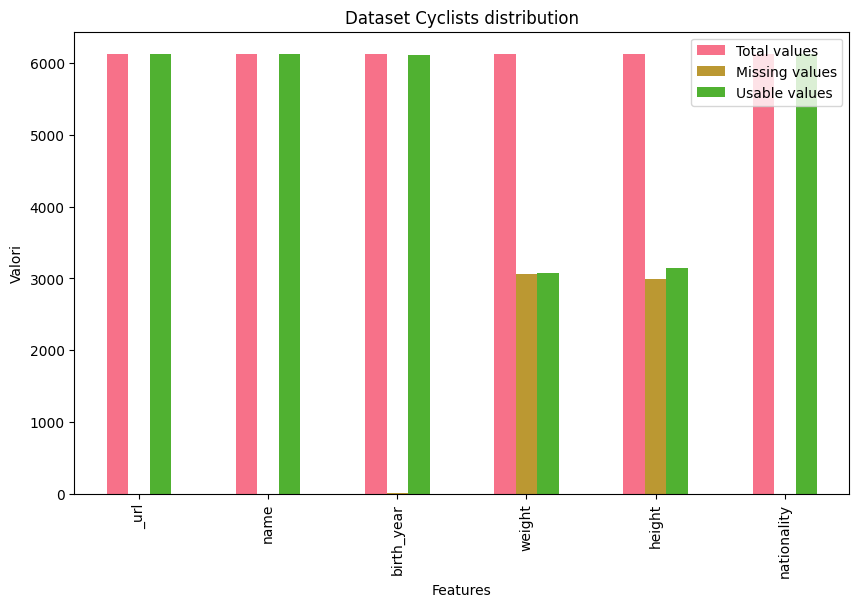

In [17]:
PlotMissingUsableData(DatasetCyclists, "Cyclists")

Si può vedere che:

- La mancanza di dati è importante nelle colonne "weight" e "height".
- Nella colonna "birth_year" manca qualche dato e su "nationality" un solo dato.

### Correct values check (Margherita)

### Features distributions

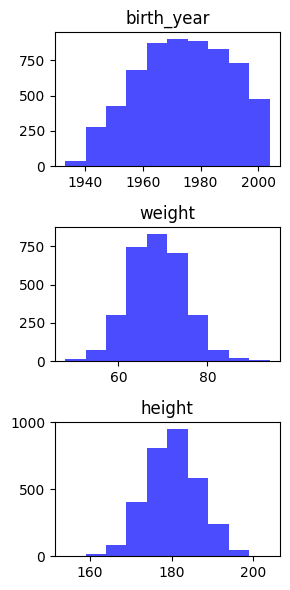

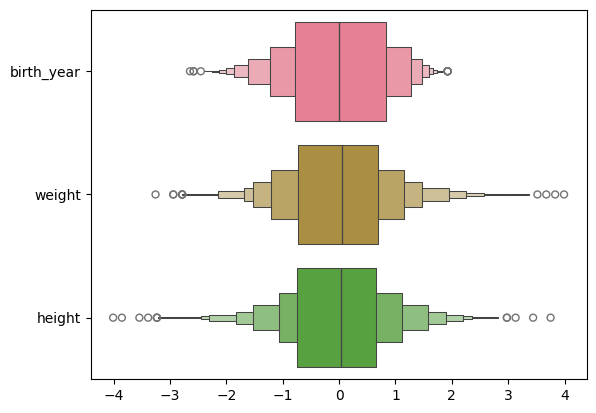

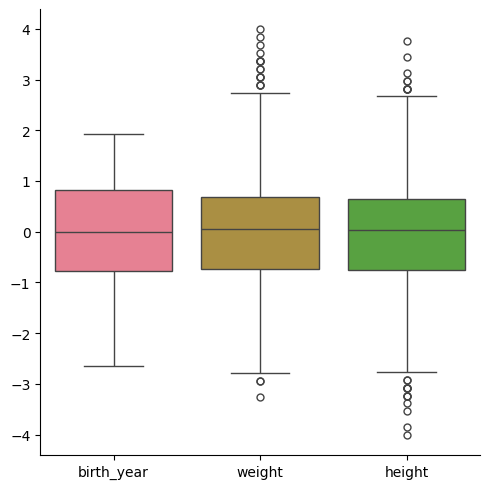

In [18]:
InterestingFeatures = ["birth_year", "weight", "height"]

PlotDistributionFeatures(DatasetCyclists, InterestingFeatures)

Le distribuzioni seguono tutte una distribuzione gaussiana è la presenza di outlier è più (ma non troppo) presente sulle colonne "weight" e "height".

### Correlations between features (Oleskiy)

What follows are the most important relationships between features, in my opinion, to show.
To see a complete analysis go to file [OleksiyRelFeature.ipynb](OleksiyRelFeature.ipynb)

#### Begin the analysis with a correlation matrix

Let's begin the analysis with a big correlation matrix that contains all the significant features from the `DatasetCyclists` and `DatasetRaces` frames.

`

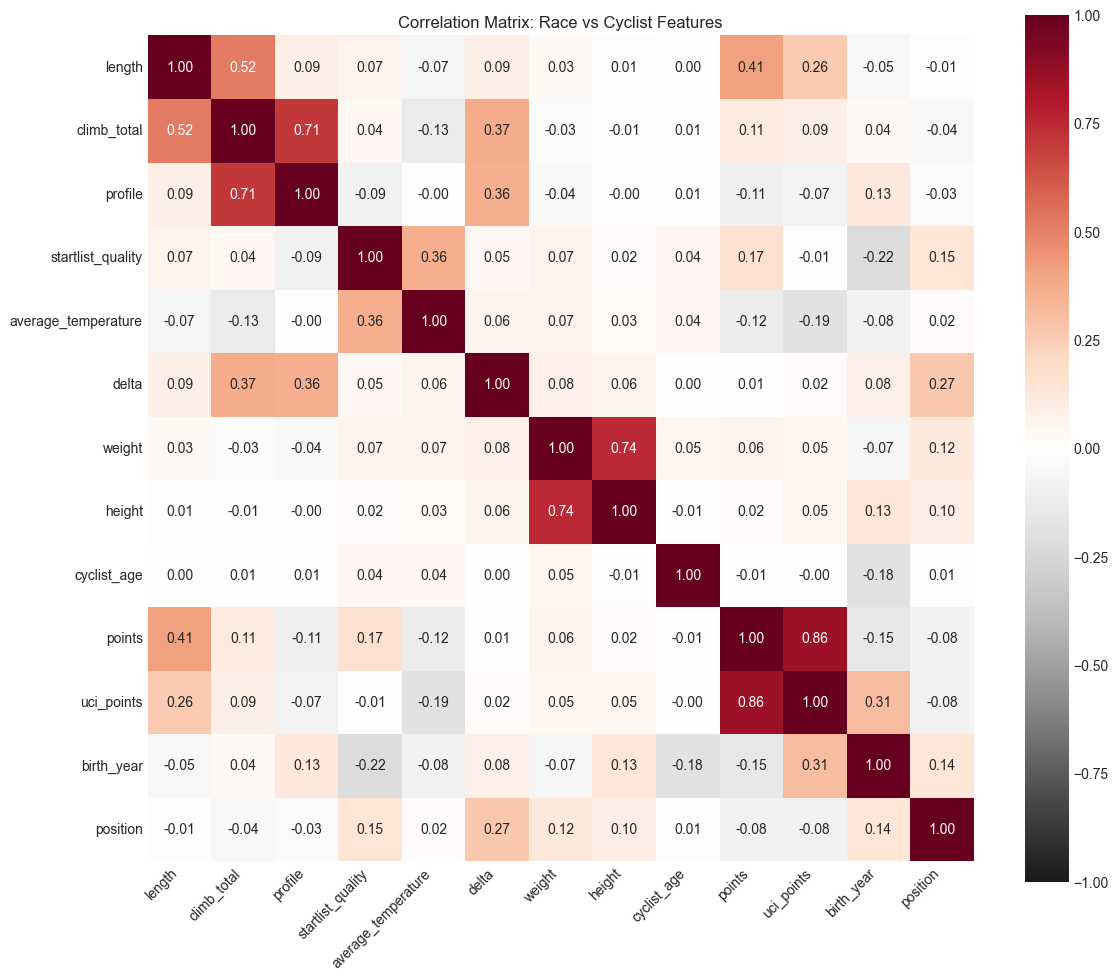

In [36]:
columns_of_interest = [
        'length', 'climb_total', 'profile', 'startlist_quality', 
        'average_temperature', 'delta', 'weight', 'height', 
        'cyclist_age', 'points', 'uci_points', 'birth_year', 'position'
]

def create_correlation_matrix(merged_df, columns_of_interest=columns_of_interest):
    # Select the relevant columns from the correlation matrix shown in the image
    
    
    # Create a copy of races dataframe with selected columns
    race_data = merged_df[columns_of_interest].copy()
    
    # Calculate correlation matrix
    corr_matrix = race_data.corr(method='pearson')
    
    # Create the visualization
    plt.figure(figsize=(12, 10))
    
    # Create heatmap
    seaborn.heatmap(corr_matrix, 
                annot=True,  # Show correlation values
                fmt='.2f',   # Format to 2 decimal places
                cmap='RdGy_r',  # Red-Grey-Blue colormap reversed
                vmin=-1,     # Minimum correlation value
                vmax=1,      # Maximum correlation value
                center=0,    # Center the colormap at 0
                square=True) # Make the plot square-shaped
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Add title
    plt.title('Correlation Matrix: Race vs Cyclist Features')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt.gcf(), corr_matrix


fig,corr_matrix = create_correlation_matrix(merged_df=MergedDataset)
plt.show()
plt.close(fig)


#### Since the best correlations might be hard to see, I will show below the top 6 positive and negative ones.



#### Comments on the positive correlations
There are expected positive correlations like `weight` and `height`. Something that might be of interest is the correlation between `points` and `uci_points`. What is surprising is the small correlation between `climb_total` and `delta`, but it probably makes sense since the bigger the climb, the further cyclists will arrive from the first one.There are expected positive correlations like `weight` and `height`. Something that might be of interest is the correlation between `points` and `uci_points`. What is surprising is the small correlation between `climb_total` and `delta`, but it probably makes sense since the bigger the climb, the further cyclists will arrive from the first one.There are expected positive correlations like `weight` and `height`. Something that might be of interest is the correlation between `points` and `uci_points`. What is surprising is the small correlation between `climb_total` and `delta`, but it probably makes sense since the bigger the climb, the further cyclists will arrive from the first one.

#### Comments on the negative correlations

There is a small correlation between the ```startlist_quality``` feature and the birth_year, which might suggest that if the race has many young riders, it will have lower `startlist_quality`. The negative correlation between points and `birth_year` makes sense since younger cyclists tend to have fewer `points`.

There is a slightly negative correlation between the `average_temperature` and `uci_points` that can be further investigated.


#### `weight`, `height` and race `profile` influence the `position`? 

Let's see if the `weight` and `height` of the riders, coupled with the race `profile`, influence the position of the cyclist.

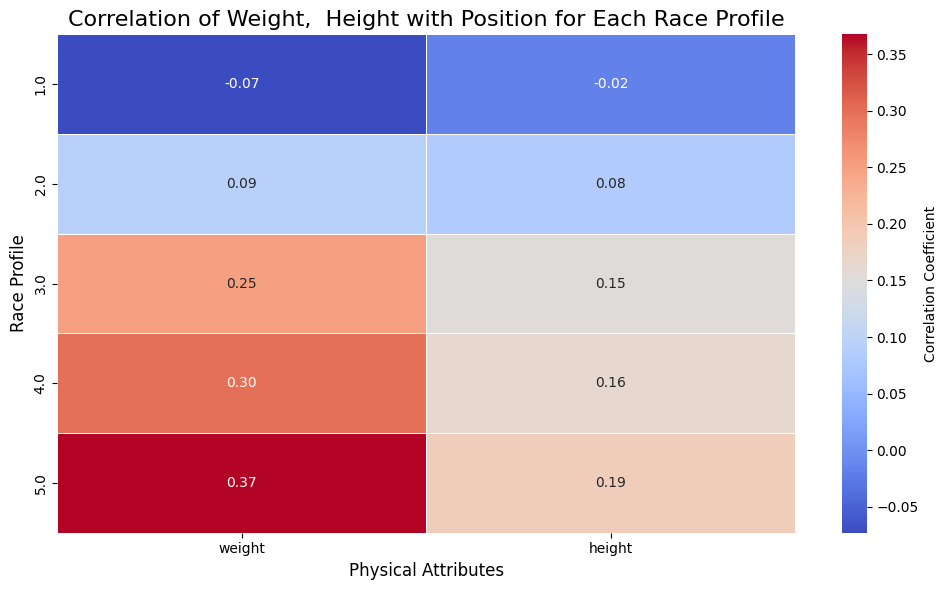

In [5]:
whpp_cor_feat = ['weight', 'height', 'position', 'profile']
whpp_cor_df = MergedDataset[whpp_cor_feat].copy()

correlations = whpp_cor_df.groupby('profile')[['weight', 'height', 'position']].corr()

correlations = correlations.xs('position', level=1).drop('position', axis=1)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
heatmap = seaborn.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})

# Customize the heatmap
heatmap.set_title('Correlation of Weight,  Height with Position for Each Race Profile', fontsize=16)
heatmap.set_xlabel('Physical Attributes', fontsize=12)
heatmap.set_ylabel('Race Profile', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
plt.close()
del whpp_cor_df

It clearly shows that lighter riders tend to finish in better positions when the climbing is significant, which makes perfect sense. The height has a smaller correlation, but we can still say that height might influence the final position of the rider if the race has a high profile.

#### Correlation between `average_temperature`, `nationality`, and `age_group`

Even though the `average_temperature` column has many `NaN` values, it is interesting to examine the mentioned correlations.



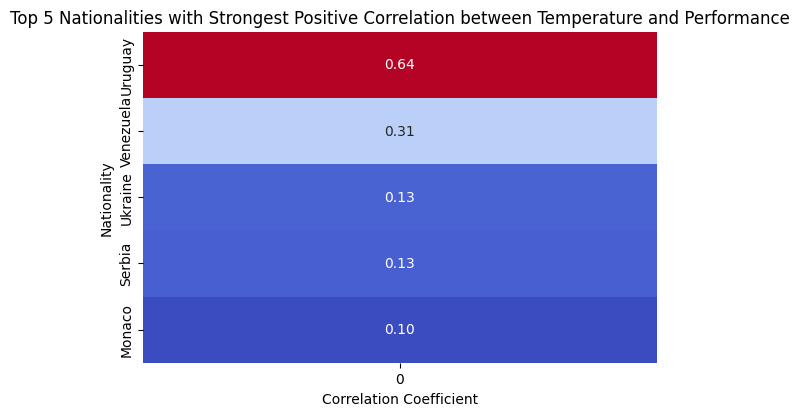

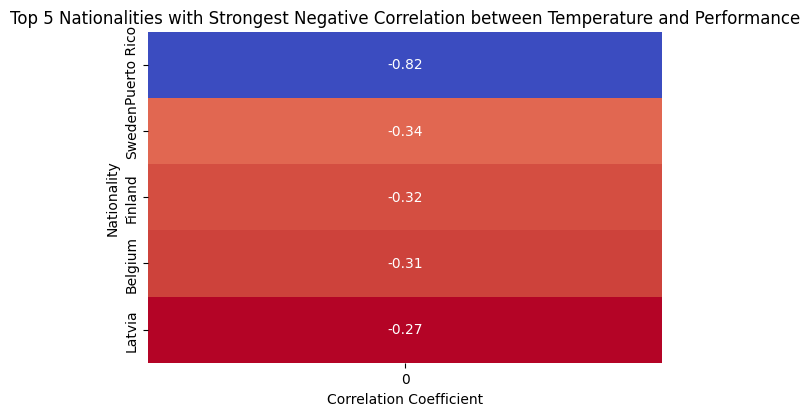

In [6]:
def calc_group_correlations(data, group_column):
    correlations = {}
    for group in data[group_column].unique():
        group_data = data[data[group_column] == group]
        if len(group_data) > 1:  # Ensure we have enough data points
            if group_data['average_temperature'].nunique() > 1 and group_data['average_temperature'].std() > 0 and group_data['points'].std() > 0:  # Ensure temperature varies
                corr, _ = stats.pearsonr(group_data['average_temperature'], group_data['points'])
                correlations[group] = corr
    return pd.Series(correlations)

ana_cor_feat = ['average_temperature', 'points', 'uci_points', 'position', 'nationality', 'cyclist_age']
ana_cor_df = MergedDataset[ana_cor_feat].copy()

# where uci_points is not null and position is null insert insert uci_points in position
ana_cor_df['position'] = ana_cor_df['position'].fillna(ana_cor_df['uci_points'])
ana_cor_df.dropna(subset=['points', 'average_temperature'], inplace=True)

nationality_correlations = calc_group_correlations(ana_cor_df, 'nationality')

heatmap_data = nationality_correlations.nlargest(5).to_frame()


heatmap = seaborn.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
heatmap.set_title('Top 5 Nationalities with Strongest Positive Correlation between Temperature and Performance')
heatmap.set_xlabel('Correlation Coefficient')
heatmap.set_ylabel('Nationality')

plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=1.0)
plt.show()
plt.close()

heatmap = seaborn.heatmap(nationality_correlations.nsmallest(5).to_frame(), annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
heatmap.set_title('Top 5 Nationalities with Strongest Negative Correlation between Temperature and Performance')
heatmap.set_xlabel('Correlation Coefficient')
heatmap.set_ylabel('Nationality')

plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=1.0)
plt.show()
plt.close()


As the correlation shows, riders coming from warmer countries may perform better in higher temperatures. In contrast, athletes from colder countries might struggle as temperatures rise. The outlier here is Puerto Rico, which could be interesting to investigate further.

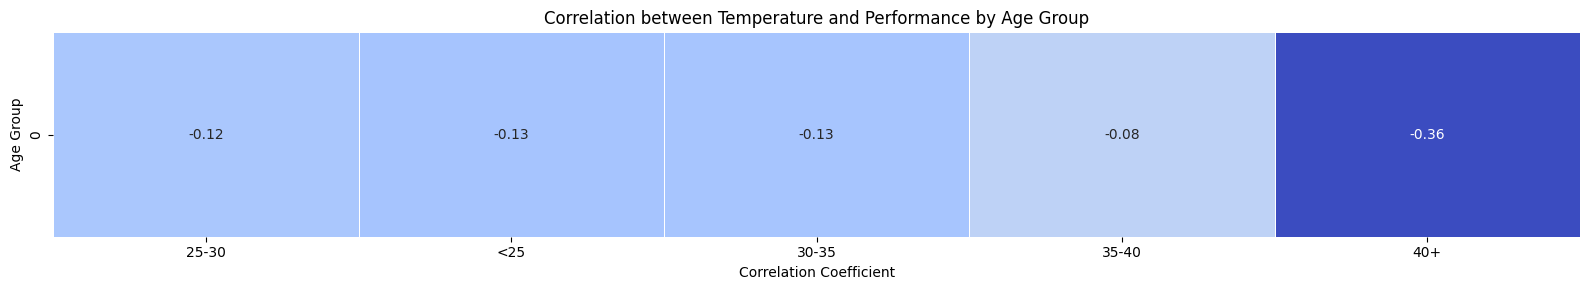

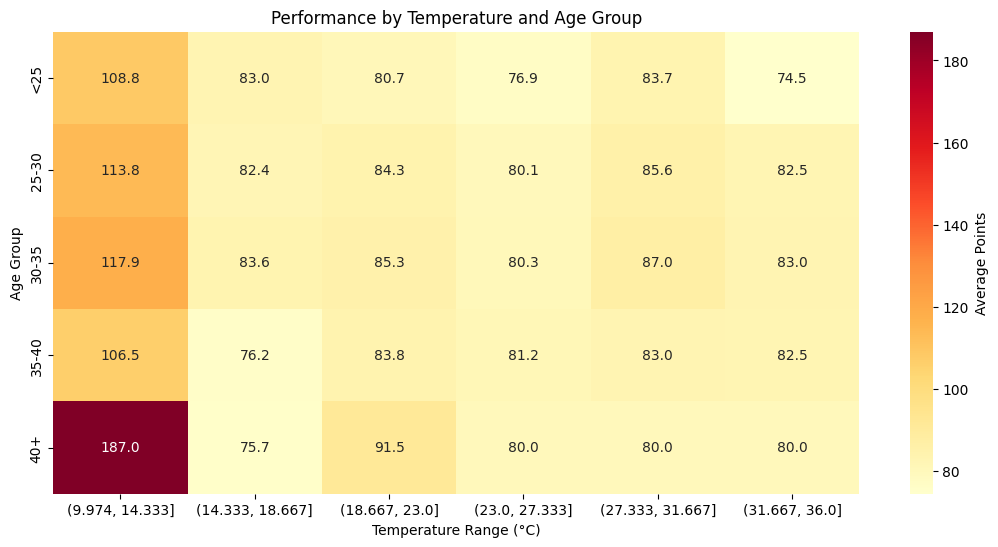

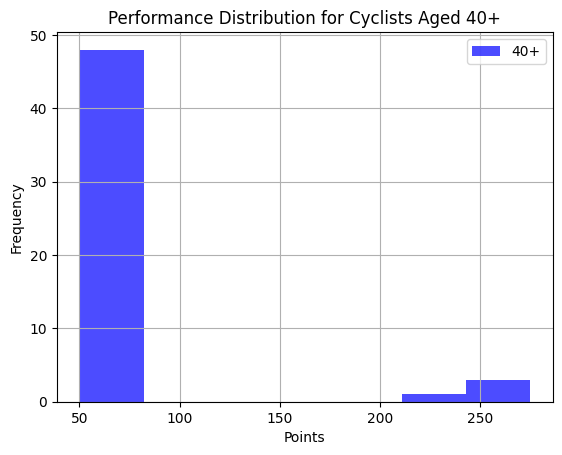

In [7]:
plt.figure(figsize=(16, 3))
ana_cor_df['age_group'] = pd.cut(ana_cor_df['cyclist_age'], bins=[0, 25, 30, 35, 40, 100], labels=['<25', '25-30', '30-35', '35-40', '40+'])
pivot = ana_cor_df.pivot_table(values='points', index='age_group', observed=True, columns=pd.cut(ana_cor_df['average_temperature'], bins=6), aggfunc='mean')
age_group_correlations = calc_group_correlations(ana_cor_df, 'age_group')

heatmap = seaborn.heatmap(age_group_correlations.to_frame().T, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f", cbar=False)
heatmap.set_title('Correlation between Temperature and Performance by Age Group')
heatmap.set_xlabel('Correlation Coefficient')
heatmap.set_ylabel('Age Group')

plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(13, 6))
pivot = ana_cor_df.pivot_table(values='points', index='age_group', observed=True, columns=pd.cut(ana_cor_df['average_temperature'], bins=6), aggfunc='mean')
seaborn.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='.1f', cbar_kws={'label': 'Average Points'})
plt.title('Performance by Temperature and Age Group')
plt.xlabel('Temperature Range (°C)')
plt.ylabel('Age Group')
plt.show()
plt.close()
ana_cor_df[ana_cor_df['age_group'] == '40+']['points'].hist(bins='auto', alpha=0.7, color='blue', label='40+')
plt.title('Performance Distribution for Cyclists Aged 40+')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend()
plt.show()
plt.close()

del ana_cor_df


The correlation between temperature and age groups might suggest that the older the rider, the stronger the temperature influences the rider's performance. However, as we can see in the second figure, there is an anomalously high average points in the colder temperature range for the 40+ age group, which might indicate outliers. Moreover, the histogram clearly shows that these are outliers due to their frequency.

### Cyclist's Career Span

Next, we will see the career span of top cyclists and how age influences their performance.


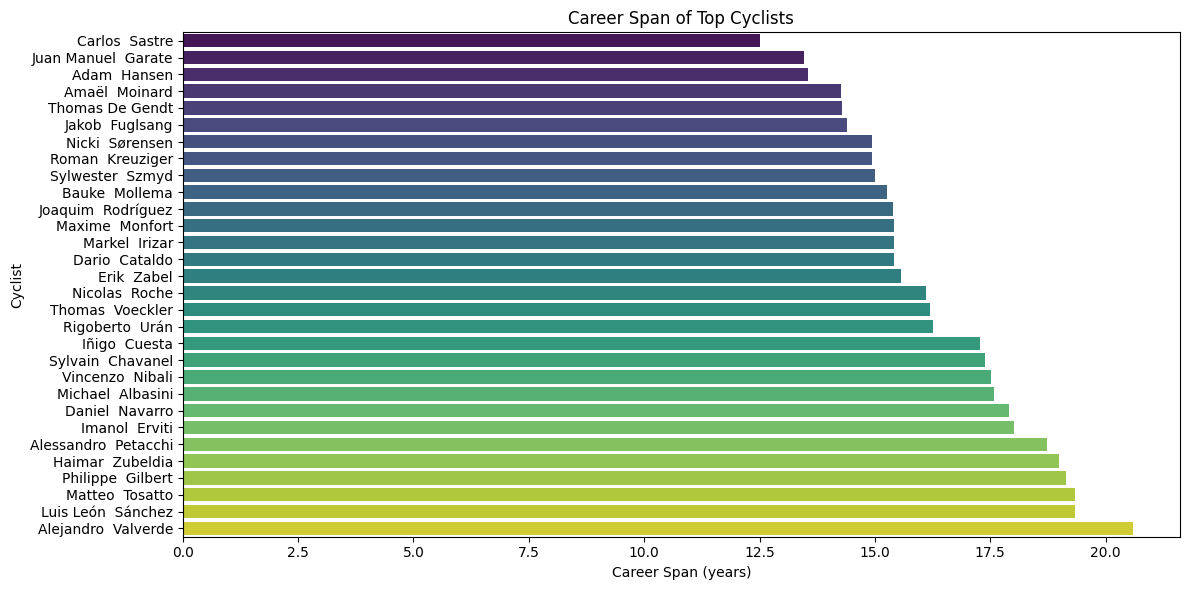

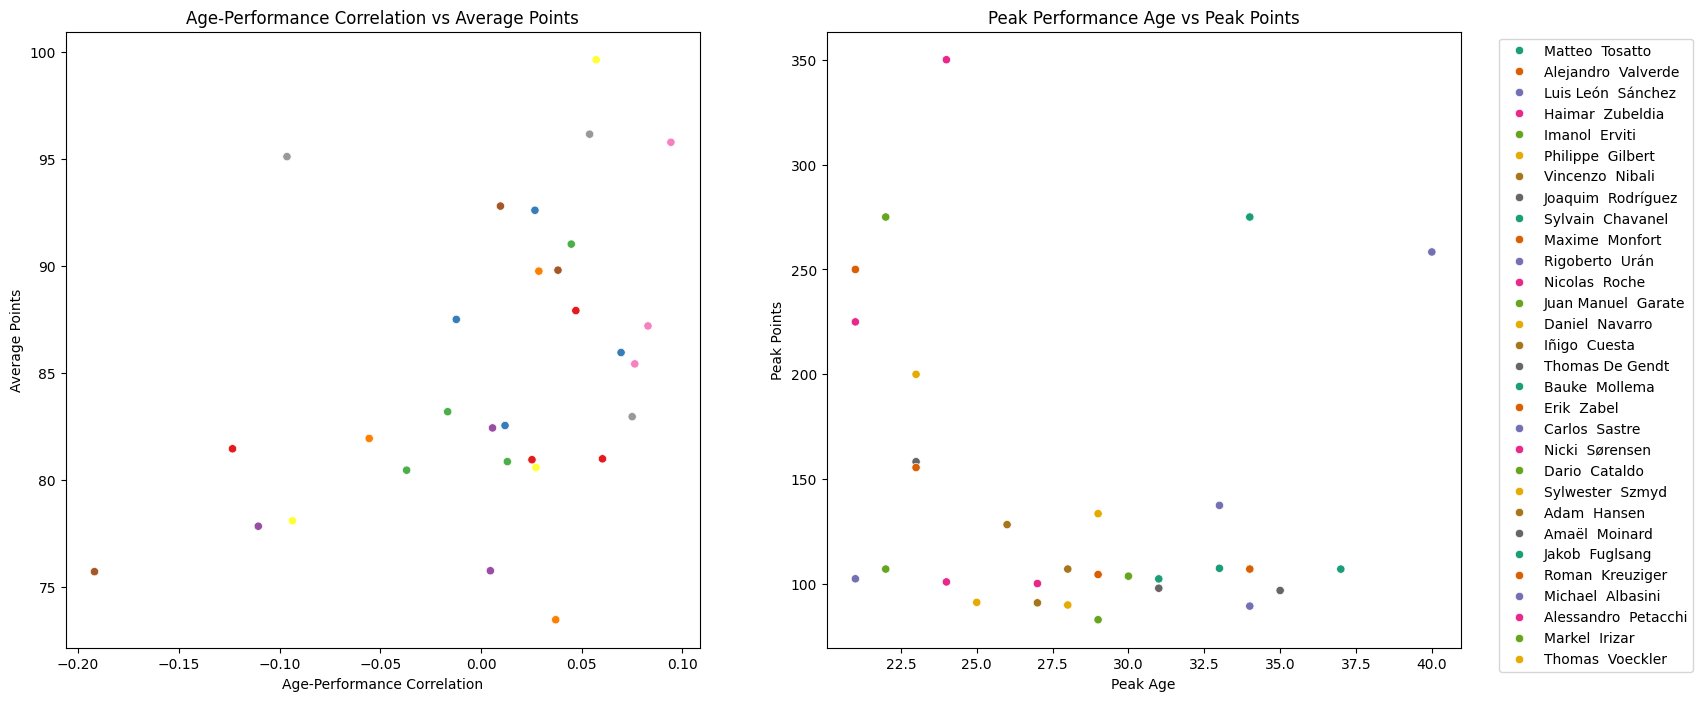

In [8]:
def analyze_cyclist_progression(cyclist_name, data, min_races=10, plot=True):
    cyclist_data = data[data['cyclist'] == cyclist_name].sort_values('date')
    
    if len(cyclist_data) < min_races:
        #print(f"{cyclist_name} has fewer than {min_races} races. Skipping.")
        return None
    
    # Calculate a rolling average of points
    cyclist_data['rolling_avg_points'] = cyclist_data['points'].rolling(window=10, min_periods=1).mean()
    if plot:
        # Plot the first
        # Plot career progression
        plt.figure(figsize=(12, 6))
        plt.plot(cyclist_data['date'], cyclist_data['rolling_avg_points'], label='Rolling Avg Points (10 races)')
        plt.scatter(cyclist_data['date'], cyclist_data['points'], alpha=0.3, color='gray', label='Race Points')
        plt.title(f"Career Progression of {cyclist_data['name_x'].iloc[0]}")
        plt.xlabel('Date')
        plt.ylabel('Points')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        plt.close()
        
    # Correlation between age and performance
    nona_data = cyclist_data.dropna(subset=['cyclist_age', 'points'])
    if nona_data['cyclist_age'].nunique() > 1 and nona_data['points'].std() > 0 \
        and nona_data['cyclist_age'].std() > 0:
        correlation, p_value = stats.pearsonr(nona_data['cyclist_age'], nona_data['points'])
    else:
        correlation, p_value = None, None
    return {
        'name': cyclist_data['name'].iloc[0],
        'cyclist': cyclist_name,
        'num_races': len(cyclist_data),
        'career_span': (cyclist_data['date'].max() - cyclist_data['date'].min()).days / 365,
        'avg_points': cyclist_data['points'].mean(),
        'max_points': cyclist_data['points'].max(),
        'age_performance_correlation': correlation,
        'p_value': p_value
    }

def analyze_performance_peaks(cyclist_name, data, min_races=10):
    cyclist_data = data[data['cyclist'] == cyclist_name].sort_values('date')
    
    if len(cyclist_data) < min_races:
        # print(f"{cyclist_name} has fewer than {min_races} races. Skipping.")
        return None
    
    # Find peak performance year
    peak_year = cyclist_data.groupby('year')['points'].mean().idxmax()
    peak_age = peak_year - cyclist_data['birth_year'].iloc[0]
    
    return {
        'name': cyclist_data['name'].iloc[0],
        'cyclist': cyclist_name,
        'peak_year': peak_year,
        'peak_age': peak_age,
        'peak_points': cyclist_data[cyclist_data['year'] == peak_year]['points'].mean()
    }

cs_cor_feat = ['points', 'uci_points', 'position', 'date', 'name', 'cyclist_age', 'cyclist', 'birth_year']
cs_cor_dr = MergedDataset[cs_cor_feat].copy()
cs_cor_dr['date'] = pd.to_datetime(cs_cor_dr['date'])
cs_cor_dr['year'] = cs_cor_dr['date'].dt.year
top_cyclists = cs_cor_dr['cyclist'].value_counts().index[:30]
progression_data = [analyze_cyclist_progression(cyclist, cs_cor_dr, plot=False) for cyclist in top_cyclists]

progression_df = pd.DataFrame([data for data in progression_data if data is not None])

plt.figure(figsize=(12, 6))
seaborn.barplot(
    x='career_span', 
    y='name', 
    data=progression_df.sort_values('career_span'), 
    hue='name', 
    dodge=False,  # This avoids separating bars by hue
    palette='viridis', 
    legend=False
)
plt.title('Career Span of Top Cyclists')
plt.xlabel('Career Span (years)')
plt.ylabel('Cyclist')
plt.tight_layout()
plt.show()
plt.close()




# Visualize age-performance correlation
fig = plt.figure(figsize=(18, 8))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.2, hspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
seaborn.scatterplot(x='age_performance_correlation', y='avg_points', data=progression_df, hue='name', palette='Set1')
ax1.set_title('Age-Performance Correlation vs Average Points')
ax1.set_xlabel('Age-Performance Correlation')
ax1.set_ylabel('Average Points')
ax1.get_legend().remove()

peak_df = pd.DataFrame([analyze_performance_peaks(cyclist, cs_cor_dr) for cyclist in top_cyclists])

ax2 = fig.add_subplot(gs[0, 1])
# Visualize peak ages with annotations
seaborn.scatterplot(x='peak_age', y='peak_points', data=peak_df, hue='name', palette='Dark2')
ax2.set_title('Peak Performance Age vs Peak Points')
ax2.set_xlabel('Peak Age')
ax2.set_ylabel('Peak Points')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()
plt.show()
plt.close()


del peak_df 
del progression_df


We can see that there aren't many cyclists with long careers. We can also see that for some, age has a negative effect, while for others, it has a slightly positive one. The peak performance, for the majority, occurs in the span between 25 and 35 years. Some outliers are noticeable for peak performance and peak age.

#### Let's plot the age-performance correlation for each rider.

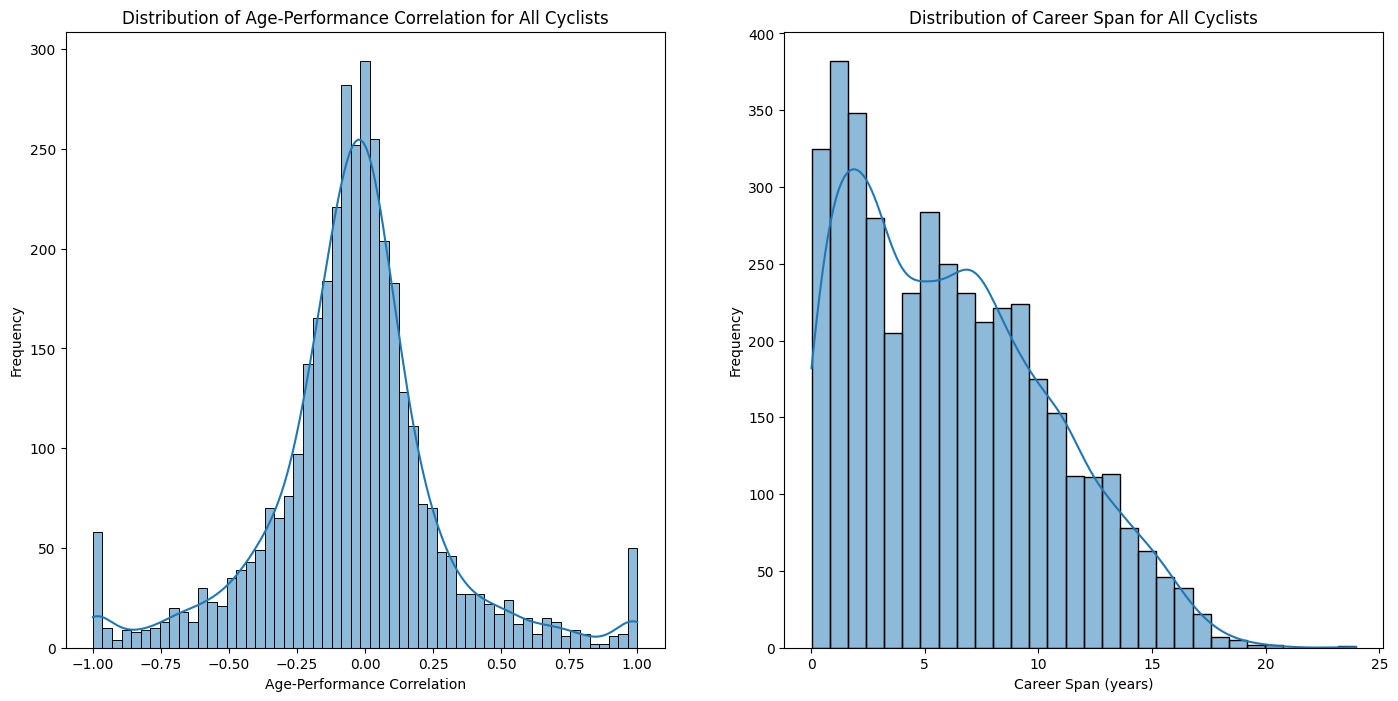

In [9]:
all_cyclists = cs_cor_dr['cyclist'].unique()
progression_data_all_cyclists = [analyze_cyclist_progression(cyclist, cs_cor_dr, plot=False) for cyclist in all_cyclists]
progression_data_all_cyclists = [data for data in progression_data_all_cyclists if data is not None]

prog_df = pd.DataFrame(progression_data_all_cyclists)


# Visualize age-performance correlation for all cyclists
fig = plt.figure(figsize=(17, 8))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.2, hspace=0.2)

ax1 = plt.subplot(gs[0, 0])
seaborn.histplot([data['age_performance_correlation'] for data in progression_data_all_cyclists], bins="auto", kde=True)
ax1.set_title('Distribution of Age-Performance Correlation for All Cyclists')
ax1.set_xlabel('Age-Performance Correlation')
ax1.set_ylabel('Frequency')

ax2 = plt.subplot(gs[0, 1])
seaborn.histplot(prog_df['career_span'], bins=30, kde=True)
ax2.set_title('Distribution of Career Span for All Cyclists')
ax2.set_xlabel('Career Span (years)')
ax2.set_ylabel('Frequency')
plt.show()
plt.close(fig)
del prog_df
del cs_cor_dr

The results show a clearly bell-shaped distribution, which isn't surprising. For some, age does hinder performance, but for most, it doesn't.

As regards the histogram of career span, we can see that the distribution is right-skewed, meaning there are very few cyclists with long careers. Surprisingly, the number of riders that have a cycling span between 0 and 3 years is high, which might mean that cycling is a very physically demanding sport.

#### Radar Plot of Physical Attributes of Top Performers by Race Type


In [10]:
tprt_rad_feat = ['name', 'height', 'weight', 'date', 'profile', 'points', 'cyclist_age']

tprt_rad_df = MergedDataset[tprt_rad_feat].copy().dropna(subset=['height', 'weight', 'points'])

# Calculate BMI
tprt_rad_df['bmi'] = tprt_rad_df['weight'] / ((tprt_rad_df['height'] / 100) ** 2)

# Calculate years of experience
tprt_rad_df['career_start'] = tprt_rad_df.groupby('name')['date'].transform('min')
tprt_rad_df['experience'] = (pd.to_datetime(tprt_rad_df['date']) - pd.to_datetime(tprt_rad_df['career_start'])).dt.days / 365.25

# Function to categorize race profile
def categorize_profile(profile):
    if profile < 1.5:
        return 'Flat'
    elif profile < 3:
        return 'Hilly'
    elif profile < 4:
        return 'Mountainous'
    elif profile < 5:
        return 'High Mountainous'
    else:
        return 'Really High Mountainous'

# Add race category to the dataframe
tprt_rad_df['race_category'] = tprt_rad_df['profile'].apply(categorize_profile)

# Function to get top performer for each race category
def get_top_performer(category):
    category_data = tprt_rad_df[tprt_rad_df['race_category'] == category]
    top_cyclist = category_data.groupby('name')['points'].mean().idxmax()
    return category_data[category_data['name'] == top_cyclist].iloc[0]

# Get top performers
top_performers = {
    'Flat': get_top_performer('Flat'),
    'Hilly': get_top_performer('Hilly'),
    'Mountainous': get_top_performer('Mountainous'),
    'High Mountainous': get_top_performer('High Mountainous'),
    'Really High Mountainous': get_top_performer('Really High Mountainous')
}

# Prepare data for radar plot
attributes = ['height', 'weight', 'bmi', 'cyclist_age', 'experience']
data = {category: [cyclist[attr] for attr in attributes] for category, cyclist in top_performers.items()}

# Normalize the data separately for each attribute
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(pd.DataFrame(data, index=attributes).T).T

# Function to create enhanced radar plot using Plotly
def radar_plot(data, title, names):
    fig = go.Figure()

    for i, (category, values) in enumerate(data.items()):
        fig.add_trace(go.Scatterpolar(
            r=values + values[:1],  # Repeat the first value for closure
            theta=attributes + [attributes[0]],  # Repeat the first attribute for closure
            fill='toself',
            name=f"{category} - {names[category]}",
            opacity=0.6,
            marker=dict(size=8)
        ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 2],
                showline=True,
                linewidth=1,
                tickfont=dict(size=10)
            )
        ),
        showlegend=True,
        title=title,
        legend=dict(font=dict(size=12))
    )
    
    return fig

# Create the plot with normalized data and cyclist names
cyclist_names = {category: cyclist['name'] for category, cyclist in top_performers.items()}
fig = radar_plot(dict(zip(top_performers.keys(), normalized_data)), 
                 "Physical Attributes of Top Performers by Race Type", cyclist_names)

# Show the plot
fig.show()
del tprt_rad_feat

We can see that there is a relationship between terrain difficulty and the rider's BMI, which in some cases has a positive impact. It can be said that the more extreme the terrain is, the more tactical experience matters.

#### Race Profile vs Points/UCI points Scatter Plot.

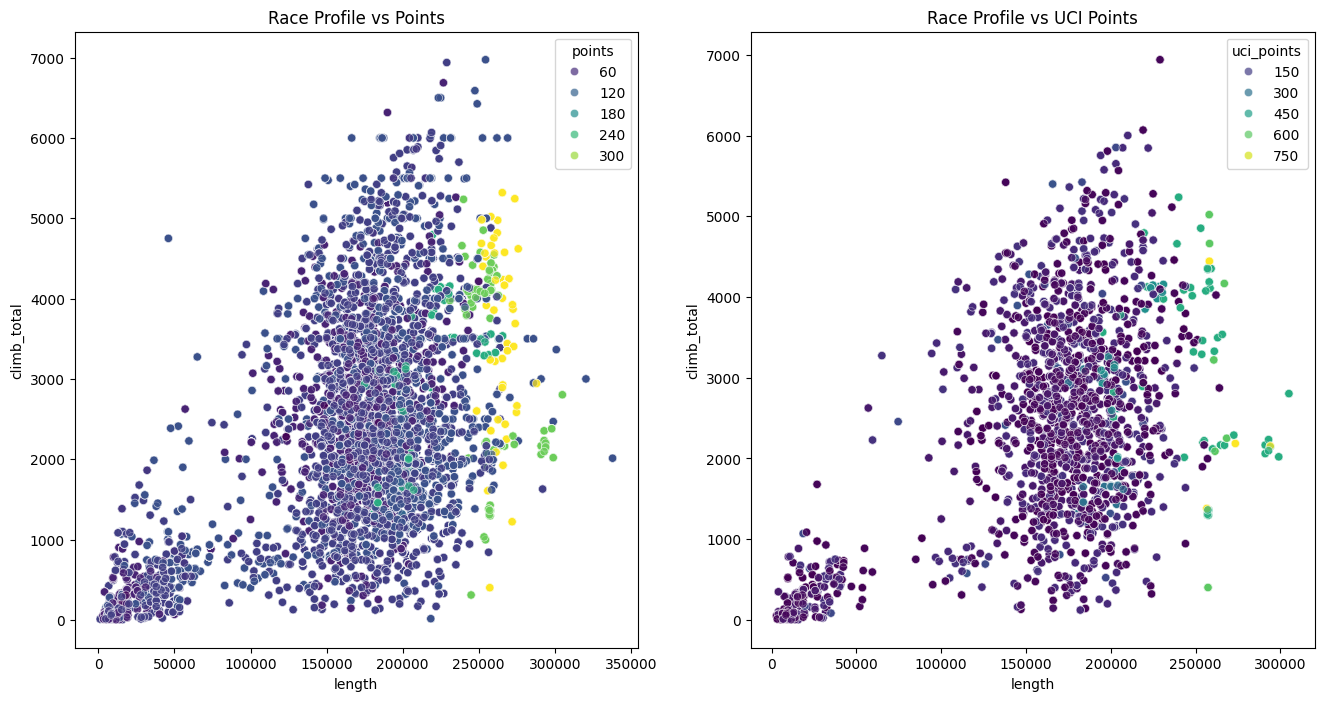

In [11]:
rppu_scat_feat = ['length', 'climb_total', 'points', 'uci_points', 'profile']
rppu_scat_df = MergedDataset[rppu_scat_feat].copy()

# 3.1 Race Profile vs Cyclist Performance
fig = plt.figure(figsize=(16, 8))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.2, hspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
seaborn.scatterplot(x='length', y='climb_total', hue='points', data=rppu_scat_df, palette='viridis', alpha=0.7)
ax1.set_title('Race Profile vs Points')


# 3.2 Race Profile vs Cyclist UCI Points
ax2 = fig.add_subplot(gs[0, 1])
seaborn.scatterplot(x='length', y='climb_total', hue='uci_points', data=rppu_scat_df, palette='viridis', alpha=0.7)
ax2.set_title('Race Profile vs UCI Points')


plt.show()
plt.close()
del rppu_scat_feat

We can see the correlation between `points` and `uci_points`, as the scatter plots are very similar. The only notable difference is that `uci_points` tend to have higher values. Additionally, `uci_points` are more selective, with fewer high-point races compared to the general point system. However, this might be due to the fact that we have fewer `uci_points` values.

We can observe a trend where longer races with more climbing tend to award more points. These plots show that to earn high points, cyclists need to excel in both endurance and climbing ability. Riders in very short flat races have fewer opportunities for high point gains.

#### Tarmac vs Points/UCI Points and Profiles vs Points/UCI points box plots

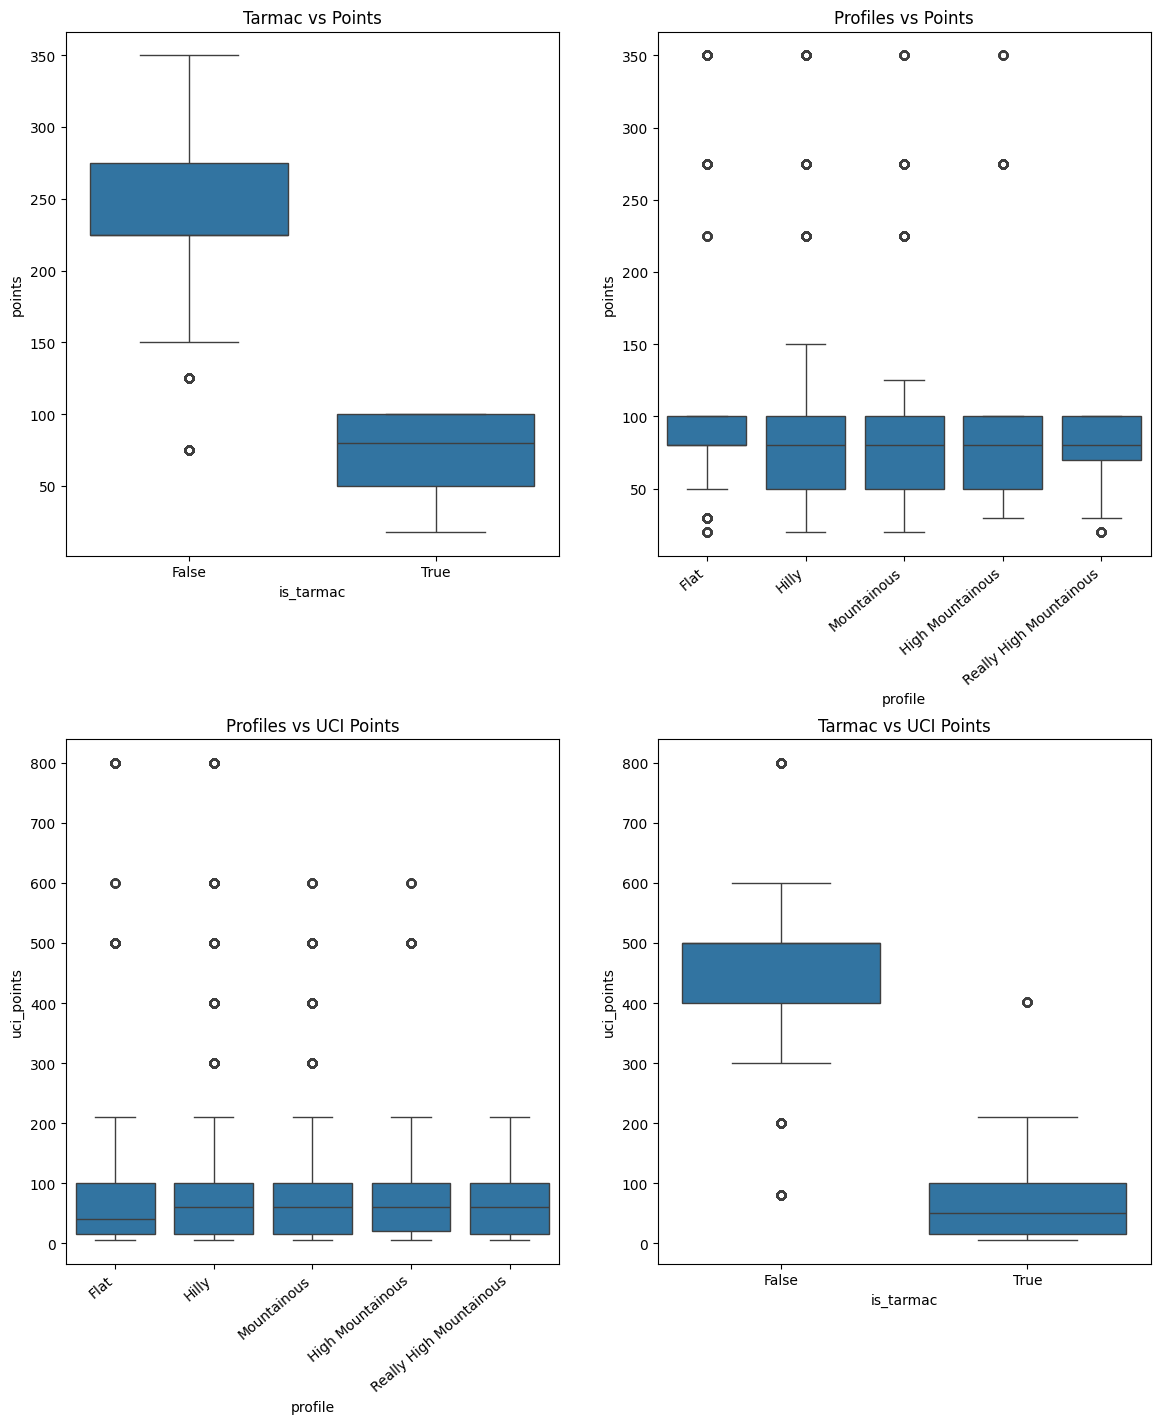

In [12]:
seaborn.color_palette("pastel")

tpu_box_feat = ['is_tarmac', 'profile', 'points', 'uci_points']
tpu_box_dr = MergedDataset[tpu_box_feat].copy()


fig = plt.figure(figsize=(14, 16))
gs = plt.GridSpec(2, 2, figure=fig, wspace=0.2, hspace=0.35)

ax1 = fig.add_subplot(gs[0, 0])
profiles = seaborn.boxplot(x='is_tarmac', y='points', data=tpu_box_dr, ax=ax1)
ax1.set_title('Tarmac vs Points')


ax2 = fig.add_subplot(gs[0, 1])
profiles = seaborn.boxplot(x='profile', y='points', data=tpu_box_dr, ax=ax2)
profiles.set_xticks(profiles.get_xticks())
profiles.set_xticklabels(['Flat', 'Hilly', 'Mountainous', 'High Mountainous', 'Really High Mountainous'])
ax2.set_title('Profiles vs Points')
plt.xticks(rotation=40, ha='right',horizontalalignment='right')



# 5.2 Race Surface vs Cyclist UCI Points

ax3 = fig.add_subplot(gs[1, 1])
profiles = seaborn.boxplot(x='is_tarmac', y='uci_points', data=tpu_box_dr, ax=ax3)
ax3.set_title('Tarmac vs UCI Points')

ax4 = fig.add_subplot(gs[1, 0])
profiles = seaborn.boxplot(x='profile', y='uci_points', data=tpu_box_dr, ax=ax4)
ax4.set_xticks(profiles.get_xticks())
ax4.set_xticklabels(['Flat', 'Hilly', 'Mountainous', 'High Mountainous', 'Really High Mountainous'])
ax4.set_title('Profiles vs UCI Points')


plt.xticks(rotation=40, ha='right',horizontalalignment='right')
# plt.tight_layout()
plt.show()
plt.close()



The analysis of box plots comparing points and UCI points across tarmac, non-tarmac, and race profiles reveals a structured scoring system that values versatility across terrains and disciplines. In both systems, non-tarmac events—likely off-road or mountain bike races—award significantly higher points, with medians around 225 and 450 for points and UCI points, respectively, compared to lower values for tarmac races. This indicates a greater emphasis on non-tarmac disciplines, potentially to encourage participation. 

Across profiles, points are fairly similar, with medians generally between 75-100 points, though flat and extreme mountainous profiles (like "Really High Mountainous") show slightly higher medians. Outliers with much higher points in each category likely represent prestigious events, such as key stages in Grand Tours or significant classics. 

The variability within profiles, especially in hilly and mountainous categories, suggests a range of race difficulties. Flat races, although often standardized, still hold a respectable median value, while high mountainous profiles don’t always award the highest average points, yet include notable outliers. The scoring structure encourages cyclists to compete across various race types, with specialization still possible in specific profiles or terrains. 

For the UCI points specifically, the balanced distribution across race profiles on tarmac suggests an effort to value different road racing profiles equally, while the prominent role of non-tarmac events highlights a focus on promoting diverse cycling disciplines. Overall, both systems seem aimed at fostering well-rounded cyclists capable of excelling across different terrains, while also highlighting prestigious events within each category.

### Conclusions

Per la prossima fase di data transformation, sono state decise le seguenti decisioni per il dataset **cyclists**:

- 

## Dataset race

### Missing values distributions

                     Total values  Missing values  Usable values
Elements                                                        
_url                       589865               0         589865
name                       589865               0         589865
points                     589865             477         589388
uci_points                 589865          338779         251086
length                     589865               0         589865
climb_total                589865          147045         442820
profile                    589865          148194         441671
startlist_quality          589865               0         589865
average_temperature        589865          559932          29933
date                       589865               0         589865
position                   589865               0         589865
cyclist                    589865               0         589865
cyclist_age                589865             113         589752
is_tarmac                

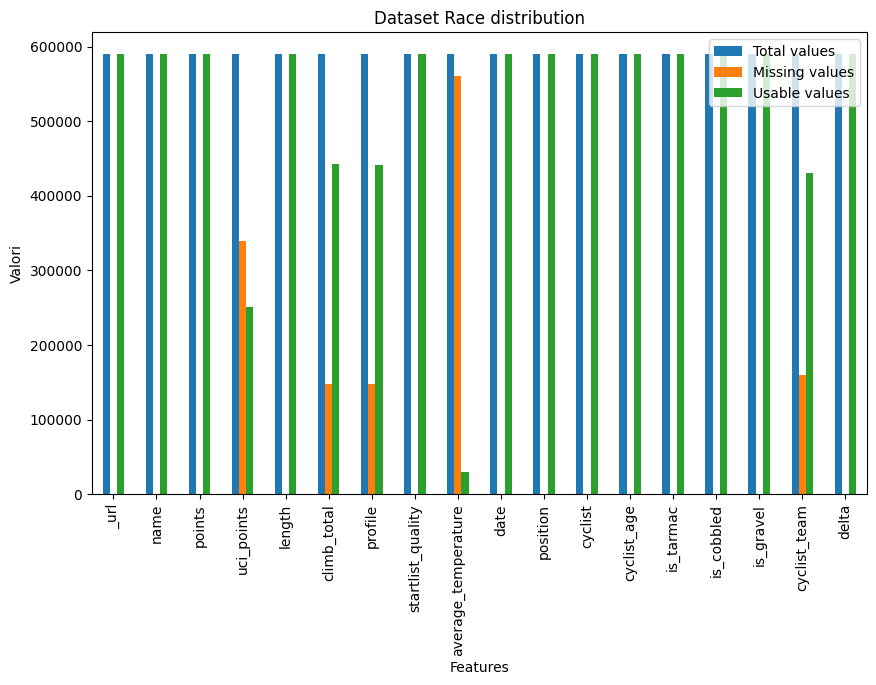

In [36]:
PlotMissingUsableData(DatasetRace, "Race")

Si può vedere che:

- La mancanza di dati è importante nelle colonne "uci_points", "average_temperature", "cyclists_team", "climb_total" e "profile".

### Correct values check (Margherita)

### Features distributions

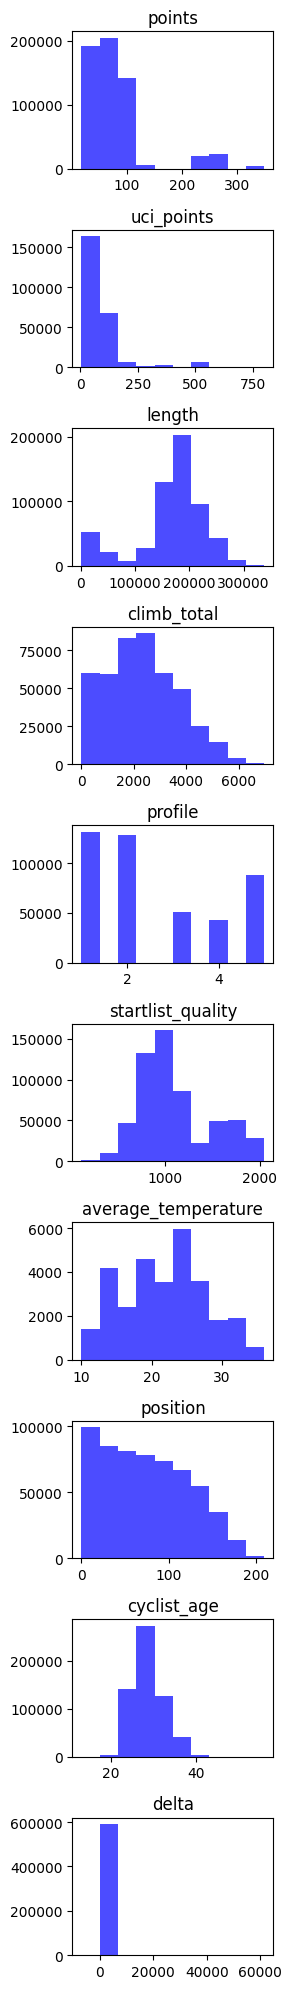

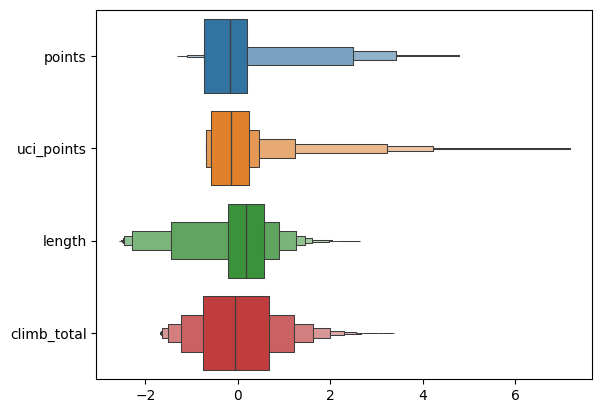

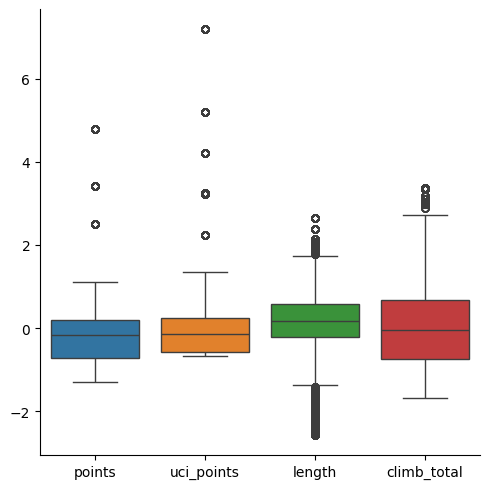

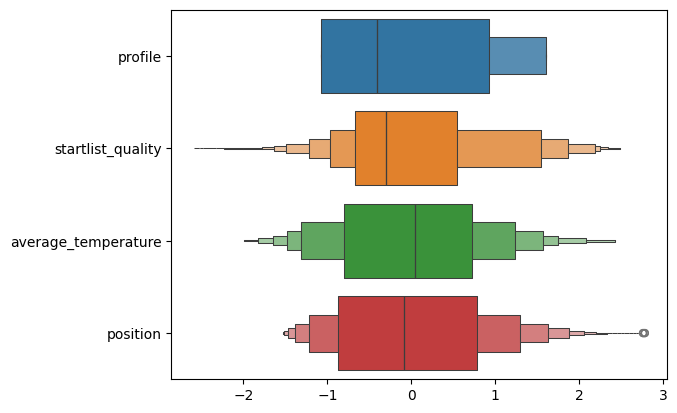

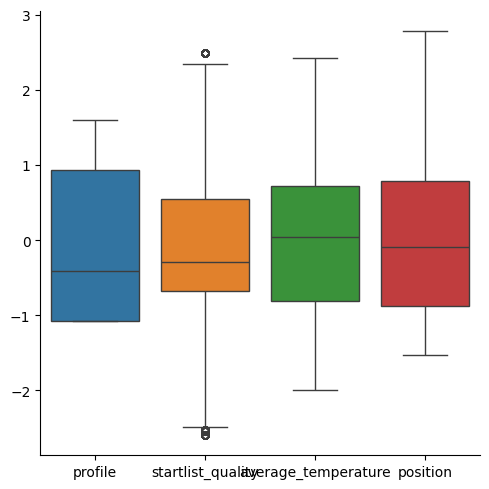

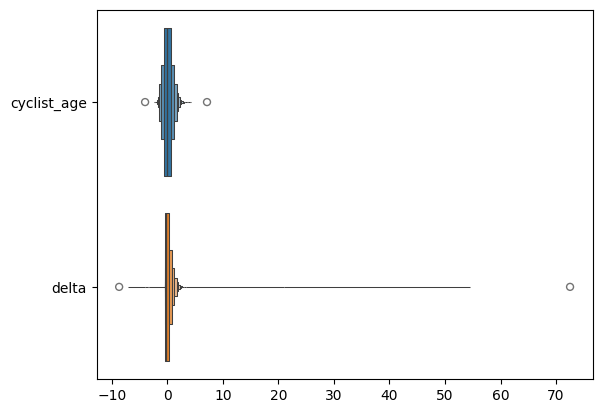

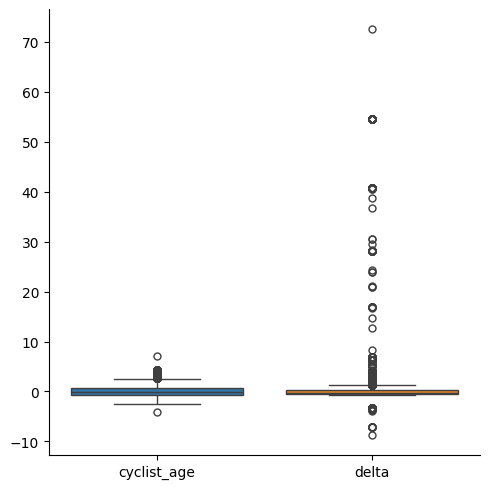

In [37]:
InterestingFeatures = ["points", "uci_points", "length", "climb_total", "profile",
                       "startlist_quality", "average_temperature", "position", "cyclist_age", "delta"]

PlotDistributionFeatures(DatasetRace, InterestingFeatures)

Nella maggior parte delle colonne ci sono distribuzioni non uniformi e la presenza di outlier è sopratutto su "delta", "cyclists_age" e "climb_total" 

### Conclusions

Per la prossima fase di data transformation, sono state decise le seguenti decisioni per il dataset **race**:

- 

# **Data cleaning**

## Dataset cyclists

### Fill nationality data missing

Si va a riempire il dato mancante nella colonna "nationality", il valore è stato cercato su Google.

In [38]:
ScottDavisIndex = DatasetCyclists[DatasetCyclists["nationality"].isnull()].index[0]
DatasetCyclists.loc[ScottDavisIndex, "nationality"] = "Great Britain"

### Fill data of weight and height columns

Si va a riempire le colonne di "height" e "weight" sfruttando i dati tra loro. Si è scoperto che hanno un alta correlazione.

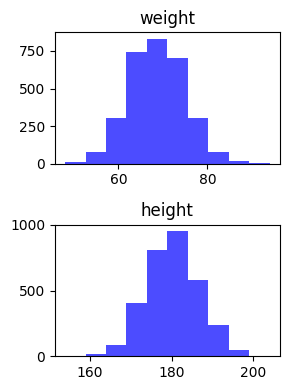

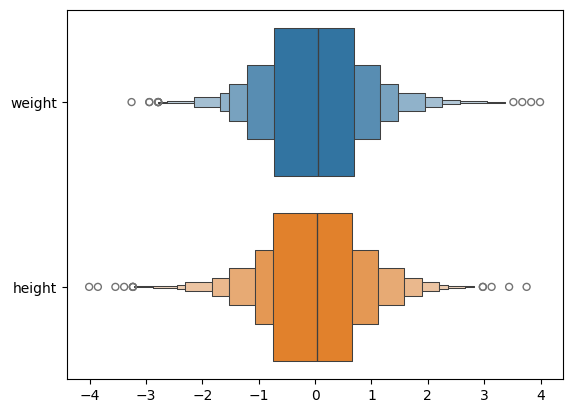

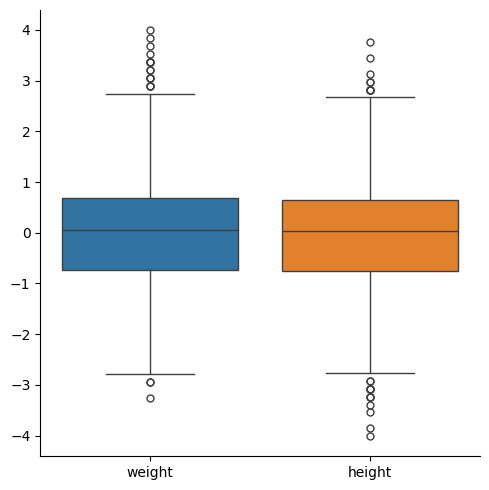

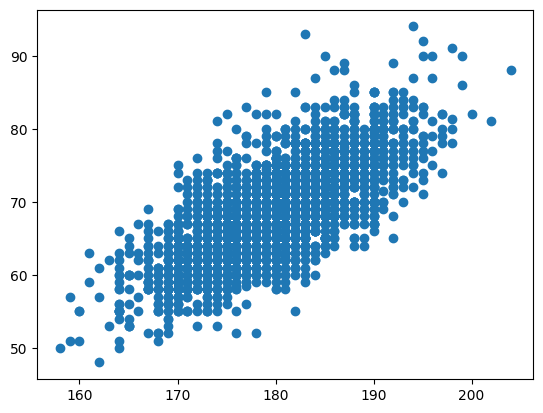

In [39]:
#Inferenza sulle colonne weight ed height
PlotDistributionFeatures(DatasetCyclists, ["weight", "height"])
plt.scatter(DatasetCyclists["height"], DatasetCyclists["weight"])

Si mostrano le distribuzioni e correlazioni delle 2 colonne tra loro.

In [40]:
TrainData = DatasetCyclists.dropna(subset=['weight', 'height'])

#Predizione dei valori sulle righe dove height c'è e weight manca (regressore lineare) e viceversa (con un altro regressore lineare)
HeightPredictor = LinearRegression()
WeightPredictor = LinearRegression()

#Allenamento dei regressori
for _ in range(1):
    HeightPredictor.fit(TrainData[['weight']], TrainData[['height']])
    WeightPredictor.fit(TrainData[['height']], TrainData[['weight']])

#Calcolo degl' indici dove andare a riempire i valori
HeightSlot = DatasetCyclists[DatasetCyclists['height'].isna() & DatasetCyclists['weight'].notna()]
WeightSlot = DatasetCyclists[DatasetCyclists['weight'].isna() & DatasetCyclists['height'].notna()]

#Calcolo dei valori mancanti
DatasetCyclists.loc[WeightSlot.index, 'weight'] = WeightPredictor.predict(WeightSlot[['height']])
DatasetCyclists.loc[HeightSlot.index, 'height'] = HeightPredictor.predict(HeightSlot[['weight']])

#Predizione dei valori sulle righe dove manca sia height che weight (distribuzione)
ColumnsCleaned = DatasetCyclists[["weight", "height"]].dropna()

#Creazione della distribuzione multivariata (2 dimensioni)
Distribution = multivariate_normal([ColumnsCleaned["weight"].mean(), ColumnsCleaned["height"].mean()],
                                   np.cov(ColumnsCleaned["weight"], ColumnsCleaned["height"]))

#Calcolo degl' indici dei valori missing
MissingIndex = DatasetCyclists[DatasetCyclists[['weight', 'height']].isna().any(axis=1)].index

#Riempimento dei valori mancanti con la distribuzione multivariata
DatasetCyclists.loc[MissingIndex, ['weight', 'height']] = Distribution.rvs(size=len(MissingIndex))


Si allena un regressore lineare per inferire sui dati "weight".
Si allena un regressore lineare per inferire sui dati "height".

Per i regressori si prepara un insieme di dati che sono le coppie dove ci sono entrambi i valori.

Si costruisce una distribuzione multivariata (2 dimensioni) usando i dati a disposizione + i dati inferiti con i regressori, dopodichè si campionano dei dati per poter inferire sui dati mancanti.

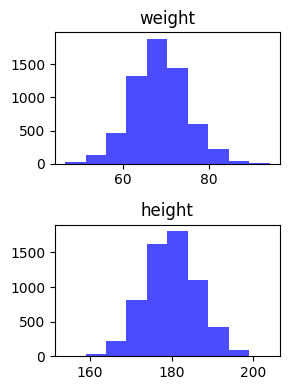

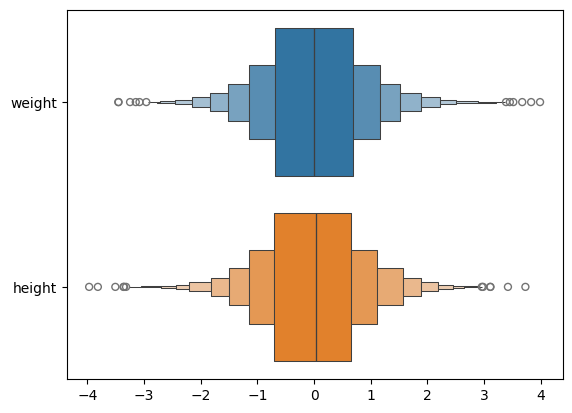

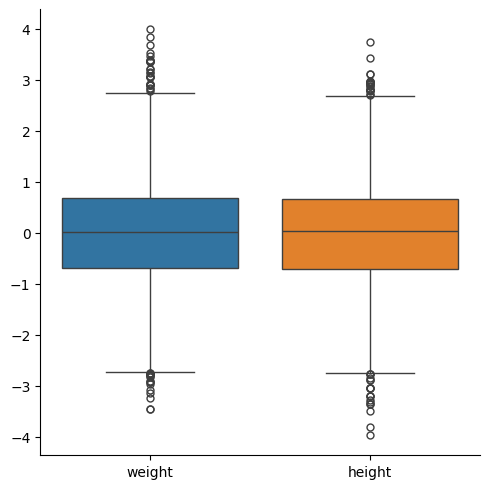

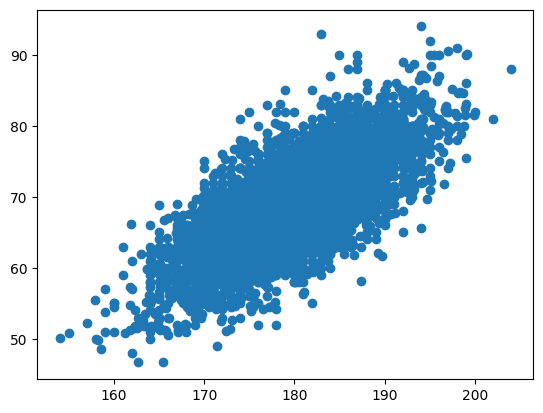

In [41]:
PlotDistributionFeatures(DatasetCyclists, ["weight", "height"])
plt.scatter(DatasetCyclists["height"], DatasetCyclists["weight"])

Si mostrano le distribuzioni e correlazioni delle colonne tra loro dopo il riempimento dei dati mancanti.

### Fill data of birth_year column (Riccardo)

In [ ]:
PreProcessing = DatasetRace.dropna(subset=["cyclist", "date", "cyclist_age"])

PreparedDatasetRace = pd.DataFrame({
    'name': PreProcessing["cyclist"],
    'date': list(map(lambda x, y: float(x.split("-")[0]) - y, PreProcessing["date"], PreProcessing["cyclist_age"]))
})

#Serve per vedere se per ogni ciclista ci sono più date di nascita calcolate, se si c'è un problema
GroupByCyclist = PreparedDatasetRace.groupby("name")
Counts = GroupByCyclist["date"].nunique()

for name in Counts.keys():
    if(Counts[name] != 1): print(f"Risulta che l' atleta {name} non abbia una sola data ma: [{', '.join(list(set(GroupByCyclist['date'])))}]")

Non si sono presentati problemi, per ogni atleta si è calcolata una sola data di nascita considerando tutte le sue corse, quindi i dati interessati (date e cyclist_age) non sono sbagliati. Ora si usano questi dati per metterli dentro le date di nascita del dataset cyclists.

In [ ]:
Association = {name: date for date, name in zip(GroupByCyclist["date"].mean(), Counts.keys())}

DatasetCyclists["birth_year"] = DatasetCyclists["birth_year"].fillna(DatasetCyclists["_url"].map(Association))

print(f"Ciclisti con anno di nascita disponibile dentro la ricerca: {len(list(set(Association.keys()).intersection(set(DatasetCyclists.dropna(subset=['birth_year'])['_url']))))}")

La ricerca non è servita a niente per riempire i valori mancanti (ma è servita per ricalcolare tutte le date di nascite giuste, visto che sono tutte del 1970), perchè tutti i ciclisti di cui si è calcolate le età già avevano l' eta disponibile, quindi si prova con la ricerca su google

In [ ]:
DatasetCyclists.loc[DatasetCyclists["_url"] == "scott-davies", "birth_year"] = 1995
DatasetCyclists.loc[DatasetCyclists["_url"] == "vladimir-malakov", "birth_year"] = 1958
DatasetCyclists.loc[DatasetCyclists["_url"] == "antonio-zanini", "birth_year"] = 1965
DatasetCyclists.loc[DatasetCyclists["_url"] == "filippo-simonetti", "birth_year"] = 1971
DatasetCyclists.loc[DatasetCyclists["_url"] == "carlos-garcia", "birth_year"] = 1964
DatasetCyclists.loc[DatasetCyclists["_url"] == "alexandr-osipov", "birth_year"] = 1969
DatasetCyclists.loc[DatasetCyclists["_url"] == "nicolai-kosyakov", "birth_year"] = 1985
DatasetCyclists.loc[DatasetCyclists["_url"] == "nevens-guy", "birth_year"] = 1958
DatasetCyclists.loc[DatasetCyclists["_url"] == "oscar-pumar", "birth_year"] = 1970
DatasetCyclists.loc[DatasetCyclists["_url"] == "javier-luquin", "birth_year"] = 1963
DatasetCyclists.loc[DatasetCyclists["_url"] == "thierry-lauder", "birth_year"] = 1966
DatasetCyclists.loc[DatasetCyclists["_url"] == "batik-odriozola", "birth_year"] = 1970
DatasetCyclists.loc[DatasetCyclists["_url"] == "sergei-jermachenko", "birth_year"] = 1938

### View final dataset cleaned

             Total values  Missing values  Usable values
Elements                                                
_url                 6134               0           6134
name                 6134               0           6134
birth_year           6134              13           6121
weight               6134               0           6134
height               6134               0           6134
nationality          6134               0           6134


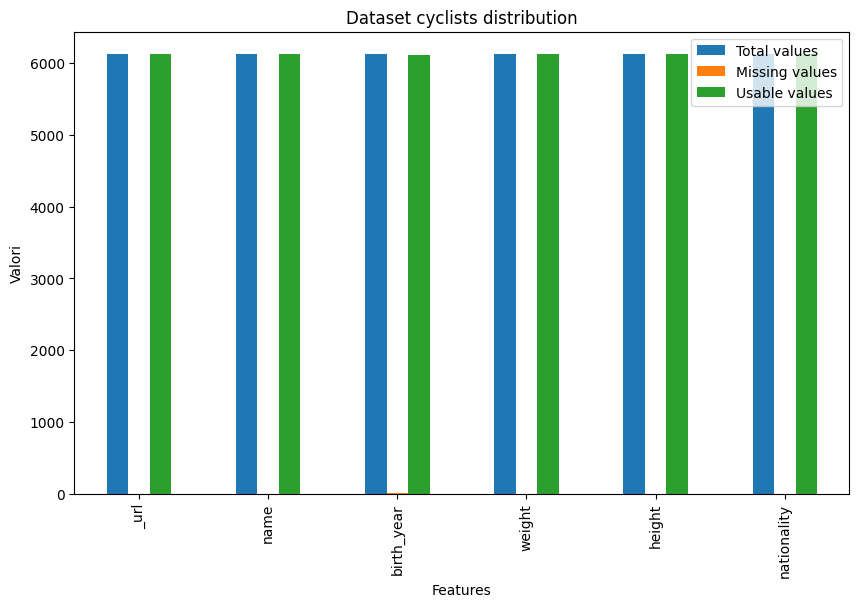

In [42]:
PlotMissingUsableData(DatasetCyclists, "cyclists")

## Dataset race

### Delete average_temperature feature

Si toglie la tabella "average_temperature", è irrilevante e non ha nessuna correlazione con altre tabelle.

In [43]:
#Tolgo la feautres average_temperature
del DatasetRace["average_temperature"]

### Fill data of climb_total and profile columns (Oleskiy)

#### Introduction

* Our approach to filling the `nan` data involved comparing three possible methods. The first was to implement an algorithm that runs multiple regressors, both linear and non-linear, and selects the best one based on specified metrics. 

* The second was to cluster the the races based on features most correlated with the predicted column, fit multiple probability distribution  (e.g., `stats.gamma`. `stats.lognorm`), and select the optimal one based on  `kstest` + `momemtum_score` + `density_score` overall metric. 
  
* The third and final method was to fit a `KNNImputer`. 

To predicte the  `climb_total`, `profile` was used the first approach, since it it the most flexible, since it gave different best regressor, based on `RMSE` metric.

What follows is the code of the three methods. But before, we need to preper the dataframe.

#### Preparation code

Plot functions

In [3]:
def errors_visualization(y_true, y_pred, feature_to_predict):
    # Create figure with more height to accommodate labels
    fi = plt.figure(figsize=(30, 15))  # Increased height from 10 to 15
    
    # Create GridSpec with more space between plots
    gs = plt.GridSpec(3, 2, figure=fi, hspace=0.4)  # Added hspace parameter for vertical spacing
    
    ax1 = fi.add_subplot(gs[0, 0])
    seaborn.kdeplot(data=y_true, label='Actual', ax=ax1)
    seaborn.kdeplot(data=y_pred, label='Predicted', ax=ax1)
    ax1.set_title('Distribution of Actual vs Predicted Climb Total', pad=20)  # Added padding to title
    ax1.set_xlabel('Climb Total (meters)', labelpad=10)  # Added padding to xlabel
    ax1.set_ylabel('Density', labelpad=10)  # Added padding to ylabel
    ax1.legend()
    
    # 2. Scatter Plot with Perfect Prediction Line
    ax2 = fi.add_subplot(gs[0, 1])
    ax2.scatter(y_true, y_pred, alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    
    ax2.set_title(f'Actual vs Predicted {feature_to_predict.title()}', pad=20)
    ax2.set_xlabel(f'Actual {feature_to_predict.title()}', labelpad=10)
    ax2.set_ylabel(f'Predicted {feature_to_predict.title()}', labelpad=10)
    ax2.legend()

    ax3 = fi.add_subplot(gs[1, 0])
    error = y_pred - y_true
    seaborn.histplot(data=error, bins=50, ax=ax3)
    ax3.axvline(x=0, color='r', linestyle='--', label='Zero Error')
    ax3.set_title('Distribution of Prediction Errors', pad=20)
    ax3.set_xlabel('Prediction Error', labelpad=10)
    ax3.set_ylabel('Count', labelpad=10)
    ax3.legend()

    # 9. Q-Q Plot of Prediction Errors
    ax4 = fi.add_subplot(gs[1, 1])
    stats.probplot(error, dist="norm", plot=ax4)
    ax4.set_title('Q-Q Plot of Prediction Errors', pad=20)
    
    # 10. Error vs Actual Value
    ax5 = fi.add_subplot(gs[2, 0])
    ax5.scatter(y_true, error, alpha=0.5)
    ax5.axhline(y=0, color='r', linestyle='--', label='Zero Error')
    ax5.set_title(f'Prediction Error vs Actual {{feature_to_predict.title()}}', pad=20)
    ax5.set_xlabel(f'Actual {feature_to_predict.title()}', labelpad=10)
    ax5.set_ylabel('Prediction Error ', labelpad=10)
    ax5.legend()
    
    # Adjust layout with extra padding


def create_prediction_visualizations(df, y_true, summary_stats, feature_name, save_path=None):
    """
    Create comprehensive visualizations for the prediction results
    Parameters:
    
    df (pd.DataFrame): DataFrame containing predictions and actual values
    summary_stats (dict): Dictionary containing summary statistics
    save_path (str, optional): Path to save the plots. If None, plots are displayed
    
    Returns:
    None
    """
    # Set up the style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(14, 10))
    gs = plt.GridSpec(2, 2, figure=fig)
    
    y_pred = df.loc[y_true.index, f'{feature_name}_predicted']

    print(f"Length true data: {len(y_true)}")
    print(f"Length predicted data: {len(y_pred)}")

    print(f"Mean true data: {y_true.mean()}")
    print(f"Mean predicted data: {y_pred.mean()}")
    
    print(f"STD of true data: {y_true.std()}")
    print(f"STD of predicted data: {y_pred.std()}")

    errors_visualization(y_true, y_pred, feature_to_predict=feature_name)
    
    
    ax1 = fig.add_subplot(gs[0, 0])
    # 1. Distribution Usage Pie Chart
    dist_usage = pd.Series(summary_stats['distribution_usage'])
    ax1.pie(dist_usage.values, labels=dist_usage.index, autopct='%1.1f%%')
    ax1.set_title('Distribution Types Used in Predictions')
    
    # 2. Feature Importance Plot
    ax2 = fig.add_subplot(gs[0, 1])
    feature_importance = pd.Series(summary_stats['feature_importance'])
    feature_importance.sort_values().plot(kind='barh', ax=ax2)
    ax2.set_title('Feature Importance in Prediction')
    ax2.set_xlabel('Absolute Correlation with Climb Total')
        
    
    # 5. Segment Performance
    ax3 = fig.add_subplot(gs[1, 0])
    segment_performance = df.loc[y_true.index].groupby('segment', observed=True).apply(
        lambda x: np.mean(x[f'{feature_name}_predicted'] - x[feature_name].fillna(0)), include_groups = False
    ).sort_values()
    segment_performance.head(20).plot(kind='barh', ax=ax3)
    ax3.set_title('Top 20 Best Performing Segments')
    ax3.set_xlabel('Mean Absolute Error (meters)')
    
    
    
    # Adjust layout and display/save
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

def create_segment_analysis(df, feature_name, save_path=None):
    """
    Create detailed visualizations for segment analysis
    
    Parameters:
    df (pd.DataFrame): DataFrame containing predictions and segment information
    save_path (str, optional): Path to save the plots. If None, plots are displayed
    
    Returns:
    None{'type': 'numeric'}
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(2, 2, figure=fig)
    
    
    # 1. Segment Size Distribution
    ax1 = fig.add_subplot(gs[0, 0])
    segment_sizes = df.groupby('segment', observed=True).size().sort_values(ascending=False)
    segment_sizes.head(20).plot(kind='bar', ax=ax1)
    ax1.set_title('Top 20 Largest Segments')
    ax1.set_xlabel('Segment')
    ax1.set_ylabel('Number of Races')
    plt.xticks(rotation=45)
    
    # 2. Segment Confidence Distribution
    ax2 = fig.add_subplot(gs[0, 1])
    segment_confidence = df.groupby('segment', observed=True)['prediction_confidence'].mean().sort_values(ascending=False)
    segment_confidence.head(20).plot(kind='bar', ax=ax2)
    ax2.set_title('Top 20 Segments by Confidence')
    ax2.set_xlabel('Segment')
    ax2.set_ylabel('Mean Confidence Score')
    plt.xticks(rotation=45)
    
    # 3. Distribution Type by Segment Size
    ax3 = fig.add_subplot(gs[1, 0])
    dist_by_size = df.groupby(['distribution_used', pd.qcut(segment_sizes, q=5)], observed=True)['segment'].count().unstack()
    if dist_by_size.isna().any().any():
        dist_by_size.plot(kind='bar', stacked=True, ax=ax3)
        ax3.set_title('Distribution Types by Segment Size Quintile')
        ax3.set_xlabel('Distribution Type')
        ax3.set_ylabel('Number of Segments')
        plt.xticks(rotation=45)
    
    # 4. Prediction Range by Segment
    ax4 = fig.add_subplot(gs[1, 1])
    segment_ranges = df.groupby('segment', observed=True).agg({
        f'{feature_name}_predicted': ['mean', 'std']
    }).sort_values((f'{feature_name}_predicted', 'mean'), ascending=False)
    
    segment_ranges.head(20)[(f'{feature_name}_predicted', 'mean')].plot(
        kind='bar', 
        yerr=segment_ranges.head(20)[(f'{feature_name}_predicted', 'std')],
        ax=ax4
    )
    ax4.set_title('Top 20 Segments by Mean Predicted Climb')
    ax4.set_xlabel('Segment')
    ax4.set_ylabel('Mean Predicted Climb Total (meters)')
    plt.xticks(rotation=45)
    

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

#### Relevant features picking

In [4]:
def engineering_features_t1(df) -> tuple[pd.DataFrame, dict]:
    
    engineered_features = {
        'points_per_km': {
            'type': 'numeric',
            'agg': pd.Series.mean
        },
        'season_score': {
            'type': 'numeric',
            'agg': pd.Series.mean
        },
        'season': {
            'type': 'categorical',
            'agg': pd.Series.mode
        },
        'team_presents': {
            'type': 'numeric',
            'agg': pd.Series.sum
        },
        'adjusted_delta': {
            'type': 'numeric',
            'agg': pd.Series.mean
        },
    }
            
    # Process date features
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear

    # Calculate derived features
    df['points_per_km'] = (df['points'] / df['length']* 0.001).fillna(0)


    # Create seasonal feature
    df['season_score'] = np.sin(2 * np.pi * df['day_of_year'] / 365)

    temp = df['month'].apply(lambda x: 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'fall' if x in [9, 10, 11] else 'winter')
    label_enc = LabelEncoder().fit_transform(temp.to_numpy())
    df['season'] = pd.Series(label_enc, index=df.index)
    df['team_presents'] = df['cyclist_team'].notnull().astype(int)
    df['startlist_score_per_km'] = df['startlist_quality'] / df['length']

    df['adjusted_delta'] = df['delta'] / df['length']

    return df, engineered_features


In [5]:
mean_imputer = SimpleImputer(strategy='mean')
median_imputer = SimpleImputer(strategy='median')
most_frequent_imputer = SimpleImputer(strategy='most_frequent')
knn_imputer = KNNImputer(n_neighbors=5)
scaler = StandardScaler()


iterative_imputer = IterativeImputer(max_iter=40, estimator=RandomForestRegressor())

def preprocess_helper_imputer(races, pred_features ):
    missing_features = [feature for feature in pred_features if feature not in races.columns]

    if len(missing_features) > 0:
        raise ValueError(f"Missing features in the dataset: {missing_features}")


    for feature, info in pred_features.items():
        if info['type'] == 'boolean':
            feature_data = races[feature].astype(float).to_numpy().reshape(-1, 1)
            imputed_data = iterative_imputer.fit_transform(feature_data)
            races[feature] = pd.Series(imputed_data.flatten(), index=races[feature].index)
        
        elif info['type'] == 'numeric' and not feature == "points":
            feature_data = races[feature].to_numpy().reshape(-1, 1)

            non_nan_data = races[feature].dropna()
            if len(non_nan_data) > 0:
                skewness = non_nan_data.skew()
                if abs(skewness) > 1:
                    imputed_data = median_imputer.fit_transform(feature_data)
                else:
                    imputed_data = mean_imputer.fit_transform(feature_data)
            else:
                imputed_data = median_imputer.fit_transform(feature_data)
            
            races[feature] = pd.Series(imputed_data.flatten(), index=races[feature].index)
        elif info['type'] == 'numeric' and feature == "points":
            # get the median for each cyclist
            res = races.groupby("cyclist").agg({feature: 'mean'})
            races_feat_nan = races[races[feature].isna()]
            races.loc[races_feat_nan.index, feature] = races[['cyclist', feature]].loc[races_feat_nan.index].apply(lambda x: res.loc[x['cyclist'], feature], axis=1)
            
        elif info['type'] == 'categorical':
            feature_data = pd.Categorical(races[feature]).to_numpy().reshape(-1, 1)
            imputed_data = LabelEncoder().fit_transform(feature_data.ravel())
            imputed_data = iterative_imputer.fit_transform(imputed_data.reshape(-1, 1))
            races[feature] = pd.Series(imputed_data.flatten(), index=races[feature].index)


def preprocess_helper_scaler(races, pred_features):
    for feature, info in pred_features.items():
        if info['type'] == 'numeric':
            scaled_data = scaler.fit_transform(races[feature].to_numpy().reshape(-1, 1))
            races[feature] = pd.Series(scaled_data.flatten(), index=races[feature].index)











# Define features with their properties and aggregation methods
normal_features = {
    'length': {
        'type': 'numeric',
        'agg': pd.Series.mean
    },
    'points': {
        'type': 'numeric',
        'agg': pd.Series.mean
    },
    'startlist_quality': {
        'type': 'numeric',
        'agg': pd.Series.mean
    },
    'is_tarmac': {
        'type': 'boolean',
        'agg': 'first'
    },
    'profile': {
        'type': 'categorical',
        'agg': pd.Series.mode
    },
    'position': {
        'type': 'numeric',
        'agg': pd.Series.mean
    },
    'cyclist_age': {
        'type': 'numeric',
        'agg': pd.Series.median
    }
    
}

DatasetRace_temp = DatasetRace[list(normal_features.keys()) + ['climb_total', 'date', 'cyclist', 'cyclist_team', 'delta', '_url']].copy()


preprocess_helper_imputer(DatasetRace_temp, normal_features)
_, engineered_features = engineering_features_t1(DatasetRace_temp)


FEATURES = {**normal_features, **engineered_features}
preprocess_helper_scaler(DatasetRace_temp, FEATURES)


# Generate pred_features dictionary
pred_features = {name: {'type': props['type']} for name, props in FEATURES.items()}

# Generate aggregation dictionary
agg_dict = {name: props['agg'] for name, props in FEATURES.items()}
agg_dict['climb_total'] = pd.Series.mean
agg_dict['date'] = 'first'

# Perform groupby with generated aggregation dictionary
GroupedRaces = DatasetRace_temp.groupby(["_url"]).agg(agg_dict)

GroupedRaces.sample(frac=0.4).head(5)

length    points  startlist_quality  \
_url                                                                    
volta-a-catalunya/2007/stage-4  0.562763 -0.720915          -0.749268   
vuelta-a-espana/1986/stage-21  -2.243008 -0.169602          -0.678324   
giro-d-italia/1992/stage-9      0.576706 -0.169602          -0.389297   
la-fleche-wallone/1988/result   1.180931  2.495077          -1.232732   
giro-d-italia/2003/stage-2      0.158397 -0.169602          -0.964724   

                                is_tarmac  profile  position  cyclist_age  \
_url                                                                        
volta-a-catalunya/2007/stage-4        1.0      4.0  0.336346    -0.385501   
vuelta-a-espana/1986/stage-21         1.0      5.0 -1.440367    -0.255808   
giro-d-italia/1992/stage-9            1.0      5.0 -1.440367     0.003578   
la-fleche-wallone/1988/result         0.0      5.0 -0.830913    -0.644887   
giro-d-italia/2003/stage-2            1.0      1.0  0.191730    -0.126115   

                                points_per_km  season_score  season  \
_url                                                                  
volta-a-catalunya/2007/stage-4      -0.323310      0.620823       1   
vuelta-a-espana/1986/stage-21        0.938738      0.821953       1   
giro-d-italia/1992/stage-9          -0.268970      0.409821       2   
la-fleche-wallone/1988/result       -0.070266      1.148933       1   
giro-d-italia/2003/stage-2          -0.246700      0.854480       1   

                                team_presents  adjusted_delta  climb_total  \
_url                                                                         
volta-a-catalunya/2007/stage-4      -6.514623        0.096572          NaN   
vuelta-a-espana/1986/stage-21        6.078954       -0.162297          NaN   
giro-d-italia/1992/stage-9           3.826039       -0.325423          NaN   
la-fleche-wallone/1988/result      -45.918908       -0.144194          NaN   
giro-d-italia/2003/stage-2         -93.877191       -0.200006       1057.0   

                                              date  
_url                                                
volta-a-catalunya/2007/stage-4 2007-05-24 06:06:43  
vuelta-a-espana/1986/stage-21  1986-05-13 00:25:43  
giro-d-italia/1992/stage-9     1992-06-02 05:49:46  
la-fleche-wallone/1988/result  1988-04-13 06:32:21  
giro-d-italia/2003/stage-2     2003-05-11 04:46:57

#### Regressors comparing algorithm

This code compares and evaluates multiple machine learning regression models (including Random Forest, XGBoost, Linear Regression, etc.) for predicting a specific feature. It:

- Takes a dataset and trains multiple regression models
- Evaluates each model using metrics (RMSE, R², cross-validation)
- Creates visualizations comparing model performance
- Generates residual plots for the best performing model
- Returns the trained models, performance summary, and predictions for missing values

It's essentially a model evaluation and selection pipeline that helps identify the best regression model for a specific prediction task.

In [6]:
def compare_regressors(races_agg, feature_to_pred, features, print_metrics=False):
    warnings.filterwarnings('ignore')
    """
    Compare different algorithms for predicting ```feature_to_pred``` values.
    
    Parameters:
    races_agg (pd.DataFrame): Input DataFrame
    features (list): List of feature columns to use
    
    Returns:
    dict: Dictionary containing trained models and their performance metrics
    """
    # Prepare data
    known_mask = ~races_agg[feature_to_pred].isna()
    train_data = races_agg[known_mask]
    predict_data = races_agg[~known_mask]
    
    X = train_data[features.keys()].copy()
    X_to_pred = predict_data[features.keys()].copy()
    y = train_data[feature_to_pred]

    for feature, info in features.items():
        if feature not in X.columns:
            raise ValueError(f"Feature '{feature}' not found in DataFrame")
        
        if info['type'] not in ['numeric', 'categorical', 'boolean']:
            raise ValueError(f"Unknown feature type: {info['type']}")

        
    
   
    
    # Handle missing values
    
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2
    )
    
    
    

    models = {
        'Random Forest': RandomForestRegressor(n_jobs=real_cpu_count, n_estimators=600, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=15),
        'Gradient Boosting': GradientBoostingRegressor(subsample=0.8, n_estimators=100, min_samples_split=15, max_depth=5, learning_rate=0.05),
        'XGBoost': XGBRegressor(subsample=0.9, n_estimators=200, min_child_weight=8, max_depth=5, learning_rate=0.04, colsample_bytree=1.0),
        'Huber': HuberRegressor(max_iter = 700, epsilon = 1.5, alpha = 0.01),
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha = 2.0),
        'Lasso': Lasso(alpha= 2.0),
        'KNeighborsRegressor': KNeighborsRegressor(weights = 'distance', n_neighbors = 5, algorithm = 'ball_tree'),
        'HistGradientBoostingRegressor': HistGradientBoostingRegressor(max_iter=80, max_depth=7, learning_rate=0.07, l2_regularization=0.05),
        'VotingRegressor': VotingRegressor(estimators=[
            ('rf', RandomForestRegressor(n_jobs=real_cpu_count, n_estimators=600, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=15)),
            ('gb', GradientBoostingRegressor(subsample=0.8, n_estimators=100, min_samples_split=15, max_depth=5, learning_rate=0.05)),
            ('xgb', XGBRegressor(subsample=0.9, n_estimators=200, min_child_weight=8, max_depth=5, learning_rate=0.04, colsample_bytree=1.0)),
            ('hgbr', HistGradientBoostingRegressor(max_iter=80, max_depth=7, learning_rate=0.07, l2_regularization=0.05))
        ], weights=[1, 1, 1, 1])
    }
    
    # Dictionary to store results
    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)

        
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        rmse = np.sqrt(mse(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # Perform cross-validation
        cv_scores = cross_val_score(
            model, X, y, 
            cv=5, scoring='neg_root_mean_squared_error'
        )
        
        results[name] = {
            'model': model,
            'rmse': rmse,
            'r2': r2,
            'cv_rmse': -cv_scores.mean(),
            'cv_rmse_std': cv_scores.std(),
            'predictions': y_pred
        }
        if print_metrics:
            print(f"{name} Results:")
            print(f"RMSE: {rmse:.2f} meters")
            print(f"R²: {r2:.3f}")
            print(f"CV RMSE: {-cv_scores.mean():.2f} ± {cv_scores.std():.2f} meters")
    
    # Visualize results
    fig = plt.figure(figsize=(15, 10))
    gs = plt.GridSpec(2, 2, figure=fig, hspace=0.4, wspace=0.3)
    
    # Plot RMSE comparison
    rmse_scores = [(name, results[name]['rmse']) for name in results.keys()]
    rmse_scores.sort(key=lambda x: x[1])
    
    names, scores = zip(*rmse_scores)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.barh(names, scores)
    ax1.set_xlabel('RMSE (meters)')
    ax1.set_title('Model Comparison - RMSE (lower is better)')
    
    # Plot R² comparison
    r2_scores = [(name, results[name]['r2']) for name in results.keys()]
    r2_scores.sort(key=lambda x: x[1], reverse=True)
    
    names, scores = zip(*r2_scores)
    ax2 = fig.add_subplot(gs[0, 1])

    plt.barh(names, scores)
    ax2.set_xlabel('R² Score (higher is better)')
    ax2.set_title('Model Comparison - R² Score')
    
    # Plot residuals for best model
    best_model_name = min(results.keys(), key=lambda k: results[k]['rmse'])
    best_predictions = results[best_model_name]['predictions']
    
    ax3 = fig.add_subplot(gs[1, :])
    residuals = y_test - best_predictions
    ax3.scatter(best_predictions, residuals, alpha=0.5)
    ax3.axhline(y=0, color='r', linestyle='--')
    ax3.set_xlabel('Predicted Values')
    ax3.set_ylabel('Residuals')
    ax3.set_title(f'Residuals Plot - {best_model_name}')
    
    plt.show()
    plt.close(fig=fig)
    
    # Create summary DataFrame
    summary = pd.DataFrame({
        'RMSE': [results[name]['rmse'] for name in results.keys()],
        'R²': [results[name]['r2'] for name in results.keys()],
        'CV RMSE': [results[name]['cv_rmse'] for name in results.keys()],
        'CV RMSE Std': [results[name]['cv_rmse_std'] for name in results.keys()]
    }, index=results.keys())
    
    print("\nSummary of all models:")
    print(summary.sort_values('RMSE'))

    feature_predictions = pd.Series(results[best_model_name]['model'].predict(X_to_pred), index=predict_data.index)

    print("Visualizations for the best model:")
    errors_visualization(y_test, best_predictions, feature_to_pred)

    warnings.filterwarnings('default')
    return  results, summary, feature_predictions


#### Executing on `climb_total`


Training Random Forest...

Training Gradient Boosting...

Training XGBoost...

Training Huber...

Training Linear Regression...

Training Ridge...

Training Lasso...

Training KNeighborsRegressor...

Training HistGradientBoostingRegressor...

Training VotingRegressor...


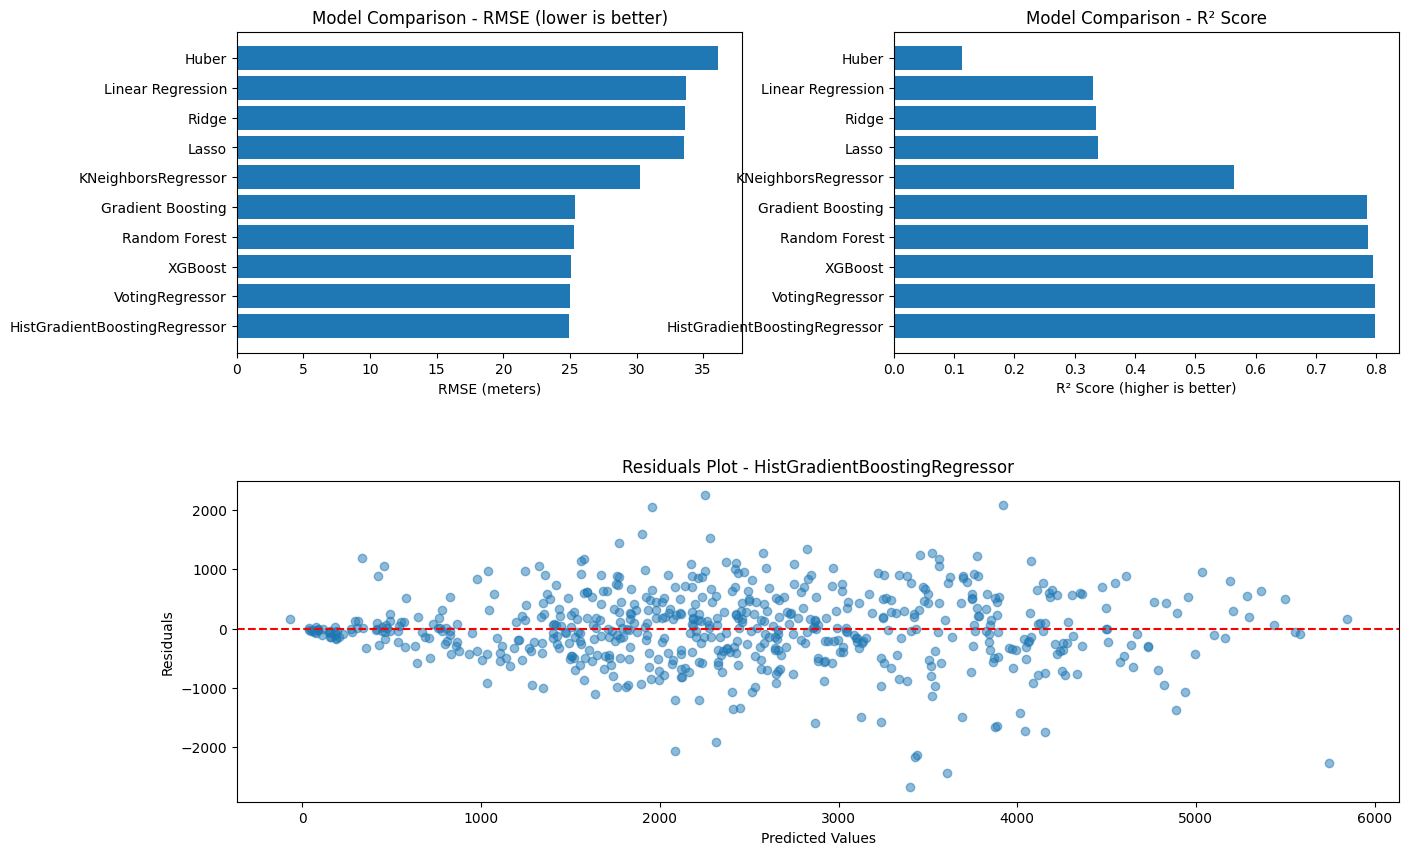


Summary of all models:
                                    RMSE        R²      CV RMSE  CV RMSE Std
HistGradientBoostingRegressor  24.948432  0.798526   688.468086    58.499136
VotingRegressor                24.988057  0.797243   690.761227    66.023586
XGBoost                        25.087767  0.793988   703.312368    78.119239
Random Forest                  25.289667  0.787276   711.074522    68.164911
Gradient Boosting              25.374325  0.784413   699.895971    64.332117
KNeighborsRegressor            30.250656  0.564504  1057.244932   106.495105
Lasso                          33.574325  0.339194  1085.285330   153.283060
Ridge                          33.623359  0.335325  1084.263646   158.779847
Linear Regression              33.679960  0.330838  1086.064386   161.485321
Huber                          36.130753  0.113757  1058.067761   188.909595
Visualizations for the best model:


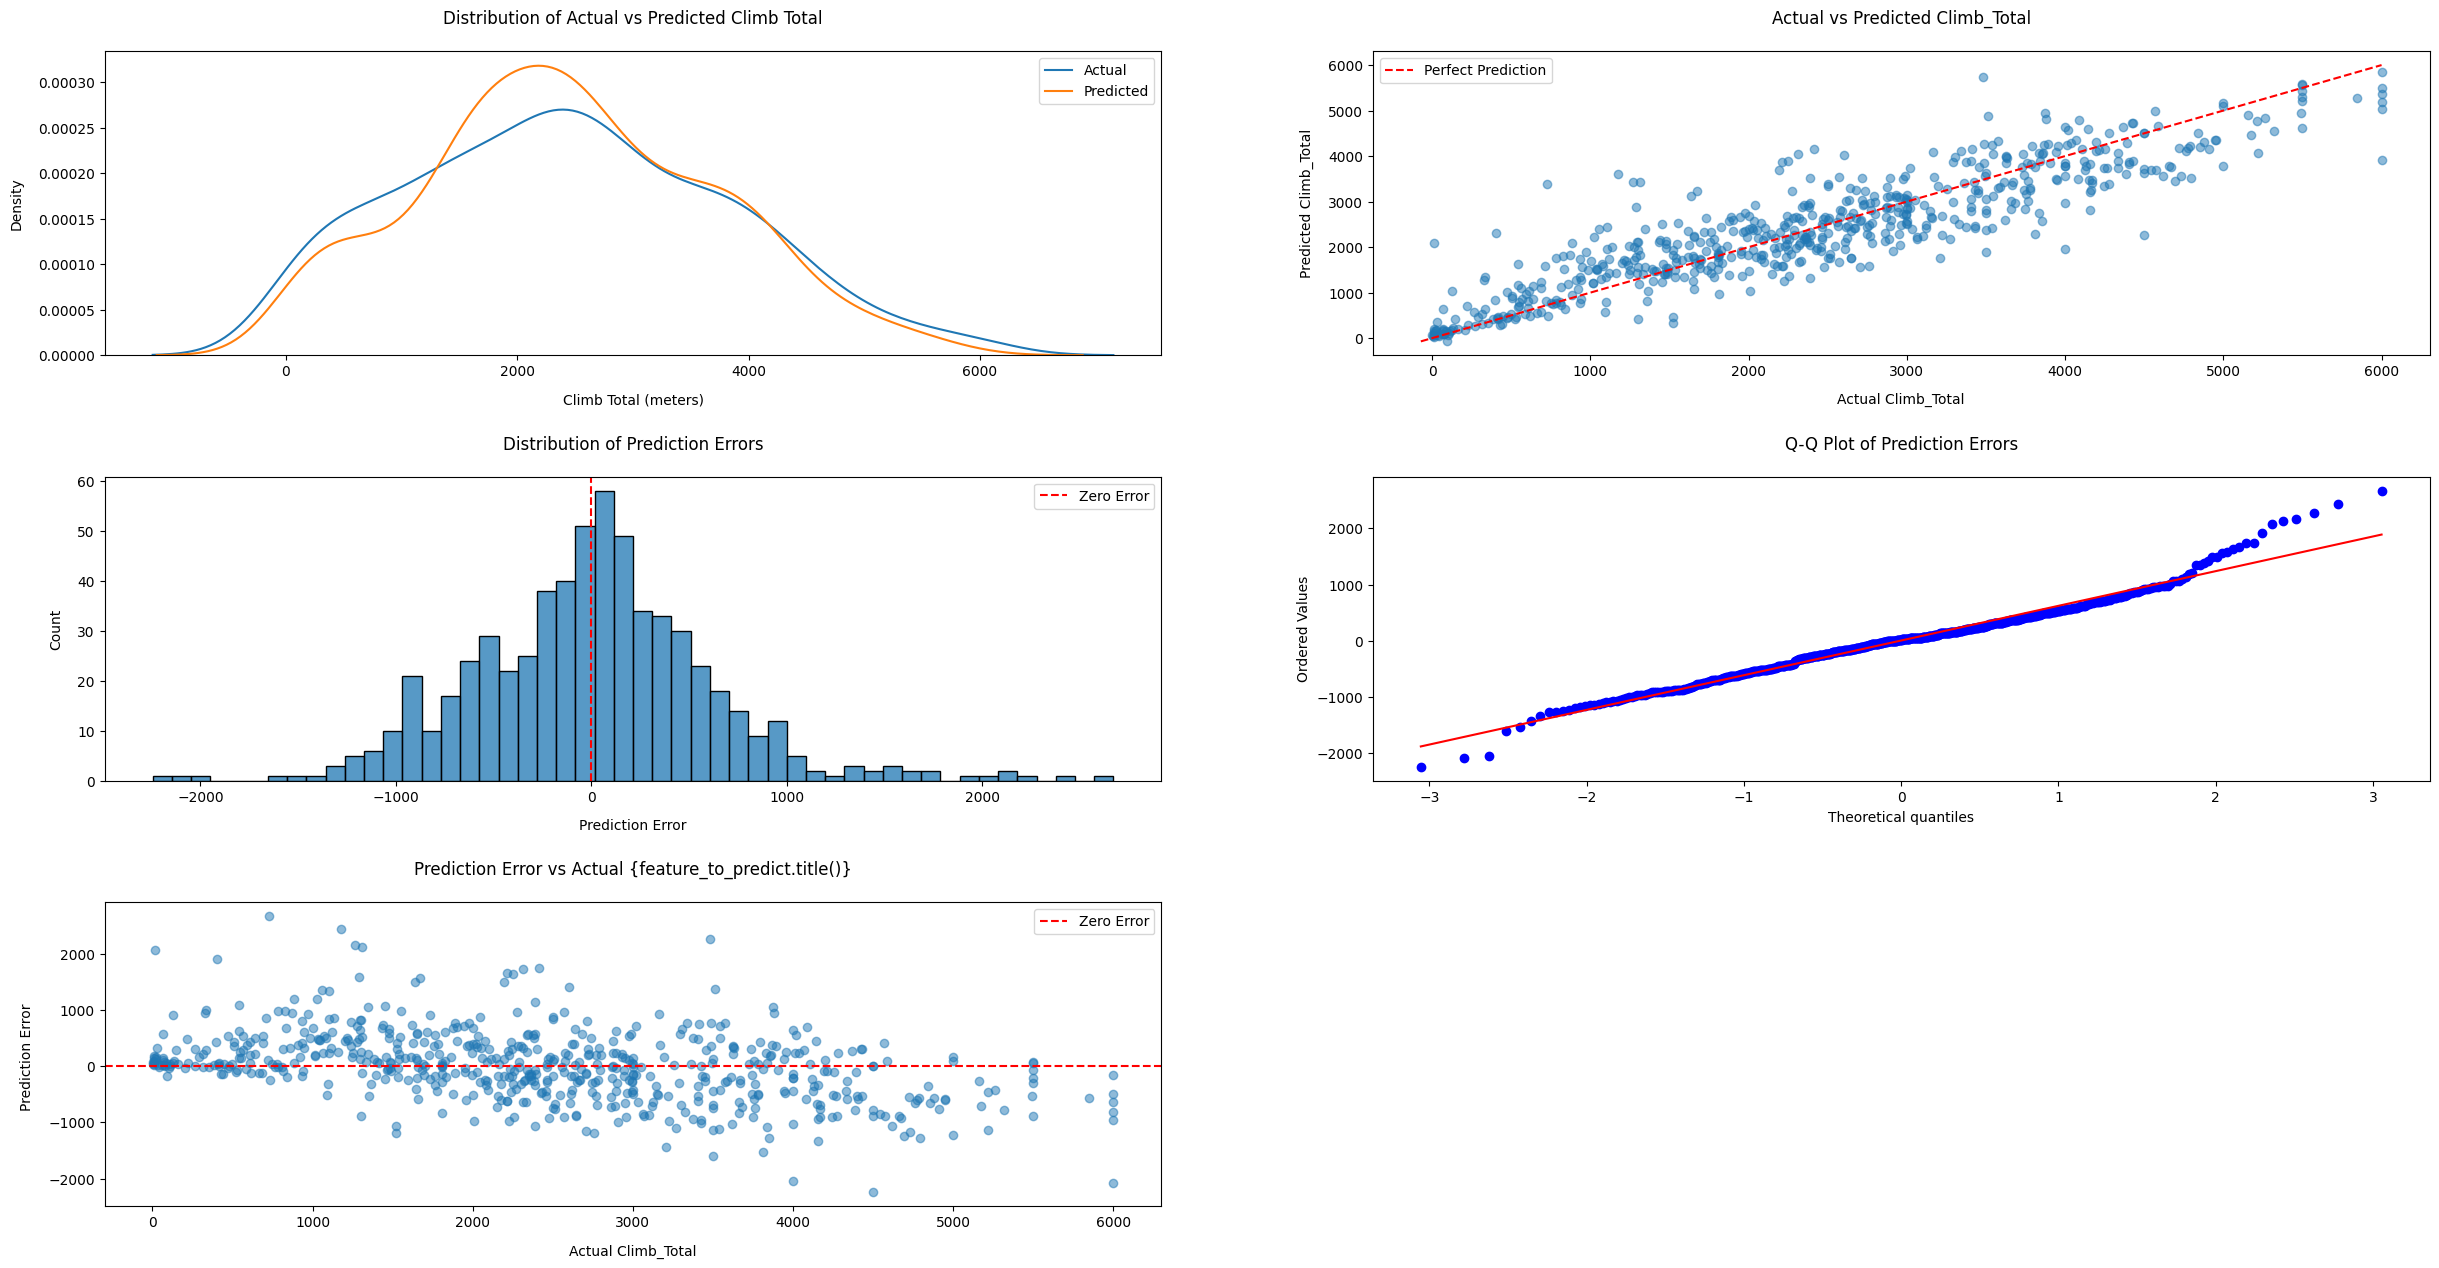

In [7]:
results, summary, climb_total_pred = compare_regressors(GroupedRaces, "climb_total", features=pred_features)


#### Density based approach

Segments data into clusters based on similar features
Fits statistical distributions to each segment
Predicts missing values using the best-fitting distributions
Provides confidence scores for predictions

Filled-in missing values for a specified feature
Prediction confidence scores
Performance metrics (RMSE, R², MAE)
Distribution fit information for each segment
Visualization of the clusters (optional)


In [18]:
tqdm.pandas()  # Enable progress_apply


def add_jitter(data, epsilon=1e-9):
    return data + np.random.normal(0, epsilon, len(data))

def fit_best_distribution(data):
    """
    Try multiple distributions and return the best fitting one
    
    Parameters:
    data (array-like): Data to fit distributions to
    
    Returns:
    tuple: (distribution name, distribution parameters, fit score)
    """
    orig_mean = data.mean()
    orig_std = data.std()
    orig_skew = 0
    orig_kurtosis = 0
    kde = None
    if orig_std > 1e-4:
        orig_skew = stats.skew(add_jitter(data))
        orig_kurtosis = stats.kurtosis(data)
        kde = stats.gaussian_kde(data)
    
        


    distributions = [
        ('gamma', stats.gamma),
        ('lognorm', stats.lognorm),
        ('weibull_min', stats.weibull_min),
        ('beta', stats.beta),
        ('burr', stats.burr),
        ('burr12', stats.burr12),
        ('gaussian_mix', lambda x: stats.norm(loc=orig_mean, scale=orig_std))
    ]
    
    best_fit = None
    best_score = float('inf')
    
    if len(data) < 20 or data.std() == 0:
        return None
    
    
    
    for name, distribution in distributions:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                if name == 'beta':
                    data_normalized = (data - data.min()) / (data.max() - data.min())
                    data_normalized = np.clip(data_normalized, 1e-6, 1 - 1e-6)
                    params = distribution.fit(data_normalized)
                    ks_stat, _ = kstest(data_normalized, name, params)
                    samples = distribution.rvs(*params, size=1000)
                    samples = samples * (data.max() - data.min()) + data.min() 
                else:
                    params = distribution.fit(data)
                    ks_stat, _ = kstest(data, name, params)
                    samples = distribution.rvs(*params, size=1000)

                
                moment_score = (
                    abs(orig_mean - np.mean(samples)) / orig_std +
                    abs(orig_std - np.std(samples)) / orig_std +
                    abs(orig_skew - stats.skew(samples)) +
                    abs(orig_kurtosis - stats.kurtosis(samples))
                )

                weight_ks = 1.1  # KS statistic weight
                weight_moment = 0.8  # Moment score weight
                weight_density = 0.5  # Density score weight

                density_score = 0
                if kde is not None:
                    x_eval = np.linspace(data.min(), data.max(), len(data))
                    kde_orig =  kde(x_eval)
                    kde_fitted = stats.gaussian_kde(samples)(x_eval)
                    density_score = np.mean(np.abs(kde_orig - kde_fitted))


                total_score = (weight_ks * ks_stat) + (weight_moment * moment_score) + (weight_density * density_score)
                
                if total_score < best_score:
                    best_fit = (name, params, total_score)
                    best_score = ks_stat
                    
        except Exception as e:
            continue
    
    return best_fit



def find_optimal_clusters(data, max_k, fig, gs):
    inertia = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    
    # Plot inertia vs. number of clusters
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(range(1, max_k + 1), inertia, marker='o')
    ax1.set_title('Elbow Method For Optimal k')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Inertia (Sum of squared distances)')

def silhouette_method(data, max_k, fig, gs):
    silhouette_scores = []
    for k in range(2, max_k + 1):  # Silhouette requires at least 2 clusters
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
    
    # Plot silhouette score vs. number of clusters
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(range(2, max_k + 1), silhouette_scores, marker='o')
    ax2.set_title('Silhouette Method For Optimal k')
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('Silhouette Score')


def parallel_process_segments(segments, df, feature_to_predict, segmentation_features):
    segment_distributions = {}
    distribution_info = {}

    for segment in tqdm(segments, desc="Fitting distributions", total=len(segments)):
        segment_data = df[df['segment'] == segment][feature_to_predict].dropna()
        if len(segment_data) > 20:
            best_fit = fit_best_distribution(segment_data)

            if best_fit is not None:
                dist_name, params, ks_score = best_fit
                segment_distributions[segment] = {
                    "distribution": (dist_name, params),
                    "data": df[df['segment'] == segment][feature_to_predict],
                }
                distribution_info[segment] = {
                    'distribution': dist_name,
                    'ks_score': ks_score,
                    'sample_size': len(segment_data),
                    'feature_means': {
                        feature: df[df['segment'] == segment][feature].mean()
                        for feature in segmentation_features if feature in df.columns and pd.api.types.is_numeric_dtype(df[feature])
                    }
                }
            else:
                segment_distributions[f"{segment}_none"] = df[df['segment'] == segment][segmentation_features.keys()].to_numpy().reshape(-1, len(segmentation_features))
                distribution_info[segment] = {
                    'distribution': 'none',
                    'ks_score': 1.0,
                    'sample_size': len(segment_data),
                    'feature_means': {
                        feature: df[df['segment'] == segment][feature].mean()
                        for feature in segmentation_features if feature in df.columns and pd.api.types.is_numeric_dtype(df[feature])
                    }
                }
        else:
            segment_distributions[f"{segment}_none"] = df[df['segment'] == segment][segmentation_features.keys()].to_numpy().reshape(-1, len(segmentation_features))

    return {"segments_dist": segment_distributions, "distribution_info": distribution_info}

def predict_feat(row,  kwargs):
    
    data_mean = kwargs.get('data_mean')
    data_std = kwargs.get('data_std')
    segment_distributions = kwargs.get('segment_distributions')
    distribution_info = kwargs.get('distribution_info')
    segmentation_features = kwargs.get('segmentation_features')
    feature_to_predict = kwargs.get('feature_to_predict')


    min_valid = max(0, data_mean - 4 * data_std)
    max_valid = data_mean + 4 * data_std
    if pd.isna(row[feature_to_predict]):
        segment = row['segment']


        if segment in segment_distributions:
            try:
                dist_name, params = segment_distributions[segment]['distribution']
                segment_data = segment_distributions[segment]['data']

                distribution = getattr(stats, dist_name)

                with np.errstate(all='ignore'):  # Suppress numpy warnings
                    if dist_name == 'beta':
                        segment_data_no_na = segment_data.dropna()

                        min_val, max_val = segment_data_no_na.min(), segment_data_no_na.max()
                        samples = distribution.rvs(*params, size=100)
                        prediction = np.median(samples) * (max_val - min_val) + min_val
                    else:
                        try:
                            samples = distribution.rvs(*params, size=100)
                            prediction = np.mean(samples)
                        except:
                            prediction = distribution.mean(*params)
                    if np.isnan(prediction) or np.isinf(prediction) or prediction < min_valid or prediction > max_valid:
                        if len(segment_data) > 0:
                            prediction = segment_data.mean() + np.random.normal(0, segment_data.std() * 0.005)
                        else:
                            prediction = data_mean + np.random.normal(0, data_std * 0.005)

                

                return np.clip(prediction, min_valid, max_valid)
            except:
                print(f"Error predicting segment {segment}")
                return data_mean + np.random.normal(0, data_std * 0.005)

       
        
        valid_segments = [s for s in segment_distributions.keys() 
                        if s in distribution_info]
        if not valid_segments:
            return data_mean + np.random.normal(0, data_std * 0.005)
        
        segment_means = np.array([
            [distribution_info[s]['feature_means'].get(f, 0) 
            for f in segmentation_features]
            for s in valid_segments
        ])

        segment_features = segment_distributions[f"{segment}_none"]
        similarities = cosine_similarity(segment_features, segment_means).flatten()
        
        top_segments = np.argsort(similarities)[-3:]  # Top 3 most similar segments
        
        predictions = []
        for idx in top_segments:
            idx = np.unravel_index(idx, (segment_features.shape[0], segment_means.shape[0]))[1]
            seg = valid_segments[idx]
            dist_name, params = segment_distributions[seg]['distribution']
            distribution = getattr(stats, dist_name)
            
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                pred = distribution.mean(*params)
                
            if not (np.isnan(pred) or np.isinf(pred)) and min_valid <= pred <= max_valid:
                predictions.append(pred)
        
        if predictions:
            return np.mean(predictions) + np.random.normal(0, data_std * 0.005)
    
    return row[feature_to_predict]

def predict_feat_in_chunks(rows, kwargs):
    results_series = pd.Series(dtype='float64')
    for idx, row in rows.iterrows():
        results_series.at[idx] = predict_feat(row, kwargs)
    
    return results_series
        
        

def predict_feature_density(df, segmentation_features, feature_to_predict, n_clusters_final=0, run_silhouette=True, plot_clusters=True):
    """
    Predict missing a specific feature nan values using data segmentation and multiple probability distributions
    
    Parameters:
    races_df (pd.DataFrame): The input races dataframe
    
    Returns:
    pd.DataFrame: DataFrame with predicted feature to predict values and fit information
    """
    
    with mp.Pool() as pool:

        missing_features = [k for k,v in segmentation_features.items() if k not in df.columns]
        

        if missing_features:
            raise ValueError(f"Features {missing_features} are missing in the input DataFrame")
            
        
        
        fig = plt.figure(figsize=(10, 6))
        gs = plt.GridSpec(2, 2, figure=fig, wspace=0.5, hspace=0.5)

        
        # 1. Feature preparation
        df['date'] = pd.to_datetime(df['date'])
        df['month'] = df['date'].dt.month
        
        print("\n Feature statistics before imputation:")
        for feature in segmentation_features:
            missing = df[feature].isna().sum()
            total = len(df[feature])
            print(f"{feature}: {missing} missing ({missing/total:.2%})")
        
        # 2. Create feature matrix for segmentation
        feature_matrix = df[segmentation_features.keys()].to_numpy()
        
        if np.isnan(feature_matrix).any():
            raise ValueError("NaN values found in feature matrix")
        
        # 3. Use K-means clustering for sophisticated segmentation
        n_clusters = min(20, (len(df) // 1000))+10  # Adaptive number of clusters
        find_optimal_clusters(feature_matrix, n_clusters, fig, gs)
        if run_silhouette:
            silhouette_method(feature_matrix, n_clusters, fig, gs)
        n_clusters = 8  # Chosen based on elbow and silhouette methods
        kmeans = KMeans(n_clusters=n_clusters_final | n_clusters, random_state=42)
        df['segment_cluster'] = kmeans.fit_predict(feature_matrix)
        
        if plot_clusters:
            # plot the clusters
            ax3 = fig.add_subplot(gs[1, 0])
            seaborn.scatterplot(x=feature_matrix[:, 0], y=feature_matrix[:, 1], hue=df['segment_cluster'], s=50, palette='viridis', ax=ax3)
            ax3.set_title('K-Means Clustering of Segmentation Features')
            ax3.set_xlabel('Feature 1')
            ax3.set_ylabel('Feature 2')
            ax3.legend(title='Cluster')
            

            centers = kmeans.cluster_centers_
            ax4 = fig.add_subplot(gs[1, 1])
            seaborn.scatterplot(x=centers[:, 0], y=centers[:, 1], s=100, color='red', marker='X', ax=ax4)
            ax4.set_title('Cluster Centers')
            

        
        plt.show()
        plt.close(fig)
        # 4. Create segments
        df['length_category'] = pd.qcut(df['length'], q=5, labels=['VS', 'S', 'M', 'L', 'VL'])
        df['road_type'] = np.where(df['is_tarmac'], 'T', 'M')
        df['season'] = pd.cut(df['month'], bins=[0, 4, 8, 12], labels=['Spring', 'Summer', 'Fall'])
        
        if 'startlist_quality' in df.columns:
            df['quality_level'] = np.where(
                df['startlist_quality'] > df['startlist_quality'].median(), 
                'High', 
                'Low'
            )
        else:
            df['quality_level'] = 'Medium'
        
        # Create segment ID efficiently
        df['segment'] = (df['length_category'].astype(str) + '_' + 
                        df['road_type'].astype(str) + '_' + 
                        df['season'].astype(str) + '_' + 
                        df['quality_level'].astype(str) + '_C' + 
                        df['segment_cluster'].astype(str))
        
        print(f"number of segments: {len(df['segment'].unique())}")
        # 5. Calculate distributions for each segment
        segment_distributions = {}
        distribution_info = {}        

        segments_each_process = np.array_split(df['segment'].unique(), int(real_cpu_count * 0.3))
        info=  pool.starmap(parallel_process_segments, [(segments, df, feature_to_predict, segmentation_features) for segments in segments_each_process], chunksize=2)
        for i in info:
            segment_distributions.update(i['segments_dist'])
            distribution_info.update(i['distribution_info'])
        # 6. Predict missing values
       
        df_chunks = np.array_split(df,  int(real_cpu_count * 0.25))
        print(f"number of chunks: {len(df) // len(df_chunks)}")

   
        # rows, df, feature_to_predict, segment_distributions, distribution_info, segmentation_features, feature_matrix

        # segment_idx = list(all_segments).index(segment)
        # segment_features = feature_matrix[segment_idx].reshape(1, -1)

        kwargs = {
            "feature_to_predict": feature_to_predict,
            "segment_distributions": segment_distributions,
            "distribution_info": distribution_info,
            "segmentation_features": segmentation_features,
            "feature_matrix": feature_matrix,
            "data_mean": df[feature_to_predict].mean(),
            "data_std": df[feature_to_predict].std(),
            "all_segments": df['segment'].unique()

        }
        
        df[f'{feature_to_predict}_predicted'] = pd.concat(
            pool.starmap(predict_feat_in_chunks, 
                         [(rows, kwargs) for rows in df_chunks], chunksize=2
            ))

        

        # 7. Calculate prediction confidence
        def calculate_confidence(row):
            segment = row['segment']
            if segment in distribution_info:
                info = distribution_info[segment]
                ks_confidence = 1 / (1 + info['ks_score'])
                sample_confidence = min(1, info['sample_size'] / 100)
                feature_similarity = np.mean([info['feature_means'].get(f, 0) for f in segmentation_features])
                return (ks_confidence + sample_confidence + feature_similarity) / 3
            return 0
        
        df['prediction_confidence'] = df.progress_apply(calculate_confidence, axis=1)
        # df['segment'].map(lambda x: print(x) if distribution_info.get(x, {}) == {} else None)
        df['distribution_used'] = df['segment'].map(lambda x: distribution_info.get(x, {}).get('distribution', 'none'))
        
        # 8. Create summary statistics
        summary_stats = {
            'total_missing': df[feature_to_predict].isna().sum(),
            'segments_created': len(df['segment'].unique()),
            'segments_with_distribution': len(segment_distributions),
            'distribution_usage': pd.Series([info['distribution'] for info in distribution_info.values()]).value_counts().to_dict(),
            'mean_confidence': df['prediction_confidence'].mean(),
            'median_predicted_climb': df[f'{feature_to_predict}_predicted'].median(),
            'features_used': segmentation_features,
            'feature_importance': {
                feature: abs(np.corrcoef(feature_matrix[:, i], 
                                    df[feature_to_predict].fillna(df[feature_to_predict].mean()))[0, 1])
                for i, feature in enumerate(segmentation_features)
            }
        }
        del feature_matrix
        return df[[feature_to_predict, f'{feature_to_predict}_predicted', 'prediction_confidence', 
              'segment', 'distribution_used']], summary_stats

    

def print_density_info(stats_races, predictions, y_test, feature_to_predict):

    print("\nMetrics:")
    mse_score = mse(y_test, predictions[f'{feature_to_predict}_predicted'].loc[y_test.index])
    r2 = r2_score(y_test, predictions[f'{feature_to_predict}_predicted'].loc[y_test.index])
    rmse = np.sqrt(mse_score)
    mae = np.mean(np.abs(y_test - predictions[f'{feature_to_predict}_predicted'].loc[y_test.index]))
    print(f"RMSE: {rmse:.2f} meters")
    print(f"R²: {r2:.3f}")
    print(f"MAE: {mae:.2f} meters")
    print(f"MSE: {mse_score:.2f}")


### Execute Segmentation and Density Approach

Now we will execute the above segmentation and density approach code to predict the missing values in the dataset.


/home/lesi-nedo/miniforge3/envs/DM/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning:

This process (pid=1665290) is multi-threaded, use of fork() may lead to deadlocks in the child.




 Feature statistics before imputation:
length: 0 missing (0.00%)
points: 0 missing (0.00%)
startlist_quality: 0 missing (0.00%)
is_tarmac: 0 missing (0.00%)
profile: 0 missing (0.00%)
position: 0 missing (0.00%)
cyclist_age: 0 missing (0.00%)


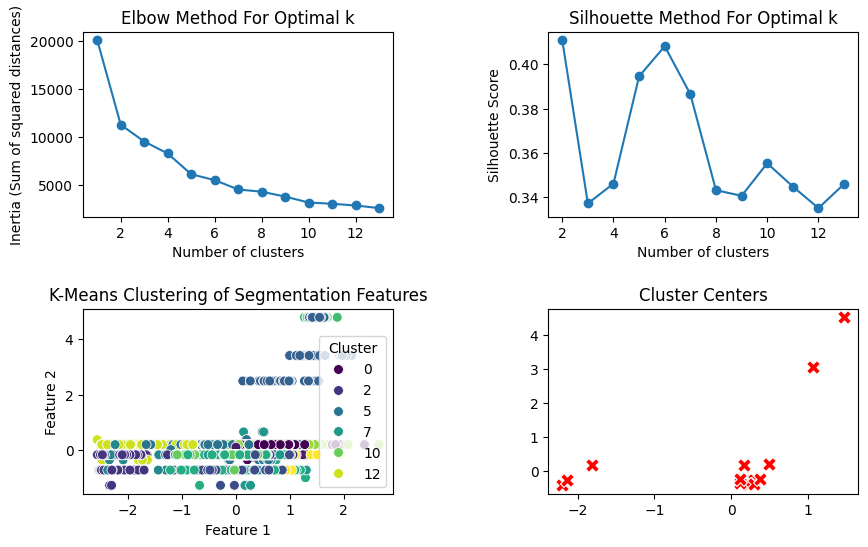

Fitting distributions:   0%|          | 0/51 [00:00<?, ?it/s]

number of segments: 205


Fitting distributions: 100%|██████████| 51/51 [00:00<00:00, 69.52it/s]
/home/lesi-nedo/miniforge3/envs/DM/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



number of chunks: 766


100%|██████████| 3067/3067 [00:00<00:00, 187166.16it/s]



Metrics:
RMSE: 31.87 meters
R²: 0.449
MAE: 768.53 meters
MSE: 1015.99
Length true data: 613
Length predicted data: 613
Mean true data: 2361.5872756933118
Mean predicted data: 2469.790647551764
STD of true data: 1369.932735682794
STD of predicted data: 1176.4736007127906


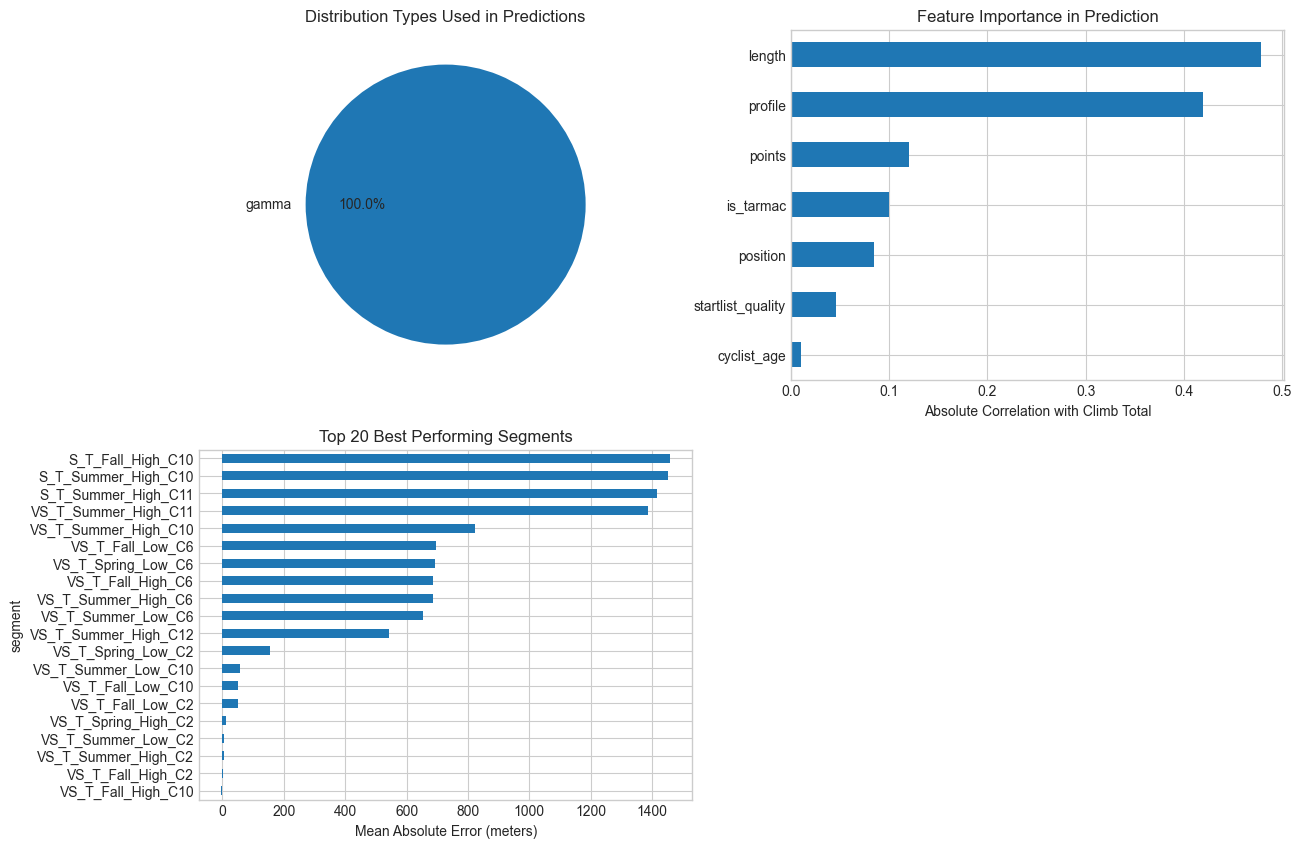

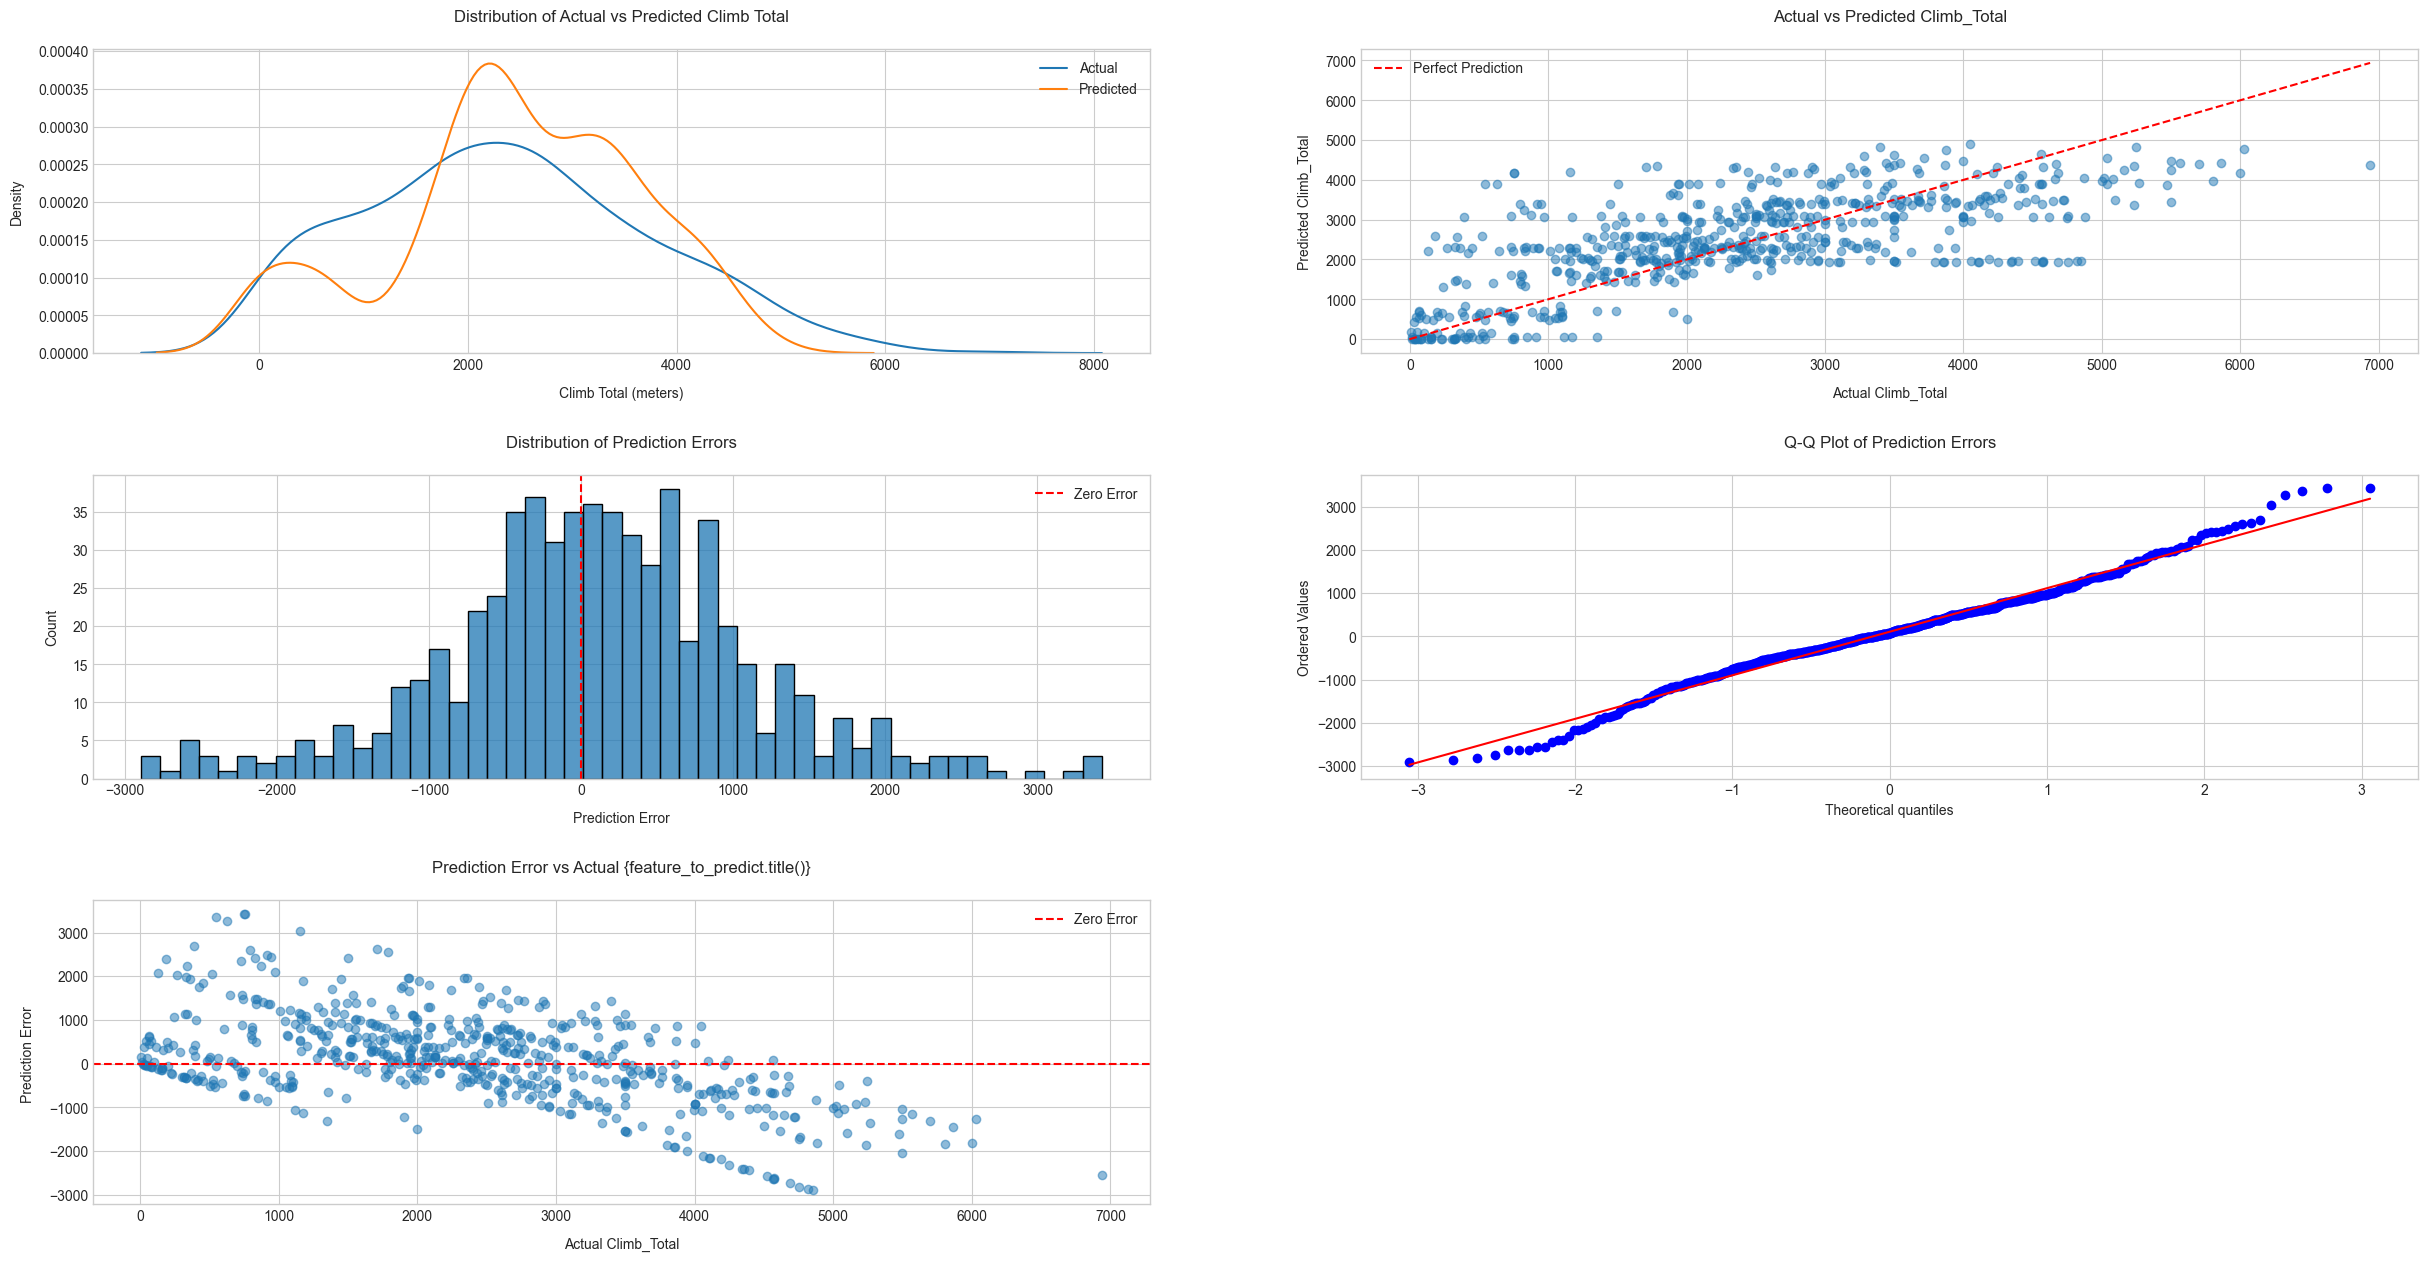

In [19]:
df_test = GroupedRaces[GroupedRaces['climb_total'].notna()].copy()
random_indices = df_test.sample(frac=0.2).index
y_test = df_test.loc[random_indices, 'climb_total']
df_test.loc[random_indices, 'climb_total'] = np.nan


local_normal_features = normal_features.copy()
# del local_normal_features['points']
# del local_normal_features['cyclist_age']
# del local_normal_features['startlist_quality']
# del local_normal_features['position']

predictions, stats_races = predict_feature_density(
    df_test, segmentation_features=local_normal_features, n_clusters_final=6, feature_to_predict='climb_total'
)


print_density_info(stats_races, predictions, y_test, 'climb_total')
create_prediction_visualizations(predictions, y_test, stats_races, feature_name="climb_total")


del df_test

#### K-Nearest Neighbor imputation approach


- Takes a dataframe, feature definitions, and a target feature to predict
- Uses KNN imputation to fill in missing values by finding similar data points
- If requested, calculates prediction accuracy metrics (RMSE, R², MAE, MSE)
- Creates error visualizations

It's essentially a specialized imputation function that uses KNN to fill missing values by looking at similar samples in the dataset, with built-in error checking and performance validation.


In [21]:
from sklearn.impute import KNNImputer
import logging
from typing import Tuple, Optional, Dict



def predict_feature_knnimp(
    df: pd.DataFrame,
    features: Dict[str, Dict[str, str]],
    feature_to_predict: str,
    type: str,
    y_true: pd.Series | None = None,
    n_neighbors: int = 5,
    min_samples_required: int = 100,
    return_metrics: bool = True
) -> Tuple[pd.DataFrame, Optional[Dict[str, float]]]:
    """
    Predicts missing climb_total values in cycling race data using KNN imputation
    with advanced feature engineering and validation.
    """
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    warnings.filterwarnings('ignore', category=UserWarning)
    
    try:
        # Validate input data
        missing_race_cols = [col for col in features if col not in df.columns]
        if missing_race_cols:
            raise ValueError(f"Missing required columns. Races: {missing_race_cols}")

        logger.info("Starting prediction process...")
        
        
        
        features = {**features, feature_to_predict: {'type': type}}
        
        X = df[features.keys()].copy()
        
        if len(X) < min_samples_required:
            raise ValueError(f"Insufficient data: {len(X)} samples, {min_samples_required} required")
        
        
        
        # Apply KNN imputation
        logger.info("Applying KNN imputation...")
        imputer = KNNImputer(n_neighbors=n_neighbors, weights='distance')
        X_imputed = imputer.fit_transform(X)
        
    
        
        # Extract only the `feature_to_predict`` column from predictions
        feature_to_pred_idx = list(X.columns).index(feature_to_predict)
        predicted_feature = X_imputed[:, feature_to_pred_idx]

        y_pred = pd.Series(predicted_feature, index=X.index, name=f'{feature_to_predict}_predicted')
        
        
        # Calculate metrics if requested
        metrics = None
        if return_metrics and y_true is not None:
            logger.info("Calculating validation metrics...")
            y_pred = y_pred.loc[y_true.index]  # Ensure we're comparing 1D arrays 
            logger.info(f"y_pred shape: {y_pred.shape}, y_true shape: {y_true.shape}")

            
            mse_con = mse(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            rmse = np.sqrt(mse_con)
            mae = np.mean(np.abs(y_true - y_pred))
            
            metrics = {
                'mse': round(mse_con, 2),
                'rmse': round(rmse, 2),
                'mae': round(mae, 2),
                'r2': round(r2, 2),
                'samples_used': len(y_pred),
            }
            errors_visualization(y_true, y_pred, feature_to_predict) 
            logger.info(f"Validation metrics: RMSE={rmse:.2f}, R2={r2:.2f}")
        else:
            logger.info("Prediction complete")
        
        return metrics
    
    except Exception as e:
        logger.error(f"Error in prediction process: {str(e)}")
        raise RuntimeError(f"Prediction failed: {str(e)}")

#### Executing KNNImputer defined above.


INFO:__main__:Starting prediction process...
INFO:__main__:Applying KNN imputation...
INFO:__main__:Calculating validation metrics...
INFO:__main__:y_pred shape: (613,), y_true shape: (613,)
INFO:__main__:Validation metrics: RMSE=29.88, R2=0.56



Metrics:
MSE: 892.89
RMSE: 29.88
MAE: 709.7
R2: 0.56
SAMPLES_USED: 613


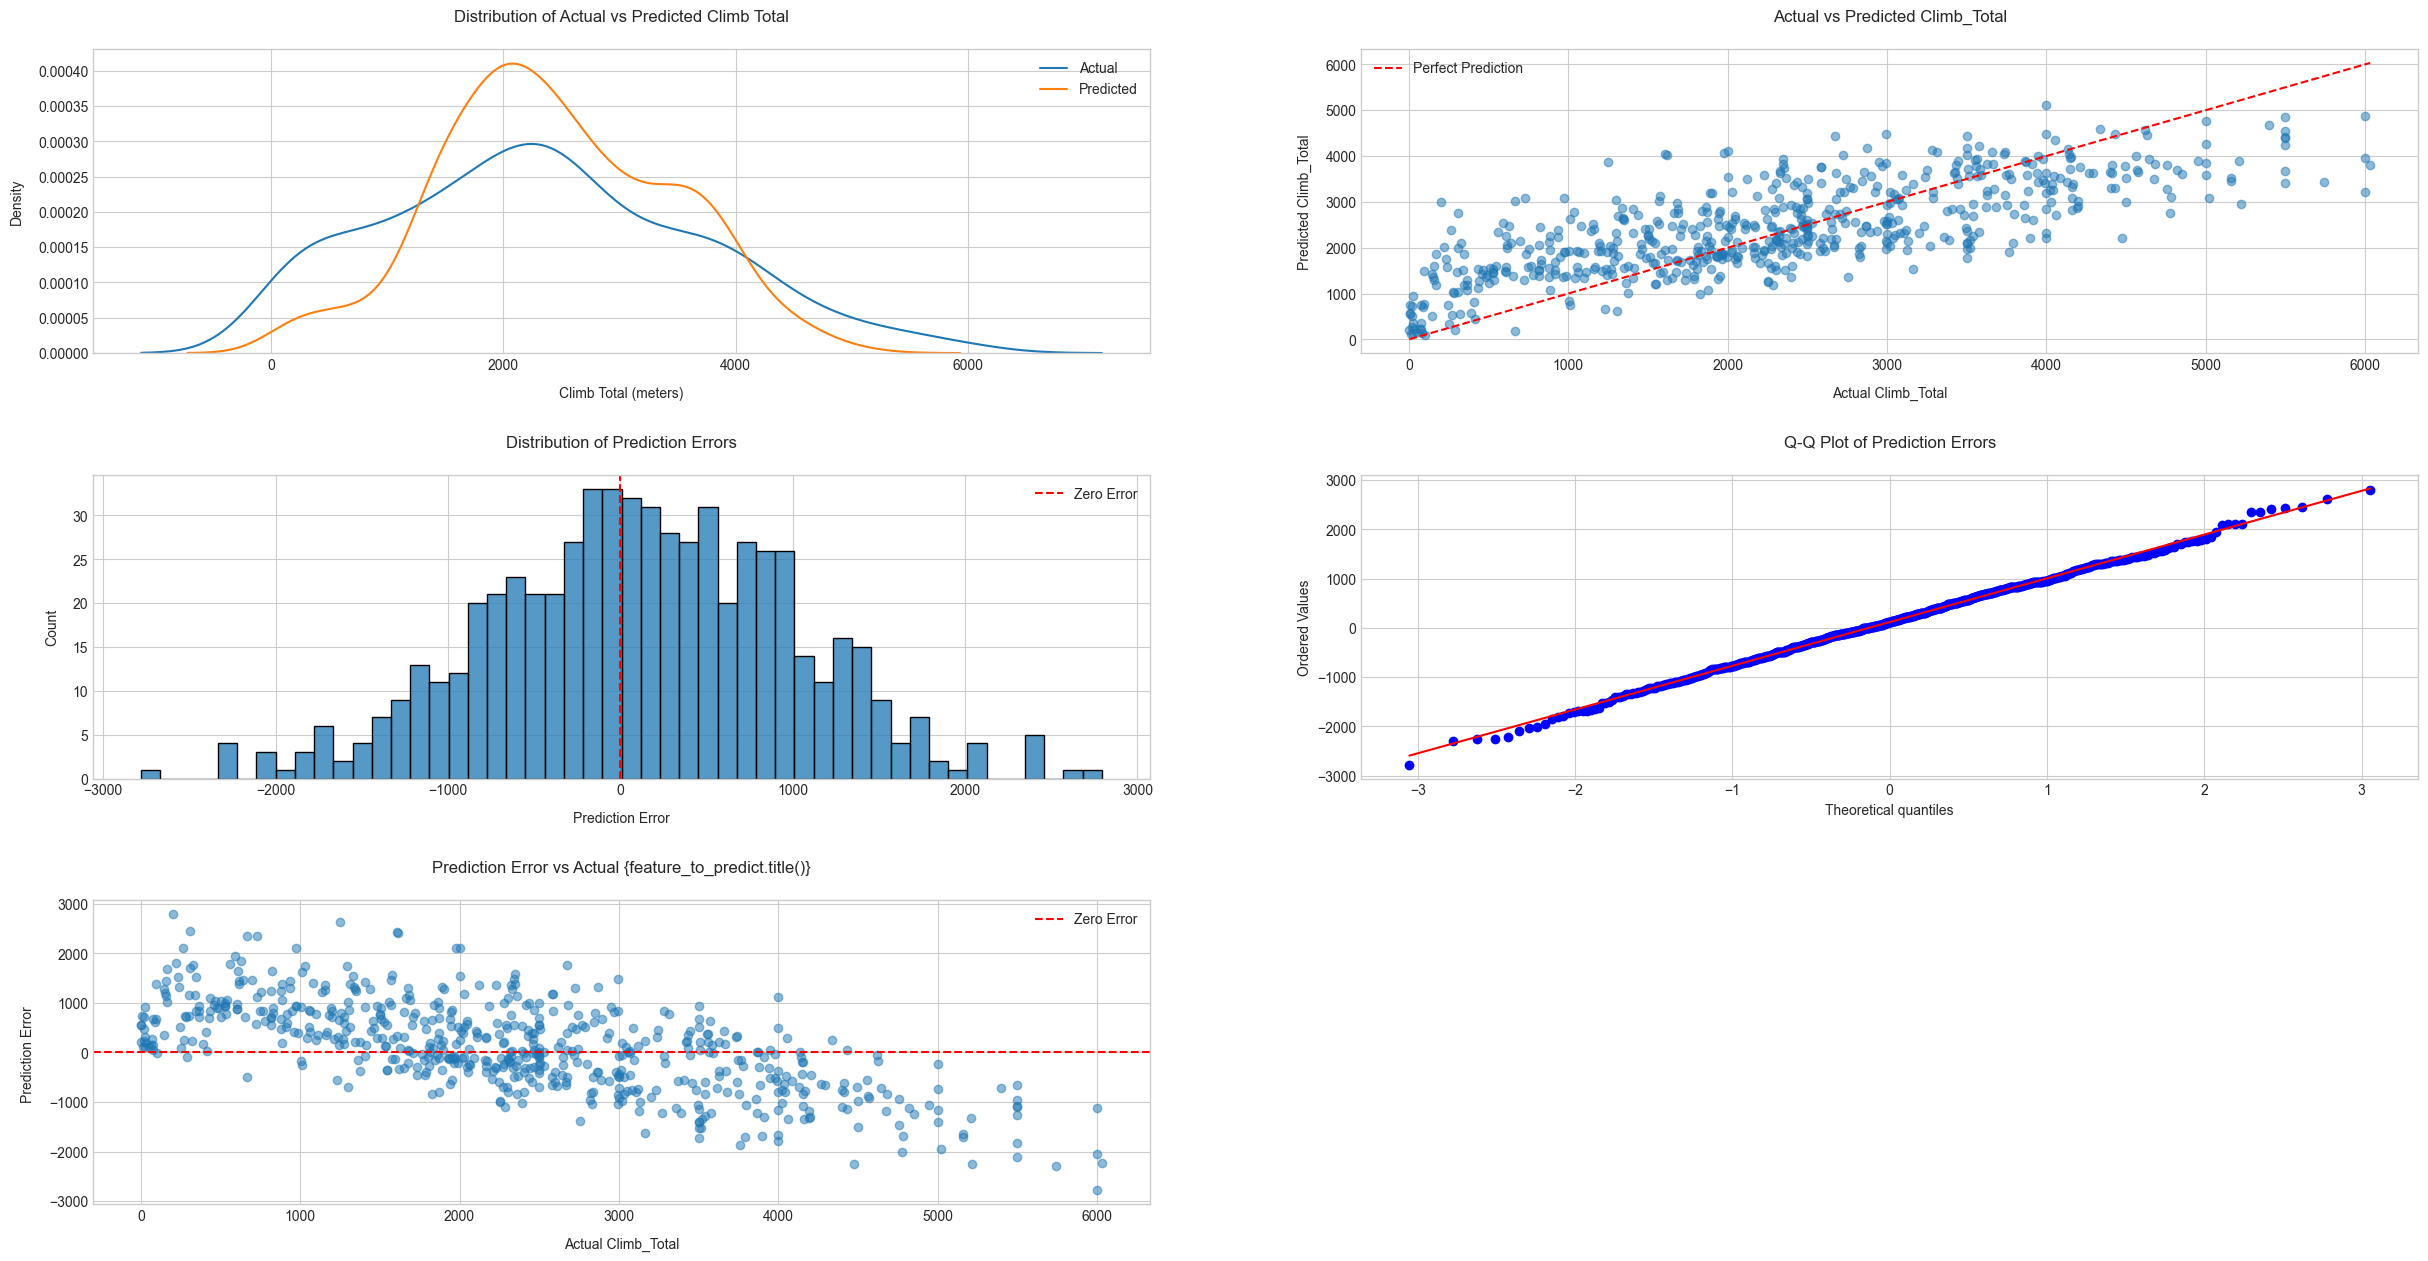

In [23]:

df_test = GroupedRaces[GroupedRaces['climb_total'].notna()].copy()
random_indices = df_test.sample(frac=0.2).index
y_test = df_test.loc[random_indices, 'climb_total']

df_test.loc[random_indices, 'climb_total'] = np.nan

metrics = predict_feature_knnimp(df_test, n_neighbors=7, feature_to_predict='climb_total', type='numeric', y_true=y_test, features=pred_features)

metrics

# print the metrics
print("\nMetrics:")
for key, value in metrics.items():
    print(f"{key.upper()}: {value}")

del df_test

####  `climb_total` Predictions substitution

Based on the comparison between the `RMSE` and `R²` values of the previous approaches, we decide to use the Voting Regressor to fill the missing values in `climb_total`.

In [8]:
climb_total_pred_v1 = climb_total_pred.apply(lambda x: round(x, 0))

temp_obj = DatasetRace.loc[DatasetRace['climb_total'].isna(), '_url'].map(climb_total_pred_v1)

# Update the 'climb_total' column in races_v1 only for NaN entries
DatasetRace.loc[temp_obj.index, 'climb_total'] = temp_obj
print(f"Number of missing values in climb_total: {DatasetRace['climb_total'].isna().sum()}")

Number of missing values in climb_total: 0


#### Executing on `profile`

Since the best approach for predicting the `profile` NaN values was the same as above, we will only show the results of running the `compare_regressor` algorithm and skip the rest. For other results, refer to the file [OleksiyDataTrans.ipynb](OleksiyDataTrans.ipynb).


#### Dataset preparation

In [9]:
DatasetRace_profile = DatasetRace_temp.drop(columns=['profile']).copy()

# Update the 'climb_total' column with true values and predicted values for NaN entries
DatasetRace_profile['climb_total'] = DatasetRace['climb_total']

# Updating the profile column with the original  values
DatasetRace_profile['profile'] = DatasetRace['profile']
print(f"Number of missing values in climb: {DatasetRace['profile'].isna().sum()}")

# scaling the 'climb_total' column
preprocess_helper_scaler(DatasetRace_profile, {'climb_total': {'type': 'numeric'}})

DatasetRace_profile.sample(frac=0.3).head(10)

del DatasetRace_temp
del GroupedRaces

Number of missing values in climb: 148194


In [10]:
normal_features_prof = normal_features.copy()
del normal_features_prof['profile']
normal_features_prof['climb_total'] = {'type': 'numeric', 'agg': 'first'}
FEATURES_PROF = {**normal_features_prof, **engineered_features}

pred_features_prof = {name: {'type': props['type']} for name, props in FEATURES_PROF.items()}

agg_dict_prof = {name: props['agg'] for name, props in FEATURES_PROF.items()}
agg_dict_prof['date'] = 'first'
agg_dict_prof['profile'] = 'first'

DatasetRace_profile_grouped = DatasetRace_profile.groupby(["_url"]).agg(agg_dict_prof)

DatasetRace_profile_grouped.sample(frac=0.4).head(5)

length    points  startlist_quality  \
_url                                                                   
giro-d-italia/1996/stage-9     0.266848 -0.169602          -0.176468   
dauphine/2008/stage-8         -0.600757 -0.720915          -1.201201   
vuelta-a-espana/2005/stage-11  0.400087 -0.169602          -0.370904   
giro-d-italia/2013/stage-13    1.351353 -0.169602          -0.449730   
giro-d-italia/2012/stage-19    0.483749 -0.169602          -0.565341   

                               is_tarmac  position  cyclist_age  climb_total  \
_url                                                                           
giro-d-italia/1996/stage-9           1.0 -0.035524    -0.385501    -0.449246   
dauphine/2008/stage-8                1.0 -0.428053     0.133271     0.205493   
vuelta-a-espana/2005/stage-11        1.0  0.067774    -0.126115     1.863400   
giro-d-italia/2013/stage-13          1.0  0.367336     0.133271    -0.326721   
giro-d-italia/2012/stage-19          1.0  0.140082    -0.385501     2.667465   

                               points_per_km  season_score  season  \
_url                                                                 
giro-d-italia/1996/stage-9         -0.253101      0.539284       1   
dauphine/2008/stage-8              -0.269540      0.106045       2   
vuelta-a-espana/2005/stage-11      -0.260329     -1.613111       0   
giro-d-italia/2013/stage-13        -0.297707      0.753022       1   
giro-d-italia/2012/stage-19        -0.264546      0.580563       1   

                               team_presents  adjusted_delta  \
_url                                                           
giro-d-italia/1996/stage-9       -104.997975       -0.186038   
dauphine/2008/stage-8              13.835657        0.001485   
vuelta-a-espana/2005/stage-11     -17.814073        0.142548   
giro-d-italia/2013/stage-13        78.666926       -0.188679   
giro-d-italia/2012/stage-19        78.810718        0.429494   

                                             date  profile  
_url                                                        
giro-d-italia/1996/stage-9    1996-05-27 04:24:48      NaN  
dauphine/2008/stage-8         2008-06-15 03:17:20      NaN  
vuelta-a-espana/2005/stage-11 2005-09-06 05:09:38      5.0  
giro-d-italia/2013/stage-13   2013-05-17 06:09:55      1.0  
giro-d-italia/2012/stage-19   2012-05-25 06:18:03      5.0

#### Executing `comapare_regressors` 


Training Random Forest...

Training Gradient Boosting...

Training XGBoost...

Training Huber...

Training Linear Regression...

Training Ridge...

Training Lasso...

Training KNeighborsRegressor...

Training HistGradientBoostingRegressor...

Training VotingRegressor...


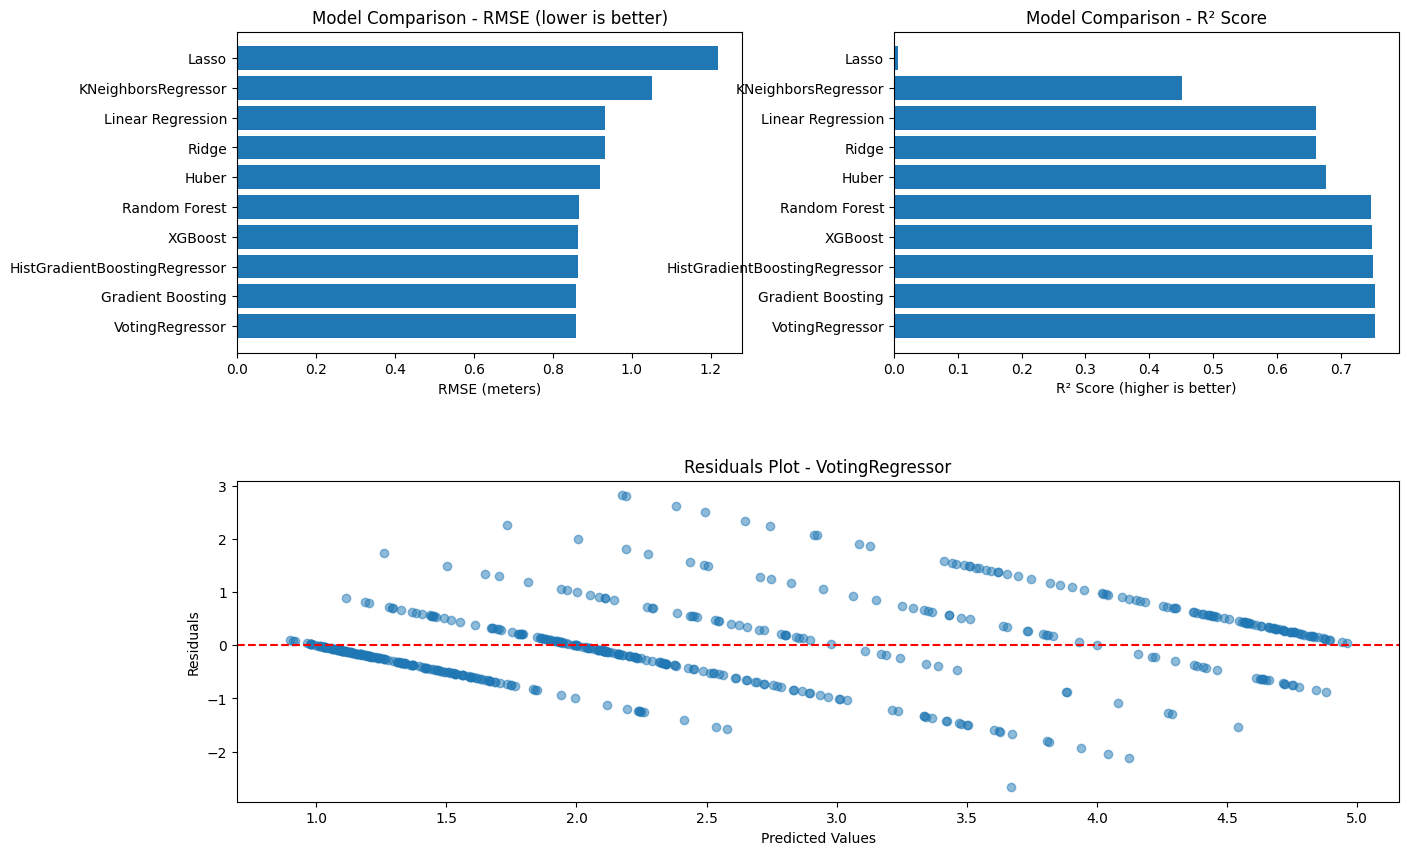


Summary of all models:
                                   RMSE        R²   CV RMSE  CV RMSE Std
VotingRegressor                0.859743  0.754083  0.849261     0.033283
Gradient Boosting              0.859912  0.753889  0.853560     0.032665
HistGradientBoostingRegressor  0.862827  0.750535  0.869032     0.029709
XGBoost                        0.864608  0.748469  0.855823     0.032085
Random Forest                  0.866209  0.746601  0.852706     0.043265
Huber                          0.920622  0.676674  0.960270     0.130650
Ridge                          0.931654  0.660896  0.968353     0.117615
Linear Regression              0.931733  0.660780  0.970124     0.120514
KNeighborsRegressor            1.050509  0.451832  1.185964     0.097033
Lasso                          1.218844  0.006639  1.479572     0.133635
Visualizations for the best model:


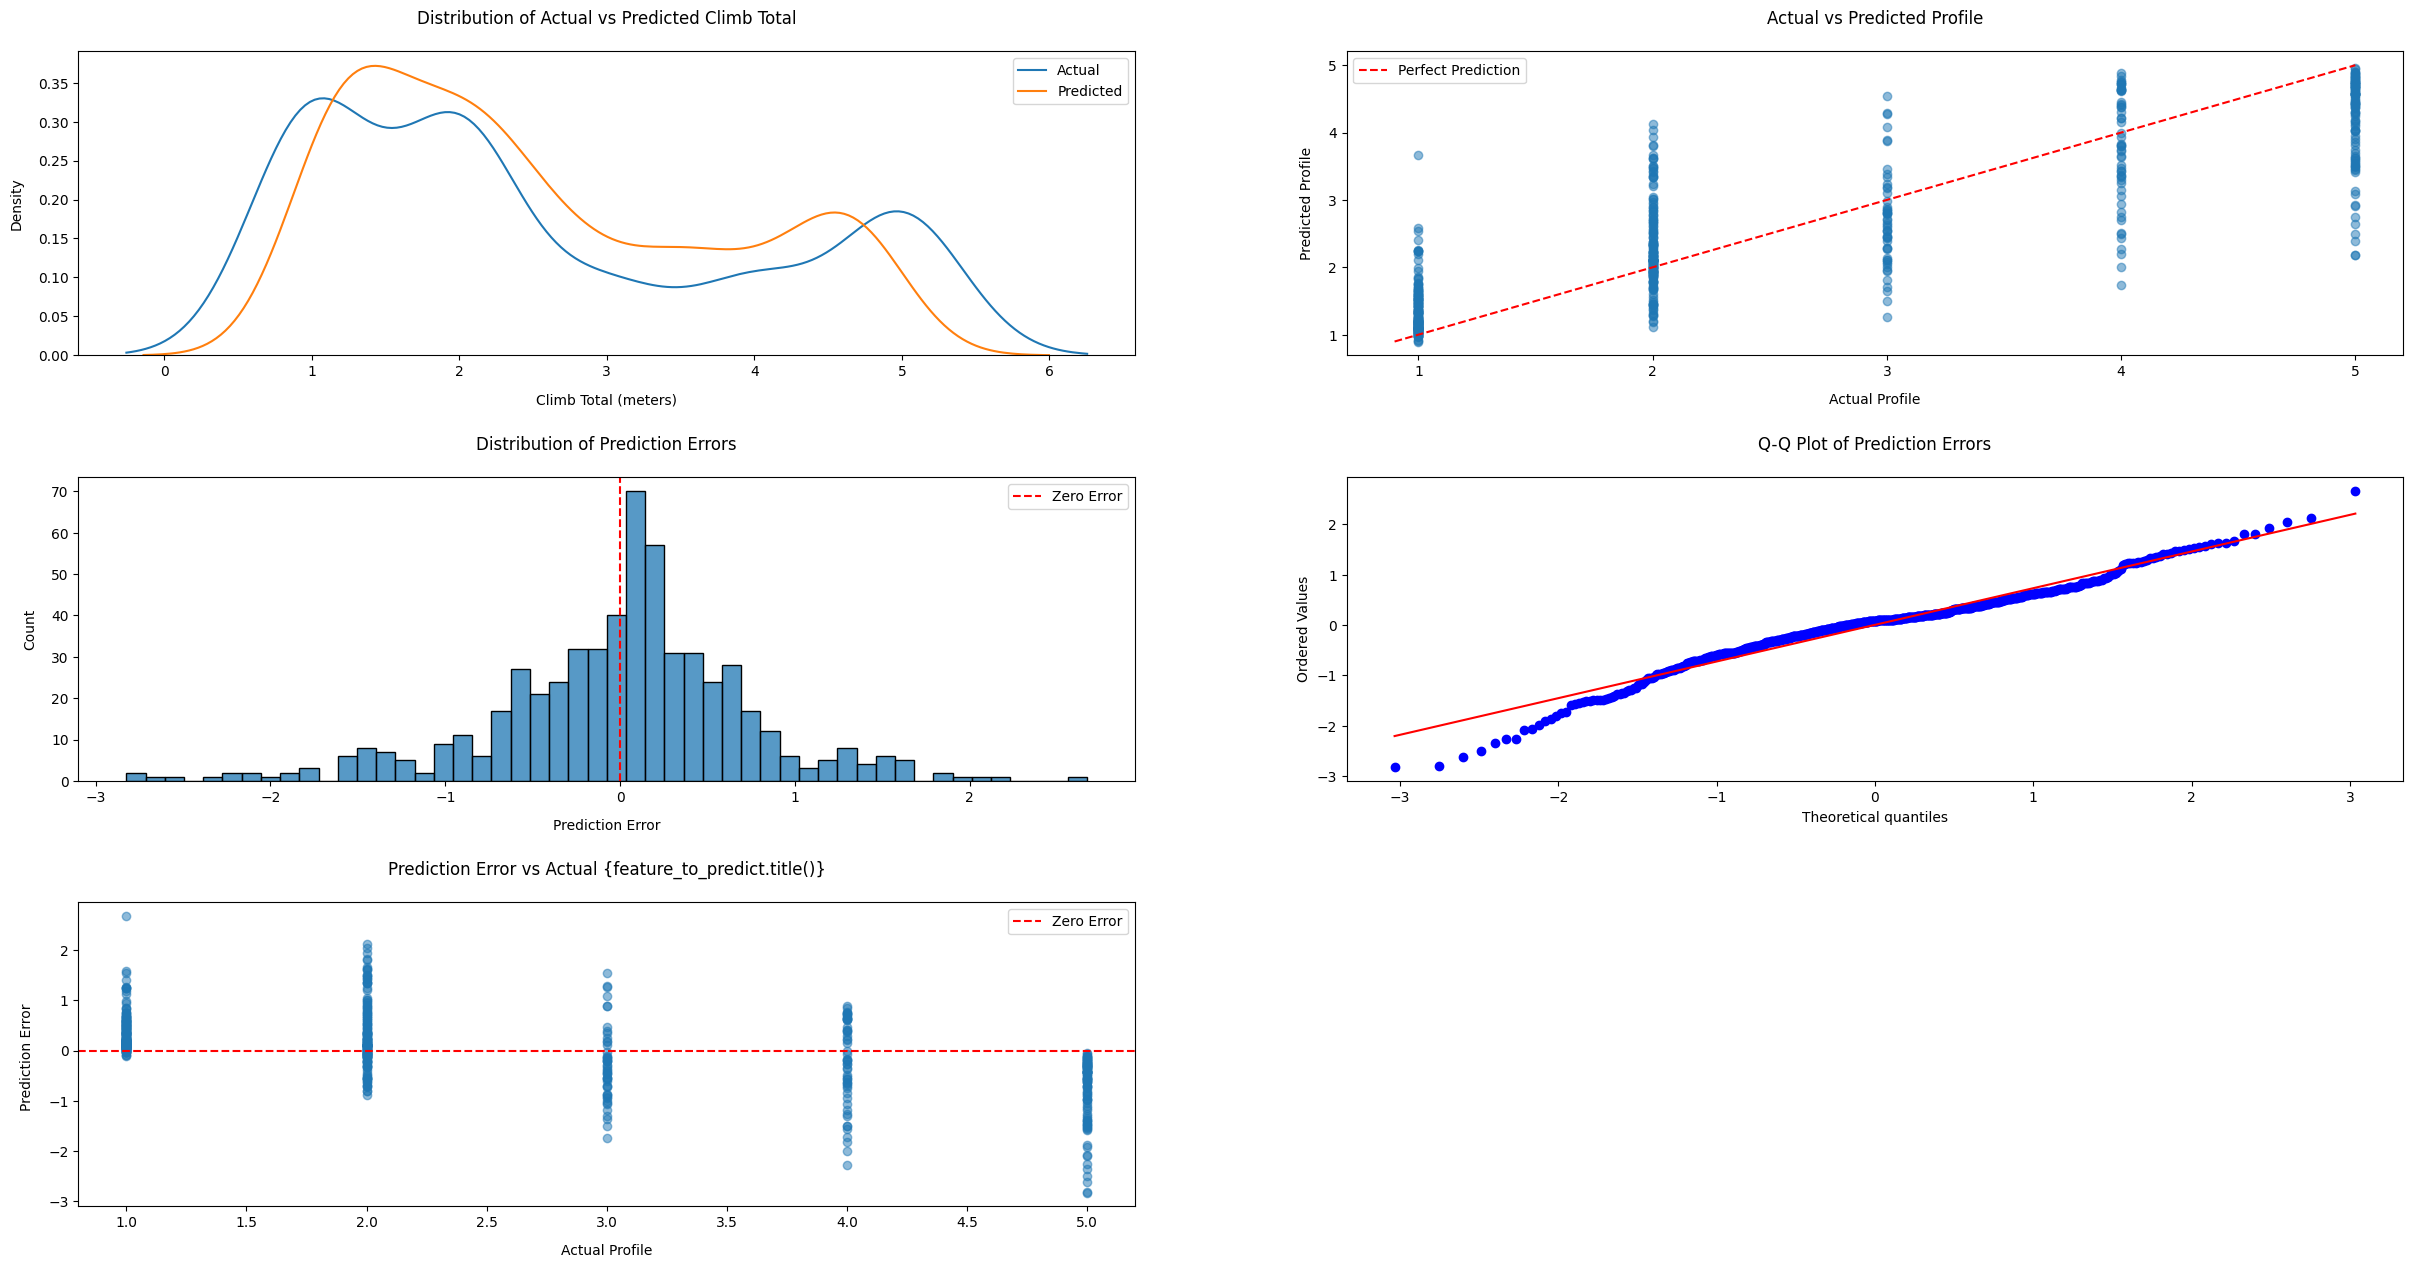

In [11]:
results_profile, summary_prof, profile_pred =  compare_regressors(DatasetRace_profile_grouped, "profile", features=pred_features_prof)

#### `profile` predictions substitution

In [12]:
profile_pred_v1 = profile_pred.apply(lambda x: round(x, 0))

temp_obj_profile = DatasetRace.loc[DatasetRace['profile'].isna(), '_url'].map(profile_pred_v1)

# Update the 'profile' column
DatasetRace.loc[temp_obj_profile.index, 'profile'] = temp_obj_profile

DatasetRace['profile'].isna().sum()

np.int64(0)

### Fill data of points and uci_points columns (Oleskiy)

Now we will proceed to predict the `points` and `uci_points`. As mentioned earlier, the best approach was the first one, so we will only present its results.

Warning: might take some minutes to run.

In [13]:
DatasetRace_points = DatasetRace_profile.drop(columns=['points']).copy()
DatasetRace_points['profile'] = DatasetRace['profile']

# Update the 'points' column with true values and predicted values for NaN entries
DatasetRace_points['points'] = DatasetRace['points']



normal_features_points = normal_features_prof.copy()
del normal_features_points['points']
normal_features_points['profile'] = {'type': 'categorical', 'agg': 'first'}
FEATURES_POINTS = {**normal_features_points, **engineered_features}

pred_features_points = {name: {'type': props['type']} for name, props in FEATURES_POINTS.items()}

agg_dict_points = {name: props['agg'] for name, props in FEATURES_POINTS.items()}
agg_dict_points['date'] = 'first'
agg_dict_points['points'] = 'mean'

DatasetRace_points_groupd = DatasetRace_points.groupby(["_url", "cyclist"]).agg(agg_dict_points)

DatasetRace_points_groupd.sample(frac=0.4).head(5)

del DatasetRace_profile
del DatasetRace_profile_grouped

DatasetRace_points_groupd.sample(frac=0.4).head(5)

#### Executing the `compare_regressors` algorithm (will take long)


Training Random Forest...

Training Gradient Boosting...

Training XGBoost...

Training Huber...

Training Linear Regression...

Training Ridge...

Training Lasso...

Training KNeighborsRegressor...

Training HistGradientBoostingRegressor...

Training VotingRegressor...


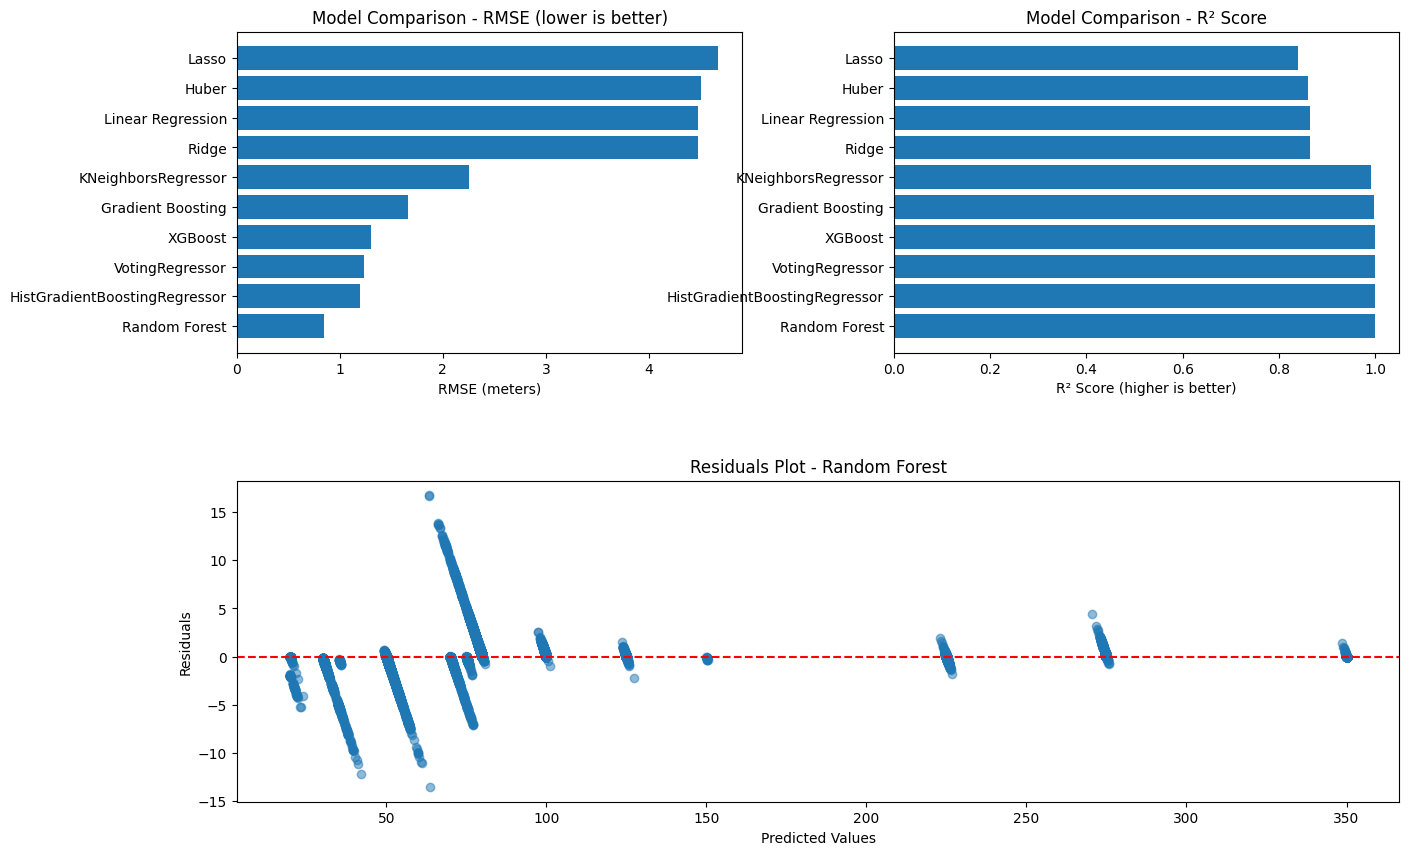


Summary of all models:
                                   RMSE        R²    CV RMSE  CV RMSE Std
Random Forest                  0.843727  0.999829   4.011641     0.379726
HistGradientBoostingRegressor  1.192562  0.999316   4.060135     0.676369
VotingRegressor                1.236376  0.999210   3.522251     0.291634
XGBoost                        1.302055  0.999029   3.667007     0.890875
Gradient Boosting              1.664503  0.997406   4.224530     0.147818
KNeighborsRegressor            2.252800  0.991296  11.740529     0.855086
Ridge                          4.476150  0.864345  20.391832     0.632246
Linear Regression              4.476153  0.864345  20.391731     0.632151
Huber                          4.506669  0.860608  21.112656     1.354489
Lasso                          4.673665  0.838770  21.894422     0.649607
Visualizations for the best model:


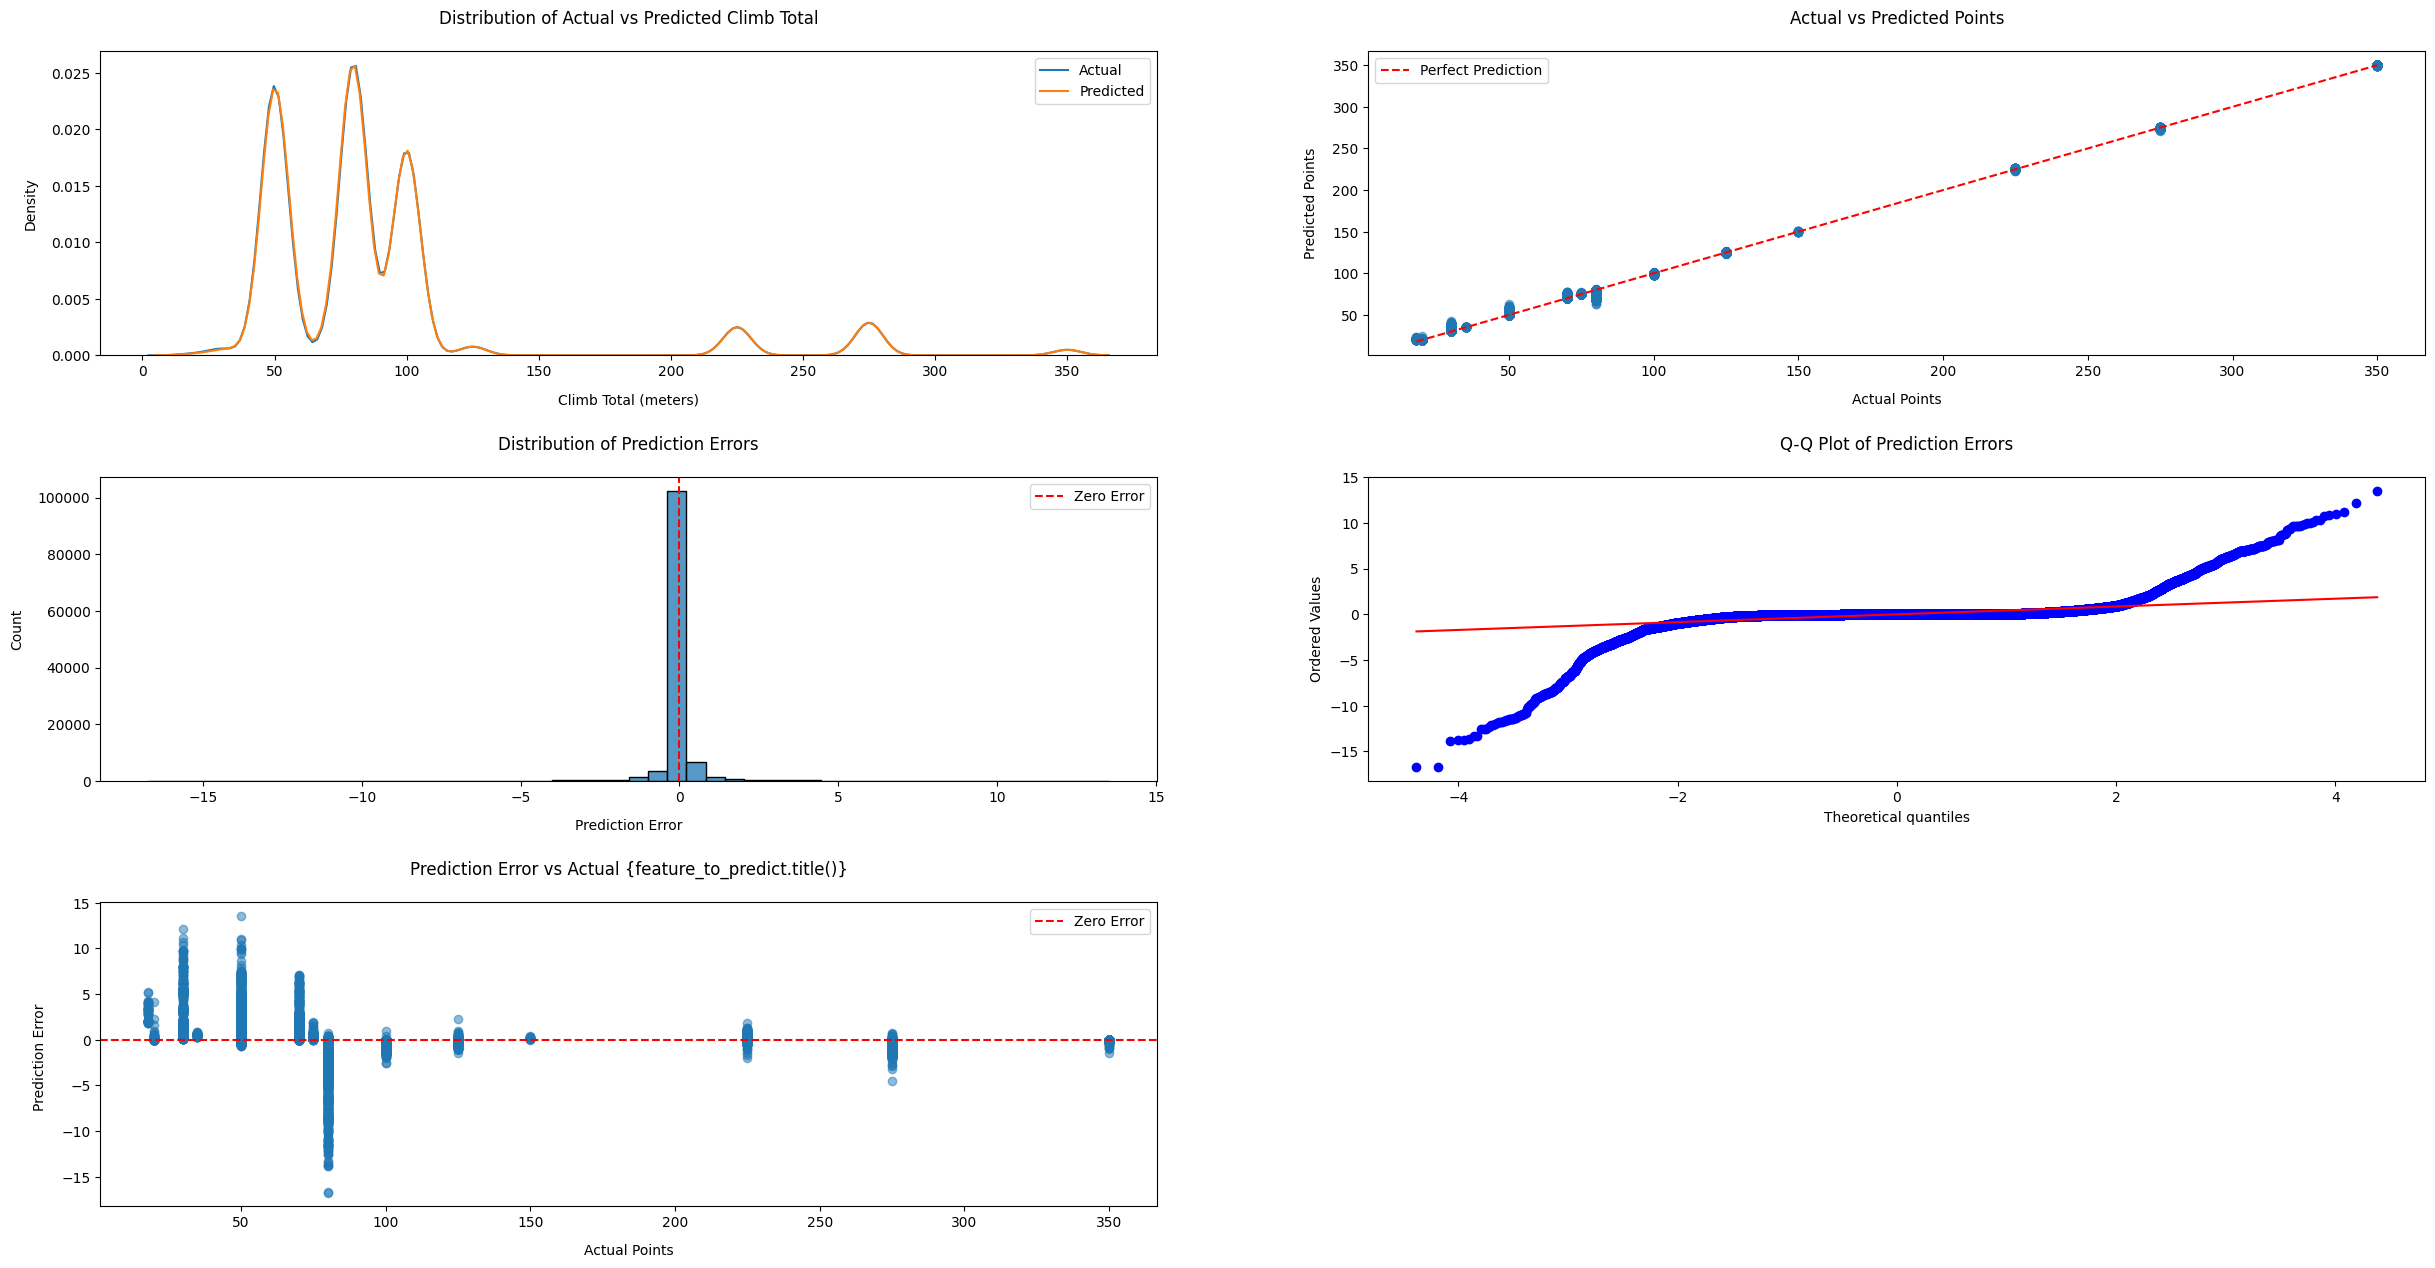

In [14]:
results_points, summary_points, points_pred =  compare_regressors(DatasetRace_points, "points", features=pred_features_points)

#### `points` predictions substitution

In [28]:
points_pred_v1 = points_pred.apply(lambda x: round(x, 0))


# # Update the 'points' column
DatasetRace.loc[points_pred.index, 'points'] = points_pred_v1

print(f"Number of missing values in points: {DatasetRace['points'].isna().sum()}")

Number of missing values in points: 0


#### Executing on `uci_points`

In [29]:
DatasetRace_uci_points = DatasetRace_points.copy()
DatasetRace_uci_points['points'] = DatasetRace['points']
preprocess_helper_scaler(DatasetRace_uci_points, {'points': {'type': 'numeric'}})

DatasetRace_uci_points['uci_points'] = DatasetRace['uci_points']

noraml_features_uci_points = normal_features_points.copy()

noraml_features_uci_points['points'] = {'type': 'numeric', 'agg': 'mean'}
FEATURES_UCI_POINTS = {**noraml_features_uci_points, **engineered_features}

pred_features_uci_points = {name: {'type': props['type']} for name, props in FEATURES_UCI_POINTS.items()}

agg_dict_uci_points = {name: props['agg'] for name, props in FEATURES_UCI_POINTS.items()}
agg_dict_uci_points['date'] = 'first'
agg_dict_uci_points['uci_points'] = 'mean'

DatasetRace_uci_points_groupd = DatasetRace_uci_points.groupby(["_url", "cyclist"]).agg(agg_dict_uci_points)


DatasetRace_uci_points_groupd.sample(frac=0.4).head(5)

# del DatasetRace_points
# del DatasetRace_points_groupd

length  \
_url                           cyclist                         
tour-de-france/1991/stage-1    thierry-laurent     -0.809911   
tirreno-adriatico/2020/stage-7 william-barta        0.220369   
volta-a-catalunya/2008/stage-2 dmytro-grabovskyy    0.389242   
giro-d-italia/2012/stage-8     andreas-schillinger  0.964030   
giro-d-italia/2007/stage-4     leonardo-scarselli  -0.197941   

                                                    startlist_quality  \
_url                           cyclist                                  
tour-de-france/1991/stage-1    thierry-laurent               2.185676   
tirreno-adriatico/2020/stage-7 william-barta                -1.088218   
volta-a-catalunya/2008/stage-2 dmytro-grabovskyy            -1.274772   
giro-d-italia/2012/stage-8     andreas-schillinger          -0.565341   
giro-d-italia/2007/stage-4     leonardo-scarselli           -0.675697   

                                                    is_tarmac  position  \
_url                           cyclist                                    
tour-de-france/1991/stage-1    thierry-laurent            1.0 -0.252448   
tirreno-adriatico/2020/stage-7 william-barta              1.0  0.078103   
volta-a-catalunya/2008/stage-2 dmytro-grabovskyy          1.0  0.635909   
giro-d-italia/2012/stage-8     andreas-schillinger        1.0  2.040752   
giro-d-italia/2007/stage-4     leonardo-scarselli         1.0  0.387995   

                                                    cyclist_age  climb_total  \
_url                           cyclist                                         
tour-de-france/1991/stage-1    thierry-laurent        -0.904273    -0.513571   
tirreno-adriatico/2020/stage-7 william-barta          -1.163659     0.315765   
volta-a-catalunya/2008/stage-2 dmytro-grabovskyy      -1.423045     1.302085   
giro-d-italia/2012/stage-8     andreas-schillinger     0.133271     1.357987   
giro-d-italia/2007/stage-4     leonardo-scarselli      0.911428     0.849511   

                                                    profile    points  \
_url                           cyclist                                  
tour-de-france/1991/stage-1    thierry-laurent          1.0  0.198029   
tirreno-adriatico/2020/stage-7 william-barta            3.0 -0.720851   
volta-a-catalunya/2008/stage-2 dmytro-grabovskyy        4.0 -0.720851   
giro-d-italia/2012/stage-8     andreas-schillinger      2.0 -0.169523   
giro-d-italia/2007/stage-4     leonardo-scarselli       5.0 -0.169523   

                                                    points_per_km  \
_url                           cyclist                              
tour-de-france/1991/stage-1    thierry-laurent          -0.089833   
tirreno-adriatico/2020/stage-7 william-barta            -0.312120   
volta-a-catalunya/2008/stage-2 dmytro-grabovskyy        -0.317961   
giro-d-italia/2012/stage-8     andreas-schillinger      -0.284907   
giro-d-italia/2007/stage-4     leonardo-scarselli       -0.221571   

                                                    season_score  season  \
_url                           cyclist                                     
tour-de-france/1991/stage-1    thierry-laurent         -0.418371       2   
tirreno-adriatico/2020/stage-7 william-barta           -1.683550       0   
volta-a-catalunya/2008/stage-2 dmytro-grabovskyy        0.660015       1   
giro-d-italia/2012/stage-8     andreas-schillinger      0.805198       1   
giro-d-italia/2007/stage-4     leonardo-scarselli       0.770727       1   

                                                    team_presents  \
_url                           cyclist                              
tour-de-france/1991/stage-1    thierry-laurent          -1.645020   
tirreno-adriatico/2020/stage-7 william-barta             0.607895   
volta-a-catalunya/2008/stage-2 dmytro-grabovskyy        -1.645020   
giro-d-italia/2012/stage-8     andreas-schillinger       0.607895   
giro-d-italia/2007/stage-4     leonardo-scarselli       -1.6450

#### Executing the `compare_regressors` algorithm (will slightly long)


Training Random Forest...

Training Gradient Boosting...

Training XGBoost...

Training Huber...

Training Linear Regression...

Training Ridge...

Training Lasso...

Training KNeighborsRegressor...

Training HistGradientBoostingRegressor...

Training VotingRegressor...


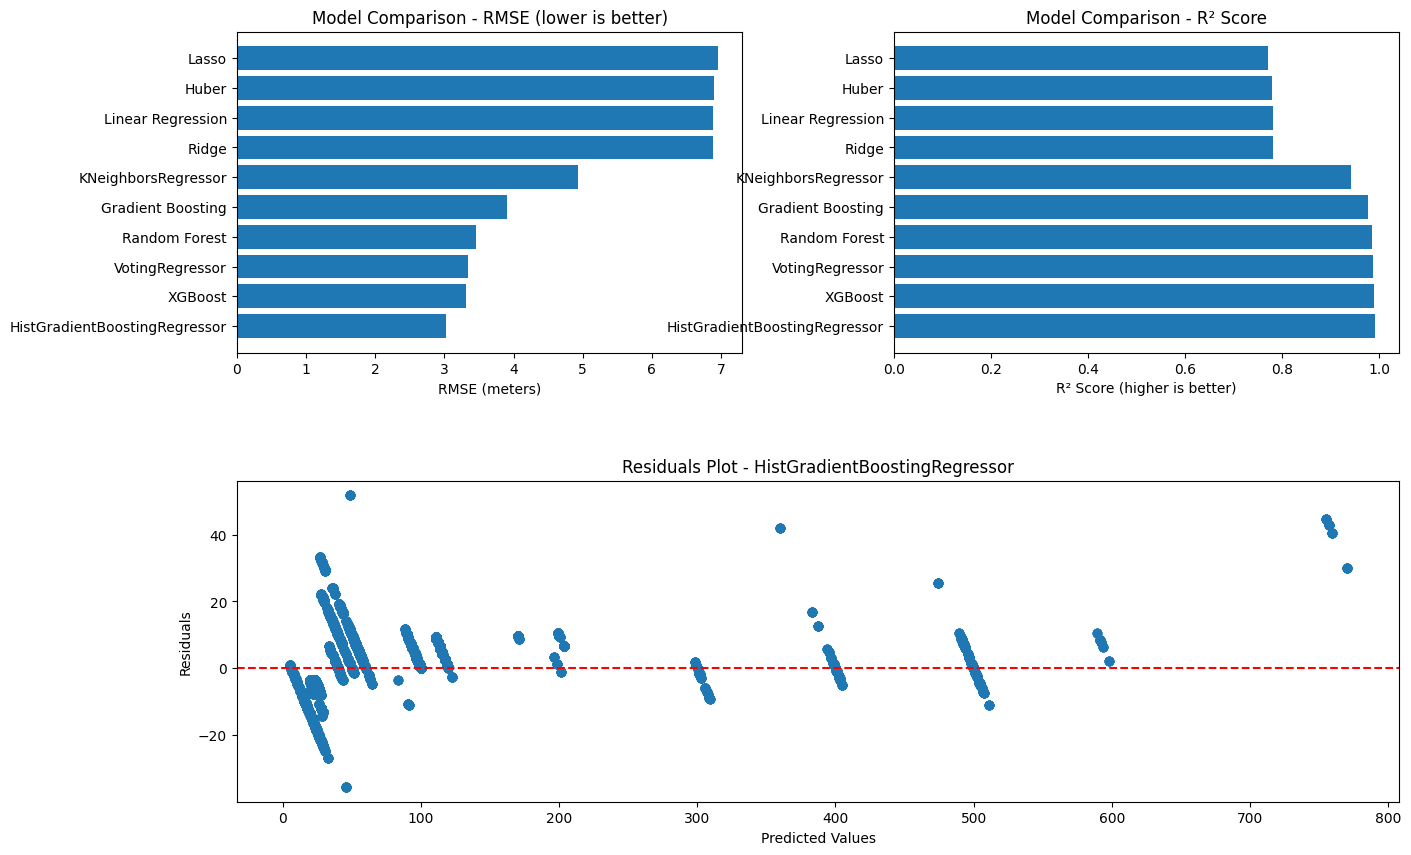


Summary of all models:
                                   RMSE        R²    CV RMSE  CV RMSE Std
HistGradientBoostingRegressor  3.025849  0.991827  67.137971    12.090533
XGBoost                        3.318058  0.988183  72.014432     8.962153
VotingRegressor                3.347007  0.987765  66.409975     9.709861
Random Forest                  3.462612  0.985985  64.463169     8.795316
Gradient Boosting              3.899862  0.977449  68.241935    10.594083
KNeighborsRegressor            4.925522  0.942617  76.297890     9.706978
Ridge                          6.881947  0.781314  56.440274     9.182485
Linear Regression              6.881954  0.781313  56.444972     9.184113
Huber                          6.902075  0.778744  55.678496     6.634463
Lasso                          6.958728  0.771390  56.313564    10.724809
Visualizations for the best model:


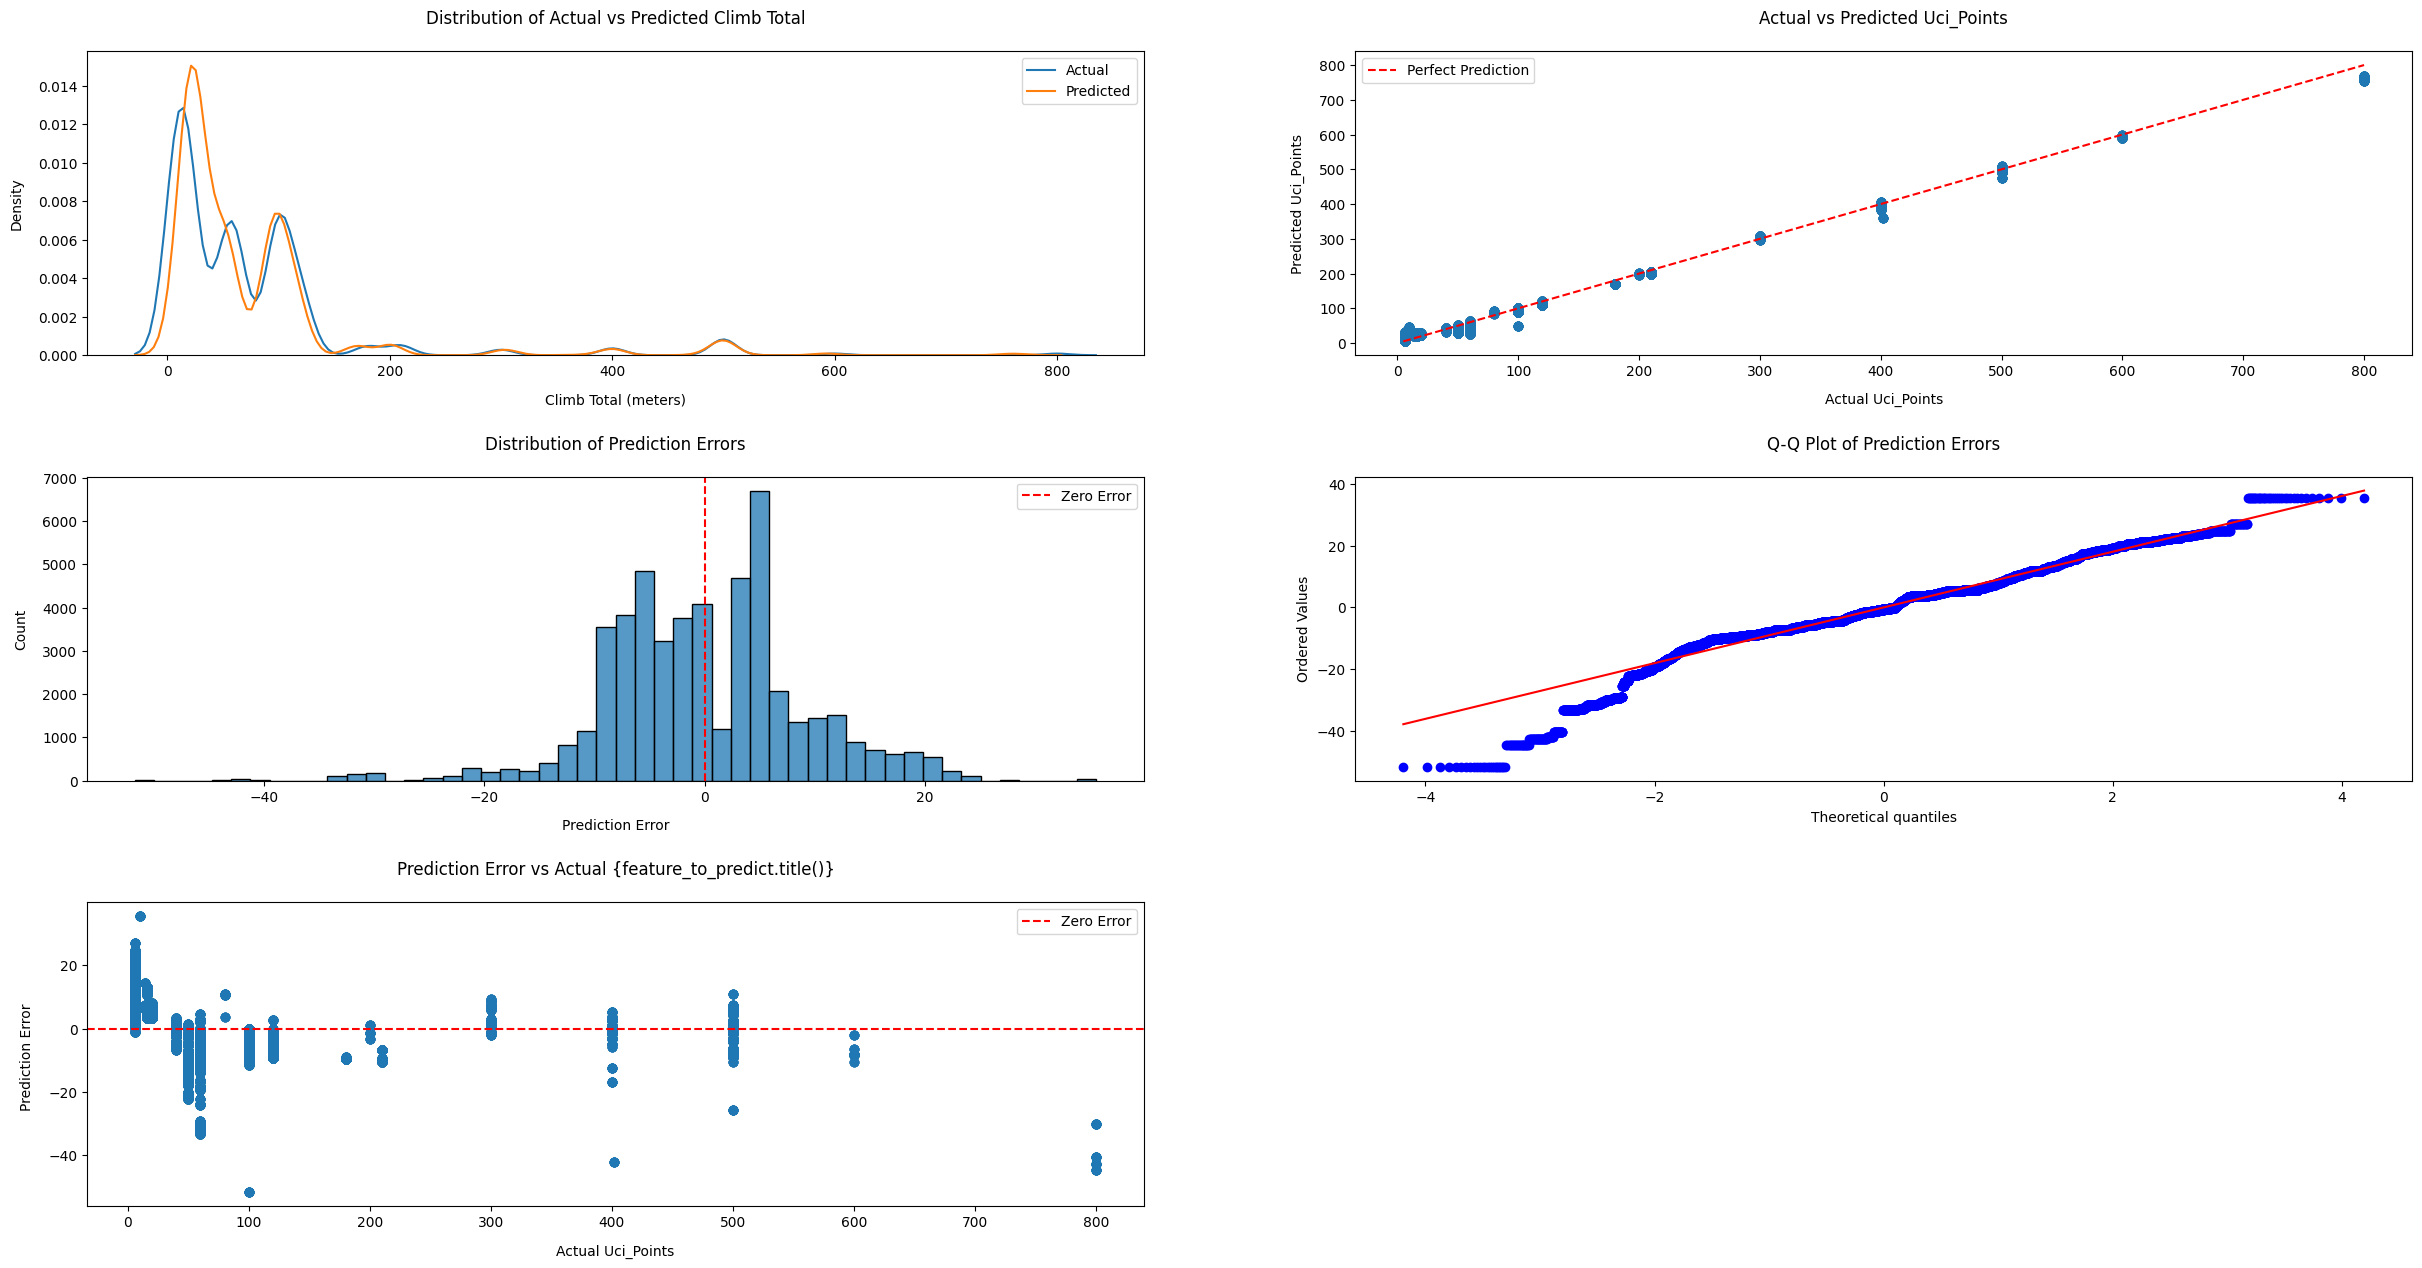

In [30]:
results_uci_points, summary_uci_points, uci_points_pred =  compare_regressors(DatasetRace_uci_points_groupd, "uci_points", features=pred_features_uci_points)

#### `uci_points` predictions substitution

In [34]:

uci_points_pred_v1 = uci_points_pred.apply(lambda x: round(x, 0))

temp_obj_uci_points = DatasetRace.loc[DatasetRace['uci_points'].isna(), ['_url', 'cyclist']].apply(lambda x: uci_points_pred_v1[x['_url'], x['cyclist']], axis=1)

# Update the 'uci_points' column
DatasetRace.loc[temp_obj_uci_points.index, 'uci_points'] = temp_obj_uci_points

print(f"Number of missing values in uci_points: {DatasetRace['uci_points'].isna().sum()}")

Number of missing values in uci_points: 0


### Fill data of cyclists_age column (Riccardo)

In [ ]:
PreparedData = pd.DataFrame({
    "name": DatasetRace["cyclist"],
    "date": list(map(lambda x: float(x.split("-")[0]), DatasetRace["date"])) 
})

MergeDataset = pd.merge(DatasetCyclists[["birth_year", "_url"]], PreparedData[["date", "name"]], left_on = "_url", right_on = "name")

DatasetRace["cyclist_age"] = PreparedData["date"] - MergeDataset["birth_year"]


### Fill data of cyclists_team columns

### View final dataset cleaned

                   Total values  Missing values  Usable values
Elements                                                      
_url                     589865               0         589865
name                     589865               0         589865
points                   589865             477         589388
uci_points               589865          338779         251086
length                   589865               0         589865
climb_total              589865          147045         442820
profile                  589865          148194         441671
startlist_quality        589865               0         589865
date                     589865               0         589865
position                 589865               0         589865
cyclist                  589865               0         589865
cyclist_age              589865             113         589752
is_tarmac                589865               0         589865
is_cobbled               589865               0        

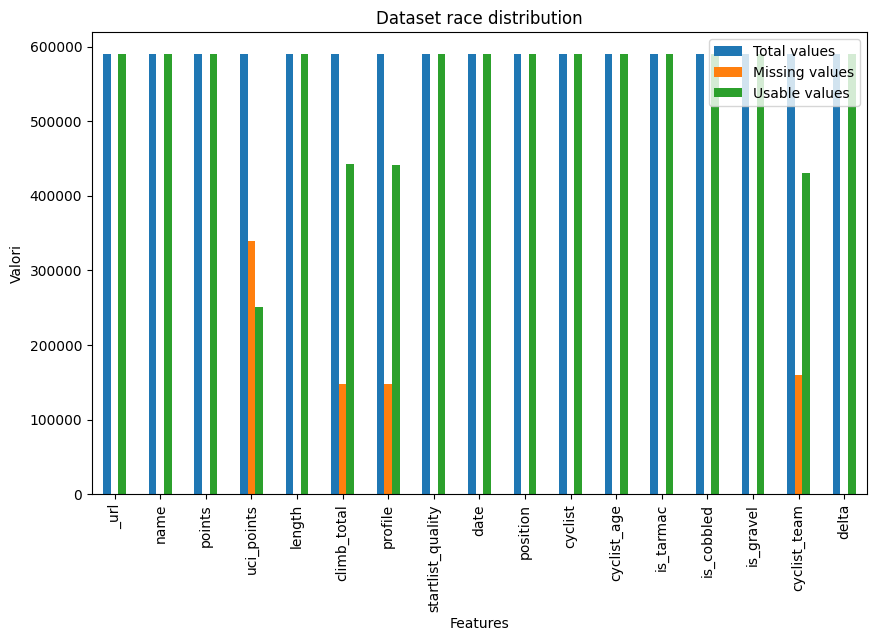

In [44]:
PlotMissingUsableData(DatasetRace, "race")

# **Feature engineering**

Si fa il merge delle tabelle in un unica tabella, prendendo come chiavi di riferimento la colonna "_url" del dataset cyclists e la colonna "cyclists" del dataset race.

                   Total values  Missing values  Usable values
Elements                                                      
name_cyclist             589865               0         589865
birth_year               589865             113         589752
weight                   589865               0         589865
height                   589865               0         589865
nationality              589865               0         589865
name_race                589865               0         589865
points                   589865             477         589388
uci_points               589865          338779         251086
length                   589865               0         589865
climb_total              589865          147045         442820
profile                  589865          148194         441671
startlist_quality        589865               0         589865
date                     589865               0         589865
position                 589865               0        

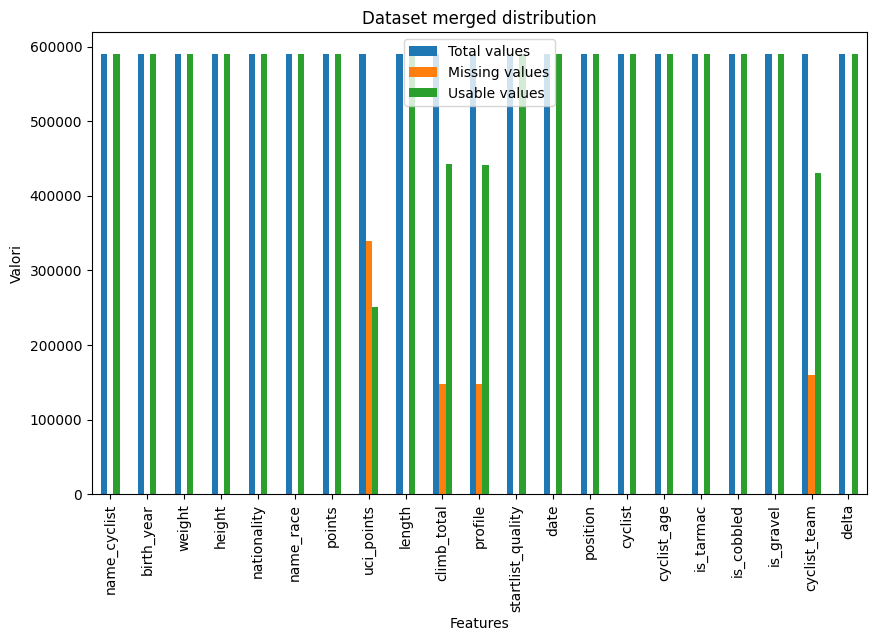

In [45]:
MergeDataset = pd.merge(DatasetCyclists, DatasetRace, left_on = "_url", right_on = "cyclist")

del MergeDataset["name_x"]
del MergeDataset["name_y"]

MergeDataset.rename(columns = {"_url_x": "name_cyclist"}, inplace = True)
MergeDataset.rename(columns = {"_url_y": "name_race"}, inplace = True)

PlotMissingUsableData(MergeDataset, "merged")

# - (Analysis a choosed situation)